# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.
We start by assuming the distribution of lightning in the inner core is Gaussian.

*We look at each basin separately. Below are the basin codes:
* ATL - Atlantic Ocean basin
* CPAC - 
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

## Code
### Import Libraries and Files
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_processing.ipynb` notebook as `innercore_timebin_joined.csv`.

In [5]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches

In [6]:
# import data from csv file
innercore_data = pl.read_csv("data_pipeline/innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
innercore_data = innercore_data.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
innercore_data = innercore_data.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
innercore_data.head()

shape: (5, 21)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time_bin   ┆ storm_code ┆ lightning_ ┆ year ┆ … ┆ 24_hour_pr ┆ Current_C ┆ Intensifi ┆ log_light │
│ ---        ┆ ---        ┆ count      ┆ ---  ┆   ┆ essure_dif ┆ ategory   ┆ cation_Ca ┆ ning_coun │
│ datetime[μ ┆ str        ┆ ---        ┆ i64  ┆   ┆ f          ┆ ---       ┆ tegory_5  ┆ t         │
│ s]         ┆            ┆ i64        ┆      ┆   ┆ ---        ┆ str       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆      ┆   ┆ f64        ┆           ┆ str       ┆ f64       │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2010-06-21 ┆ ATL_10_1   ┆ 1          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.693147  │
│ 07:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 07:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 08:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 08:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 09:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴──────┴───┴────────────┴───────────┴───────────┴───────────┘

We map the intensification bins into 3, combining the rapidly weakening and weakening bins, and the rapidly intensifying and intensifying bins.

In [7]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
innercore_data = innercore_data.with_columns(
    innercore_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

innercore_data.head()

shape: (5, 22)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time_bin   ┆ storm_code ┆ lightning_ ┆ year ┆ … ┆ Current_Ca ┆ Intensifi ┆ log_light ┆ Intensifi │
│ ---        ┆ ---        ┆ count      ┆ ---  ┆   ┆ tegory     ┆ cation_Ca ┆ ning_coun ┆ cation_Ca │
│ datetime[μ ┆ str        ┆ ---        ┆ i64  ┆   ┆ ---        ┆ tegory_5  ┆ t         ┆ tegory_3  │
│ s]         ┆            ┆ i64        ┆      ┆   ┆ str        ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆      ┆   ┆            ┆ str       ┆ f64       ┆ str       │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2010-06-21 ┆ ATL_10_1   ┆ 1          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.693147  ┆ Neutral   │
│ 07:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 07:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 08:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 08:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 09:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴──────┴───┴────────────┴───────────┴───────────┴───────────┘

In [8]:
# Create dataframe for filtering later
storm_names = innercore_data[["storm_code", "storm_name"]].unique()

### Functions

Below are the functions used to evaluate 6 different lightning burst thresholds at the individual TC level. We compare each TC's lightning to itself to identify a burst using the IQR, MAD, and Lognormal methods. The thresholds defined by each of these functions act as a standard for a lightning burst for that TC. If the count in the bin is more than the threshold, we mark it as a lightning burst. Note that we use log-transformed lightning counts in this analysis. We do not include data associated with current wind speeds less than 40 knots in this threshold analysis. 

We also create functions to apply the thresholds and aggregate results, as well as functions used to plot individual TCs for analysis.

In [9]:
# IQR threshold function
def detect_bursts_iqr(group):
    Q1 = group['log_lightning_count'].quantile(0.25)
    Q3 = group['log_lightning_count'].quantile(0.75)
    IQR = Q3 - Q1

    # Set burst threshold for each cyclone individually
    threshold1 = Q3 + 1 * IQR
    threshold2 = Q3 + 1.5* IQR

    # Mark bursts specific to the cyclone
    group['burst_iqr1'] = group['log_lightning_count'] > threshold1
    group['burst_iqr2'] = group['log_lightning_count'] > threshold2
    group['iqr1_threshold'] = threshold1
    group['iqr2_threshold'] = threshold2
    return group

In [10]:
# MAD threshold function
def detect_bursts_mad(group):
    median_log = group['log_lightning_count'].median()
    mad_log = median_abs_deviation(group['log_lightning_count'])

    # Set burst threshold based on MAD for each cyclone
    threshold1 = median_log + 4 * mad_log
    threshold2 = median_log + 5 * mad_log

    # Mark bursts specific to the cyclone
    group['burst_mad1'] = group['log_lightning_count'] > threshold1
    group['burst_mad2'] = group['log_lightning_count'] > threshold2
    group['mad1_threshold'] = threshold1
    group['mad2_threshold'] = threshold2
    return group

In [11]:
# Log normal threshold function
def detect_bursts_lognormal(group):
     # Calculate the mean and standard deviation of the log-transformed lightning count
    mean_log = group['log_lightning_count'].mean()
    std_log = group['log_lightning_count'].std()

    # Set burst thresholds based on log-normal distribution (mean + 2σ and mean + 3σ)
    threshold1 = mean_log + 2 * std_log
    threshold2 = mean_log + 3 * std_log

    # Mark bursts specific to the cyclone
    group['burst_logn1'] = group['log_lightning_count'] > threshold1
    group['burst_logn2'] = group['log_lightning_count'] > threshold2
    group['logn1_threshold'] = threshold1
    group['logn2_threshold'] = threshold2
    return group

In [12]:
# Function to apply the 3 methods, 6 thresholds for individual TCs
def apply_individual_thresholds(df):
    bursts = df.groupby(["storm_code"]).apply(detect_bursts_iqr)
    bursts.reset_index(drop=True, inplace=True)
    bursts = bursts.groupby(["storm_code"]).apply(detect_bursts_mad)
    bursts.reset_index(drop=True, inplace=True)
    bursts = bursts.groupby(["storm_code"]).apply(detect_bursts_lognormal)
    bursts.reset_index(drop=True, inplace=True)
    # Reset index to keep data points in chronological order
    bursts.sort_values(by=["storm_code", "time_bin"], inplace=True)
    bursts.reset_index(drop=True, inplace=True)
    return bursts

In [13]:
# Function used to aggregate results dataframe
def create_tc_summary(processed):
    tc_summary = processed.groupby(["storm_code"]).agg(
        mad1_bursts=('burst_mad1', 'sum'),
        mad2_bursts=('burst_mad2', 'sum'),
        mad1_threshold=('mad1_threshold', 'max'),
        mad2_threshold=('mad2_threshold', 'max'),
        iqr1_bursts=('burst_iqr1', 'sum'),
        iqr2_bursts=('burst_iqr2', 'sum'),
        iqr1_threshold=('iqr1_threshold', 'max'),
        iqr2_threshold=('iqr2_threshold', 'max'),
        logn1_bursts=('burst_logn1', 'sum'),
        logn2_bursts=('burst_logn2', 'sum'),
        logn1_threshold=('logn1_threshold', 'max'),
        logn2_threshold=('logn2_threshold', 'max'),
        total_bins=('storm_code', 'count')
    )
    tc_summary.reset_index(drop=False, inplace=True)
    tc_summary.head(10)

    tc_summary["mad1_prop"] = round((tc_summary["mad1_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["mad2_prop"] = round((tc_summary["mad2_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["iqr1_prop"] = round((tc_summary["iqr1_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["iqr2_prop"] = round((tc_summary["iqr2_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["logn1_prop"] = round((tc_summary["logn1_bursts"]/tc_summary["total_bins"])*100, 2)
    tc_summary["logn2_prop"] = round((tc_summary["logn2_bursts"]/tc_summary["total_bins"])*100, 2)
    return tc_summary

In [14]:
def add_bg_colors(ax, lightning_data, color_type):
    """
    Adds background shading based on either the 'Intensification_Category_3' column or 'Current_Category' column.

    Parameters:
    - ax: The matplotlib axis to plot on.
    - lightning_data: DataFrame with 'time_bin', 'Intensification_Category_3', and 'Current_Category'
    - color_type: toggle between coloring by intensification change category or current category, can only take i3, i5, c5 as values
    """
    # Define color mapping
    i3_colors = {
        "Intensifying": "#FFEE8C",
        "Neutral": "lightgreen",
        "Weakening": "lightblue",
        "Unidentified":"white"
    }
    i5_colors = {
        "Rapidly Intensifying": "#f6aeae",
        "Intensifying": "#FFEE8C",
        "Neutral": "lightgreen",
        "Weakening": "lightblue",
        "Rapidly Weakening": "#dab1da",
        "Unidentified":"white"
    }
    c5_colors = {
        "0":'white',
        "1":'#FFEE8C',
        "2":'lightgreen',
        "3":'lightblue',
        "4":'#dab1da',
        "5":'pink'
    }

    # Define color_type toggle
    color_type_toggle = {
        "i3":["Intensification_Category_3", i3_colors],
        "i5":["Intensification_Category_5", i5_colors],
        "c5":["Current_Category", c5_colors]
    }
    # Exit if inputted color type is not valid
    if color_type not in color_type_toggle.keys():
        return(print(f"Not a valid background color type. Choose either: {', '.join(color_type_toggle.keys())}"))

    category_colors = color_type_toggle[color_type][1]
    column_name = color_type_toggle[color_type][0]
    for i in range(len(lightning_data) - 1):
        category = lightning_data[column_name].iloc[i]
        color = category_colors.get(category, "red")  # Default to red if not found - flag this as an error

        ax.axvspan(lightning_data['time_bin'].iloc[i],
                   lightning_data['time_bin'].iloc[i + 1],
                   color=color, alpha=0.3)

    # Create custom legend patches
    legend_patches = [mpatches.Patch(color=c, label=cat) for cat, c in category_colors.items()]
    return legend_patches  # Return legend handles

In [15]:
def plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, bg_type):
    cyclone_name = storm_names.filter(pl.col("storm_code") == cyclone_id)["storm_name"].item()
    df_cyclone = processed[processed['storm_code'] == cyclone_id]
    lightning_data = innercore_data.filter(pl.col("storm_code") == cyclone_id).to_pandas()

    plt.figure(figsize=(10, 5))

    # Create first y-axis for lightning
    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.plot(lightning_data['time_bin'], lightning_data['lightning_count'], label='Lightning Count', color='gray')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Lightning Count", color="gray")
    ax1.tick_params(axis='y', labelcolor="gray")

    # Create second y-axis for pressure
    ax2 = ax1.twinx()
    ax2.plot(lightning_data['time_bin'], lightning_data['pressure'], label='Pressure', color='orange')
    ax2.set_ylabel("Pressure", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    # Create third y-axis for wind knot
    ax2 = ax1.twinx()
    ax2.plot(lightning_data['time_bin'], lightning_data['knots'], label='Wind', color='blue')
    ax2.set_ylabel("Wind", color="blue")
    ax2.tick_params(axis='y', labelcolor="blue")

    # Call bg colors function
    legend_patches = add_bg_colors(ax1, lightning_data, bg_type)

    # Mark bursts detected by MAD
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad1']],
                df_cyclone['lightning_count'][df_cyclone['burst_mad1']],
                color='red', label='MAD Detected Burst -threshold1', s=50, marker='o', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad2']],
                df_cyclone['lightning_count'][df_cyclone['burst_mad2']],
                color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o', alpha=0.7)

    # Mark bursts detected by IQR
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr1']],
                df_cyclone['lightning_count'][df_cyclone['burst_iqr1']],
                color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr2']],
                df_cyclone['lightning_count'][df_cyclone['burst_iqr2']],
                color='green', label='IQR Detected Burst - threshold2', s=50, marker='x', alpha=0.7)

    # Mark bursts detected by lognormal threshold
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_logn1']],
                df_cyclone['lightning_count'][df_cyclone['burst_logn1']],
                color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_logn2']],
                df_cyclone['lightning_count'][df_cyclone['burst_logn2']],
                color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^', alpha=0.7)

    plt.xlabel('Time')
    plt.title(f'Lightning Burst Detection for {cyclone_name} ({cyclone_id})')
    ax1.legend(loc='upper left')
    ax2.legend(handles=legend_patches, loc='center left')
    plt.xticks(visible=False)
    plt.grid()
    plt.show()

In [16]:
def group_bins_category(dataset):
    # split bins into 0-2, 1-2, and 3-5 categories - return 3 datasets
    weak_cat0 = ["0", "1", "2"]
    weak_cat1 = ["1", "2"]
    strong_cat = ["3", "4", "5"]

    # separate the 2 category groupings
    weak0_lightning = dataset[dataset["Current_Category"].isin(weak_cat0)]
    print(f"{len(weak0_lightning)} non-zero lightning count timebins associated with category {min(weak_cat0)}-{max(weak_cat0)} wind speeds in EPAC basin.")

    weak1_lightning = dataset[dataset["Current_Category"].isin(weak_cat1)]
    print(f"{len(weak1_lightning)} non-zero lightning count timebins associated with category {min(weak_cat1)}-{max(weak_cat1)} wind speeds in EPAC basin.")

    strong_lightning = dataset[dataset["Current_Category"].isin(strong_cat)]
    print(f"{len(strong_lightning)} non-zero lightning count timebins associated with category {min(strong_cat)}-{max(strong_cat)} wind speeds in EPAC basin.")

    return weak0_lightning, weak1_lightning, strong_lightning

In [17]:
def plot_threshold_histogram(dataset, threshold_type, ax=None):
    if ax is None: # enable plotting multiple in a grid if ax passed in
        fig, ax = plt.subplots()
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    if ax is None:
        fig, ax = plt.subplots()
    plot_data = dataset[threshold_names[threshold_type][0]]
    if plot_data is None or len(plot_data) == 0 or sum(plot_data.isnull()) == len(plot_data):  # Check if data is empty
        ax.text(0.5, 0.5, "No Data Available", fontsize=12, ha='center', va='center')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])  # Hide x-axis ticks
        ax.set_yticks([])  # Hide y-axis ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(f"Histogram of {threshold_names[threshold_type][1]} Burst Threshold")
    else:
        ax.hist(plot_data, bins=20, edgecolor="black", align="left")
        ax.set_xlabel("Lightning Burst Threshold (Log10 Scale)")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Histogram of {threshold_names[threshold_type][1]} Burst Threshold")

In [18]:
def plot_threshold_boxplot(dataset, category_group, ax=None):
    plt.figure(figsize=(10, 6))
    plt.boxplot([dataset['mad1_threshold'], dataset['mad2_threshold'], dataset['iqr1_threshold'],
                dataset['iqr2_threshold'], dataset['logn1_threshold'], dataset['logn2_threshold']]
                , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'))

    plt.title(f'Threshold Value Comparison - {category_group}')
    plt.ylabel('Values')

    plt.show()

In [19]:
def create_burst_summary(dataset):
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    threshold_keys = list(threshold_names.keys())
    burst_labels = [f'burst_{key}' for key, value in threshold_names.items()]
    # Generate burst summary
    burst_summary = {
        "Threshold": threshold_keys,
        "Burst Count": [dataset[b].sum() for b in burst_labels],
        "Timebin Count": [dataset["time_bin"].count() for i in range(len(burst_labels))],
        "Burst Percentage": [round(dataset[b].sum()/dataset["time_bin"].count()*100, 2) for b in burst_labels]
    }
    burst_summary = pd.DataFrame(burst_summary)
    return burst_summary

In [95]:
def create_basin_summary(dataset, category_group, basin, std_dev=None):
    if std_dev is None:
        std_dev = 2
    valid_categories = ["0-2", "1-2", "3-5", "all"]
    valid_basins = ["ATL", "EPAC", "WPAC", "IO", "SHEM", "CPAC"]
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    threshold_keys = list(threshold_names.keys())
    threshold_cols = [threshold_names[key][0] for key in threshold_keys]

    # Check for valid input
    if category_group not in valid_categories:
        return(print(f"Not a valid category grouping. Choose either: {', '.join(valid_categories)}"))
    elif basin not in valid_basins:
        return(print(f"Not a valid basin. Choose either: {', '.join(valid_basins)}"))

    burst_summary = create_burst_summary(dataset)

    # Get mean and 2 standard deviations - threshold summary
    threshold_summary = {
        "Basin": [basin for i in range(len(threshold_keys))],
        "Category Group": [category_group for i in range(len(threshold_keys))],
        "Threshold": threshold_keys,
        "Mean": [dataset[col].mean() for col in threshold_cols],
        "Std Dev": [dataset[col].std() for col in threshold_cols],
        "Median": [dataset[col].median() for col in threshold_cols],
        "Min": [dataset[col].min() for col in threshold_cols],
        "Max": [dataset[col].max() for col in threshold_cols]
    }
    threshold_summary = pd.DataFrame(threshold_summary)

    calculated_thresholds = {
        "Threshold": threshold_keys,
        f"Basin-Category Threshold (Mean-Based) {std_dev} SD": [dataset[col].mean()+std_dev*dataset[col].std() for col in threshold_cols],
        f"Basin-Category Threshold (Median-Based) {std_dev} SD": [dataset[col].median()+std_dev*dataset[col].std() for col in threshold_cols]
    }
    calculated_thresholds = pd.DataFrame(calculated_thresholds)

    # Join the two dataframes and return
    return pd.merge(pd.merge(threshold_summary, burst_summary, on="Threshold"), calculated_thresholds, on="Threshold")

In [102]:
def create_basin_threshold_dict(summary_data):
    basin_thresholds_mean = {}
    column_names = {}
    for col in summary_data.columns:
        if "Basin-Category Threshold (Mean-Based)" in col:
            column_names["mean"] = col
        elif "Basin-Category Threshold (Median-Based)" in col:
            column_names["median"] = col
    for i in range(len(summary_data)):
        basin_thresholds_mean[summary_data["Threshold"][i]] = summary_data[column_names["mean"]][i]
    basin_thresholds_median = {}
    for i in range(len(summary_data)):
        basin_thresholds_median[summary_data["Threshold"][i]] = summary_data[column_names["median"]][i]

    return basin_thresholds_mean, basin_thresholds_median

In [ ]:
def detect_bursts_basin(group, thresholds):
    # Use thresholds passed in as dictionary
    for key, value in thresholds.items():
        threshold = value
        group[f'burst_{key}'] = group['log_lightning_count'] > threshold
        group[f'{key}_threshold'] = threshold

    return group

In [23]:
def apply_basin_thresholds(df, basin_thresholds):
    # drop bins with 0 lightning count
    clean_data = df[df['lightning_count'] != 0]

    bursts = clean_data.groupby(["storm_code"]).apply(detect_bursts_basin, thresholds = basin_thresholds)
    bursts.reset_index(drop=True, inplace=True)

    bursts.sort_values(by=["storm_code", "time_bin"], inplace=True)
    bursts.reset_index(drop=True, inplace=True)

    return bursts

In [24]:
def column_rename_helper(threshold_type=None):
    column_names = {
        "mean": {"Burst Count": "Mean-Based Threshold Bursts",
                "Burst Percentage":"Mean-Based Threshold Burst Percentage"},
        "median":{"Burst Count": "Median-Based Threshold Bursts",
                  "Burst Percentage":"Median-Based Threshold Burst Percentage"}
    }
    if threshold_type == "effective":
        column_names = {
            "mean": {"Burst Count": "Mean-Based Effective Threshold Bursts",
                    "Burst Percentage":"Mean-Based Effective Threshold Burst Percentage"},
            "median":{"Burst Count": "Median-Based Effective Threshold Bursts",
                    "Burst Percentage":"Median-Based Effective Threshold Burst Percentage"}
        }
    return column_names

In [115]:
def summarize_threshold_eval(summary_data, lightning_data, threshold_data=None, threshold_type=None):

    # Create threshold dictionaries to apply at basin level (categories 3-5)
    if threshold_data is not None:
        mean_thresholds, median_thresholds = create_basin_threshold_dict(threshold_data)
    else:
        mean_thresholds, median_thresholds = create_basin_threshold_dict(summary_data)

    # Create agg results at individual TC level for the mean and median threshold methods
    bursts_mean = apply_basin_thresholds(lightning_data, mean_thresholds)
    tc_summary_mean = create_tc_summary(bursts_mean)

    bursts_median = apply_basin_thresholds(lightning_data, median_thresholds)
    tc_summary_median = create_tc_summary(bursts_median)

    # Create burst summary at basin level
    column_names = column_rename_helper(threshold_type)
    burst_summary_mean = create_burst_summary(bursts_mean)
    burst_summary_mean = burst_summary_mean.rename(columns=column_names["mean"])

    burst_summary_median = create_burst_summary(bursts_median)
    burst_summary_median = burst_summary_median.rename(columns=column_names["median"])

    # Add to the basin summary
    if threshold_type == "effective" and threshold_data is not None:
        rename_cols = {}
        for col in threshold_data.columns:
            if "Basin-Category Threshold (Mean-Based)" in col:
                rename_cols["mean"] = col
            elif "Basin-Category Threshold (Median-Based)" in col:
                rename_cols["median"] = col
        threshold_data_temp = threshold_data[["Threshold", rename_cols["mean"], rename_cols["median"]]].rename(
            columns={rename_cols["mean"]: "Basin-Category Effective Threshold (Mean-Based)"+rename_cols["mean"].split(")")[1],
            rename_cols["median"]: "Basin-Category Effective Threshold (Median-Based)"+rename_cols["median"].split(")")[1]}
            )
        summary_data = pd.merge(summary_data, threshold_data_temp, on="Threshold")
    summary_data = pd.merge(summary_data, burst_summary_mean[["Threshold", column_names["mean"]["Burst Count"], column_names["mean"]["Burst Percentage"]]], on="Threshold")
    summary_data = pd.merge(summary_data, burst_summary_median[["Threshold", column_names["median"]["Burst Count"], column_names["median"]["Burst Percentage"]]], on="Threshold")

    return summary_data, bursts_mean, tc_summary_mean, bursts_median, tc_summary_median

---------------------

### Individual TC Analysis
We start by applying the 6 different thresholds to each TC individually, where we evaluate burst thresholds in comparison to a TC's own lightning activity for time bins associated with wind speeds greater than or equal to 40 knots. We start by filtering out data associated with wind speeds less than 40 knots.

In [26]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = innercore_data.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

We then apply the functions to the data, including timebins with no lightning activity.

In [27]:
# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds(pd_data)

tc_summary_w_0 = create_tc_summary(bursts_w_0)
tc_summary_w_0.head(10)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1           40           40        0.000000        0.000000   
1  ATL_10_11           54           54        0.000000        0.000000   
2  ATL_10_12           83           83        0.000000        0.000000   
3  ATL_10_13           43           35        1.732868        2.079442   
4  ATL_10_14           23           23        0.000000        0.000000   
5  ATL_10_17           75           75        0.000000        0.000000   
6  ATL_10_18            0            0        7.791445        9.023858   
7  ATL_10_19           58           58        0.000000        0.000000   
8  ATL_10_20           12            7        3.465736        4.158883   
9  ATL_10_21          100           75        3.465736        4.158883   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0           40           40        0.000000        0.000000            10   
1           54           54        0.000000        0.000000            25   
2           83           83        0.000000        0.000000            24   
3            6            1        4.552490        5.690612             6   
4           23           23        0.000000        0.000000            15   
5           57           56        1.386294        1.732868            24   
6            0            0        6.425564        7.595410             3   
7            1            0        5.344880        6.681100             6   
8            6            1        4.394449        5.493061             5   
9           35            2        5.545177        6.931472            34   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             4         1.964998         2.766760         168      23.81   
1            17         0.905833         1.299925         524      10.31   
2            10         2.714949         3.820770         347      23.92   
3             0         4.401910         5.986869         130      33.08   
4             5         1.092380         1.547290         144      15.97   
5             2         3.893827         5.435464         270      27.78   
6             0         5.929778         7.469033         180       0.00   
7             0         4.938227         6.723796         120      48.33   
8             0         4.549465         6.195277          77      15.58   
9             0         5.640493         7.671843         476      21.01   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      23.81      23.81      23.81        5.95        2.38  
1      10.31      10.31      10.31        4.77        3.24  
2      23.92      23.92      23.92        6.92        2.88  
3      26.92       4.62       0.77        4.62        0.00  
4      15.97      15.97      15.97       10.42        3.47  
5      27.78      21.11      20.74        8.89        0.74  
6       0.00       0.00       0.00        1.67        0.00  
7      48.33       0.83       0.00        5.00        0.00  
8       9.09       7.79       1.30        6.49        0.00  
9      15.76       7.35       0.42        7.14        0.00

In [28]:
# Get mean threshold value for each of the 6 options
tc_summary_w_0_mean = tc_summary_w_0.drop(columns=("storm_code")).mean()
print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
tc_summary_w_0_median = tc_summary_w_0.drop(columns=("storm_code")).median()
print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

mad1_threshold     1.080206
mad2_threshold     1.289705
iqr1_threshold     2.292736
iqr2_threshold     2.859537
logn1_threshold    3.085677
logn2_threshold    4.239224
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     1.386294
iqr2_threshold     1.732868
logn1_threshold    2.925341
logn2_threshold    4.069471
dtype: float64


We can see that the threshold values are all very low, meaning that any lightning activity is likely to be flagged as a burst. We plot one TC below to look at a specific example. This can be expected, as we know that many of the timebins have no lightning activity, therefore skewing the threshold lower.

<Figure size 1000x500 with 0 Axes>

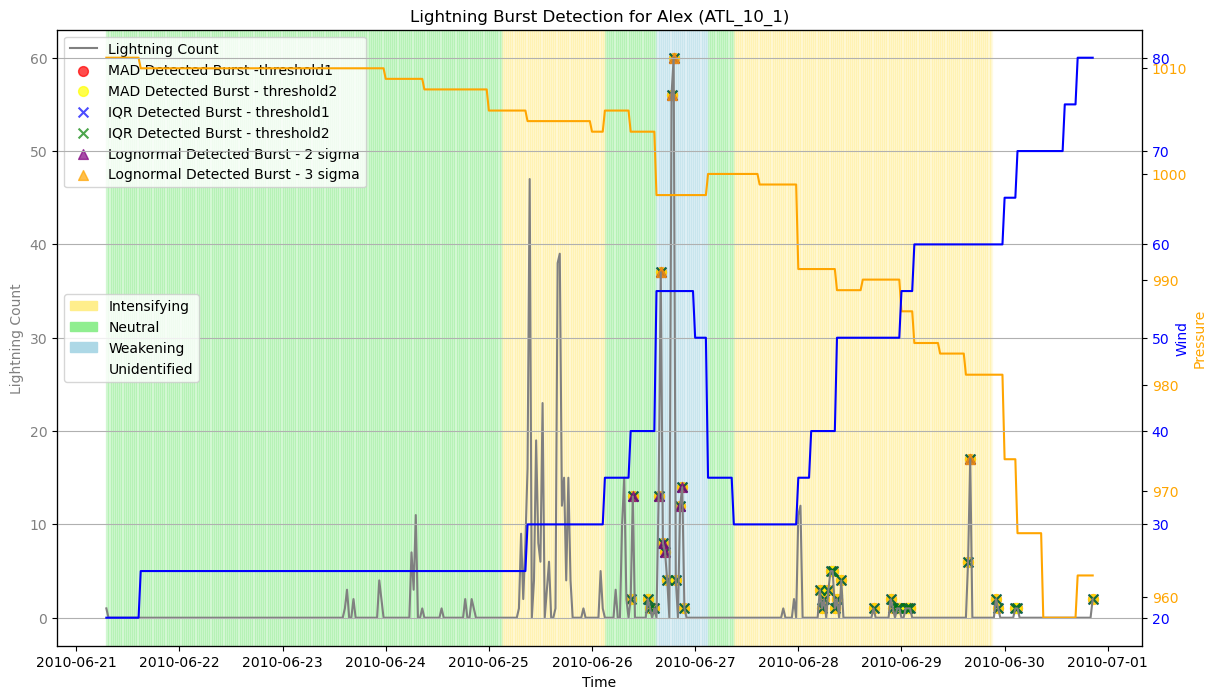

<Figure size 1000x500 with 0 Axes>

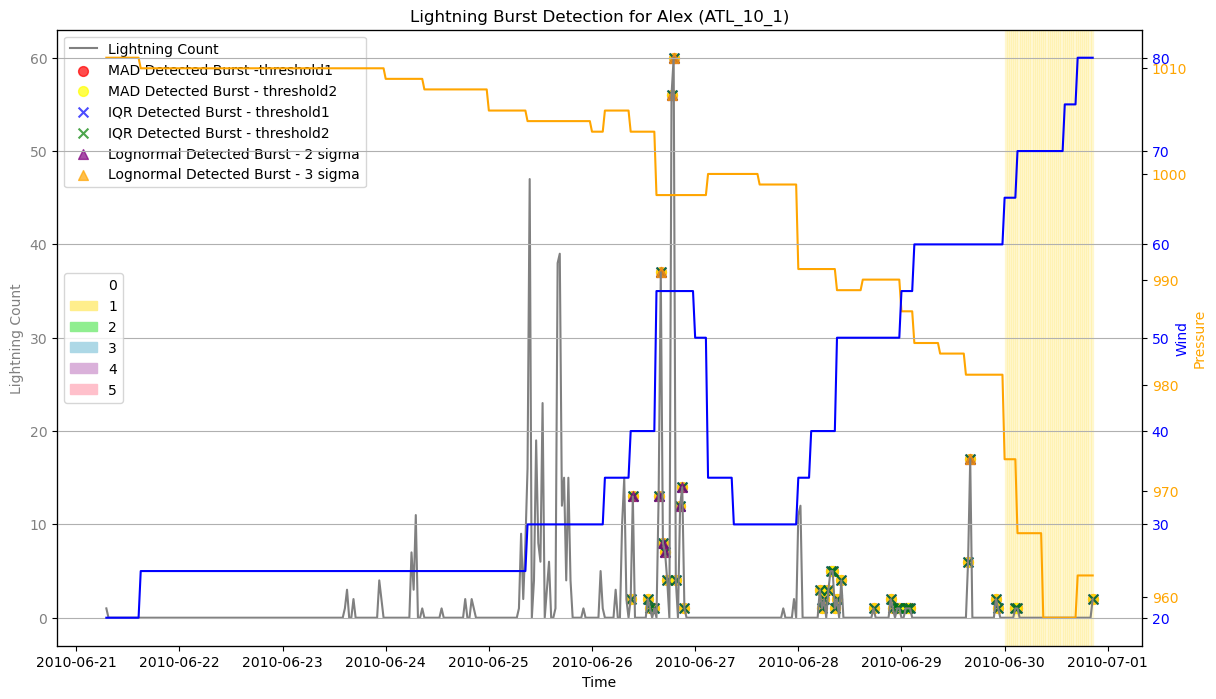

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1           40           40             0.0             0.0   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0           40           40             0.0             0.0            10   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             4         1.964998          2.76676         168      23.81   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      23.81      23.81      23.81        5.95        2.38

In [29]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'
plot_tc_intensification(cyclone_id, bursts_w_0, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts_w_0, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

Next, we try applying the thresholds to the dataset without timebins with 0 lightning count. This slightly alters our definition of a lightning burst - we now compare each set of lightning events to other nonzero lightning events. This should bring up the threshold and bring down the percent of timebins flagged as a burst.

In [30]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds(pd_data_drop0)

tc_summary = create_tc_summary(bursts)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
0   EPAC_18_2     Aletta            0            0        7.033506   
1  WPAC_16_26      Meari            0            0        7.187657   
2   EPAC_19_7    Flossie            0            0        8.189478   
3   ATL_17_13      Katia            0            0        5.274601   
4  EPAC_19_15     Lorena            0            0        7.483536   
5  WPAC_11_10   Nock-Ten            1            0        4.564348   
6   EPAC_15_5    Dolores            0            0        6.303652   
7   EPAC_11_2    Beatriz            1            0        5.723757   
8  WPAC_18_17  Seventeen            9            9        1.909543   
9  WPAC_18_17   Shanshan            9            9        1.909543   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0        8.132119            3            2        5.293698        6.270548   
1        8.363345            2            0        6.114804        7.282985   
2        9.551768            0            0        6.695130        8.094259   
3        6.190892            5            1        3.912023        4.716742   
4        8.677407            6            0        6.330050        7.510203   
5        5.257495            4            1        3.871201        4.564348   
6        7.359705            0            0        5.703782        6.855075   
7        6.668218            1            0        5.493061        6.591674   
8        2.112275            0            0        4.435683        5.269950   
9        2.112275            0            0        4.435683        5.269950   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             0         5.414039         6.847833          78       0.00   
1  ...             0         5.774613         7.303969          78       0.00   
2  ...             0         5.794436         7.328825         104       0.00   
3  ...             0         4.128978         5.295669          45       0.00   
4  ...             0         6.134410         7.753040         150       0.00   
5  ...             0         4.076313         5.161956          67       1.49   
6  ...             0         5.126240         6.498985         101       0.00   
7  ...             0         5.285497         6.781191          47       2.13   
8  ...             0         3.981056         5.024065          20      45.00   
9  ...             0         3.981056         5.024065          20      45.00   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0        0.0       3.85       2.56        3.85         0.0  
1        0.0       2.56       0.00        3.85         0.0  
2        0.0       0.00       0.00        0.96         0.0  
3        0.0      11.11       2.22        8.89         0.0  
4        0.0       4.00       0.00        4.00         0.0  
5        0.0       5.97       1.49        2.99         0.0  
6        0.0       0.00       0.00        2.97         0.0  
7        0.0       2.13       0.00        6.38         0.0  
8       45.0       0.00       0.00        5.00         0.0  
9       45.0       0.00       0.00        5.00         0.0  

[10 rows x 21 columns]

<Figure size 1000x500 with 0 Axes>

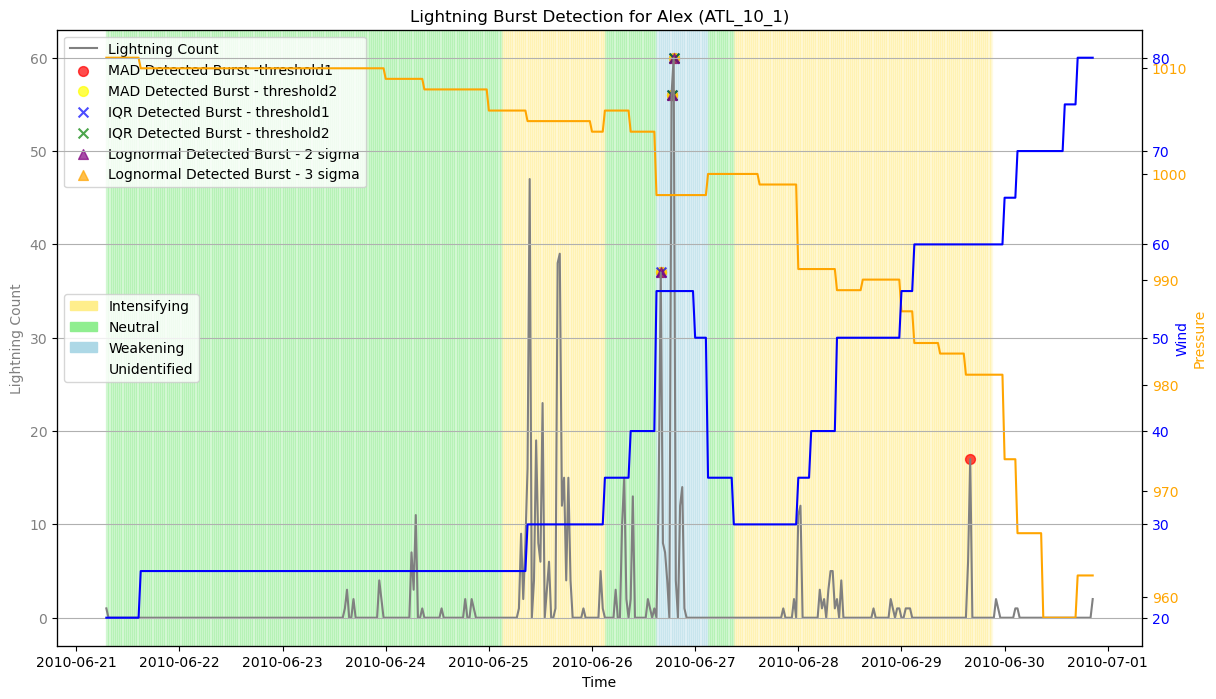

<Figure size 1000x500 with 0 Axes>

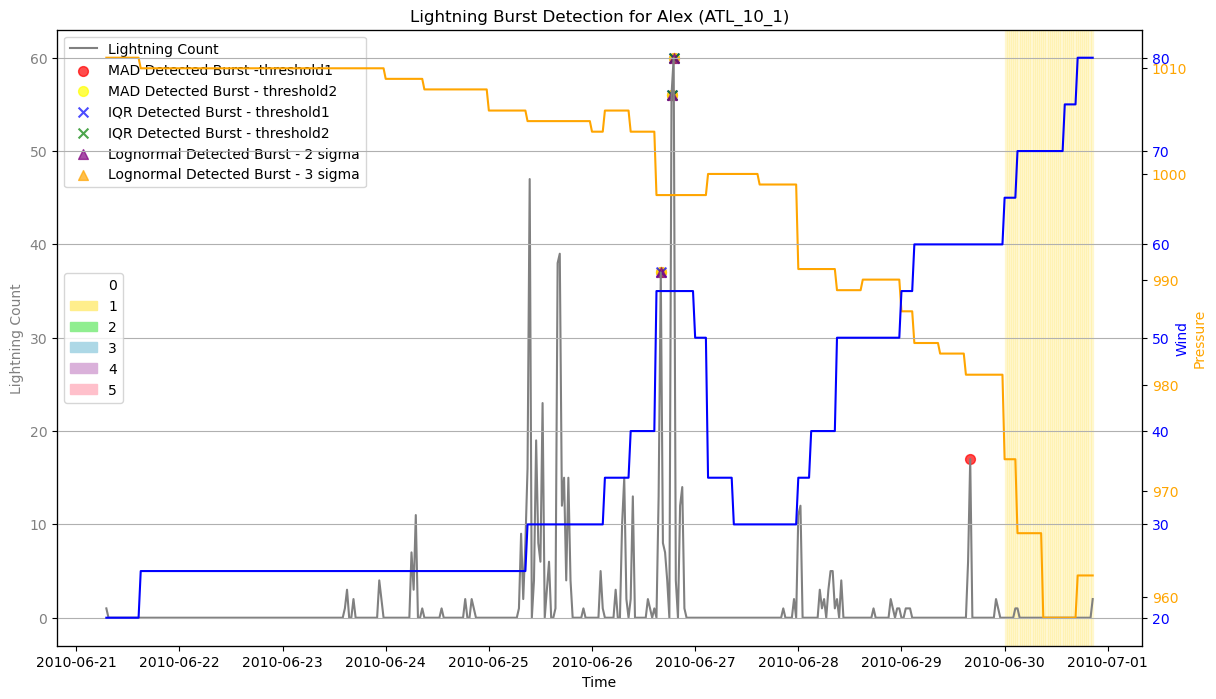

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
362   ATL_10_1       Alex            4            3        2.720473   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
362        3.125938            3            2        3.265439        3.908512   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
362  ...             0         3.469047         4.444476          40   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
362       10.0        7.5        7.5        5.0         7.5         0.0  

[1 rows x 21 columns]

In [31]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

We see above that the analysis including timebins with 0 lightning events skews the threshold to 0, such that any lightning event is flagged as a burst. This is not realistic, and so we will not include the timebins with 0 lightning events in our threshold analysis.

Below, we look at a couple more TCs. We plot the lightning, wind, pressure, all detected lightning bursts using the 6 thresholds created above, and their intensification category/current category bins as color-coded backgrounds. Note that all data is plotted, regardless of if the point was included in the analysis (we do not consider data points associated with winds less than 40 knots in our threshold analysis).

<Figure size 1000x500 with 0 Axes>

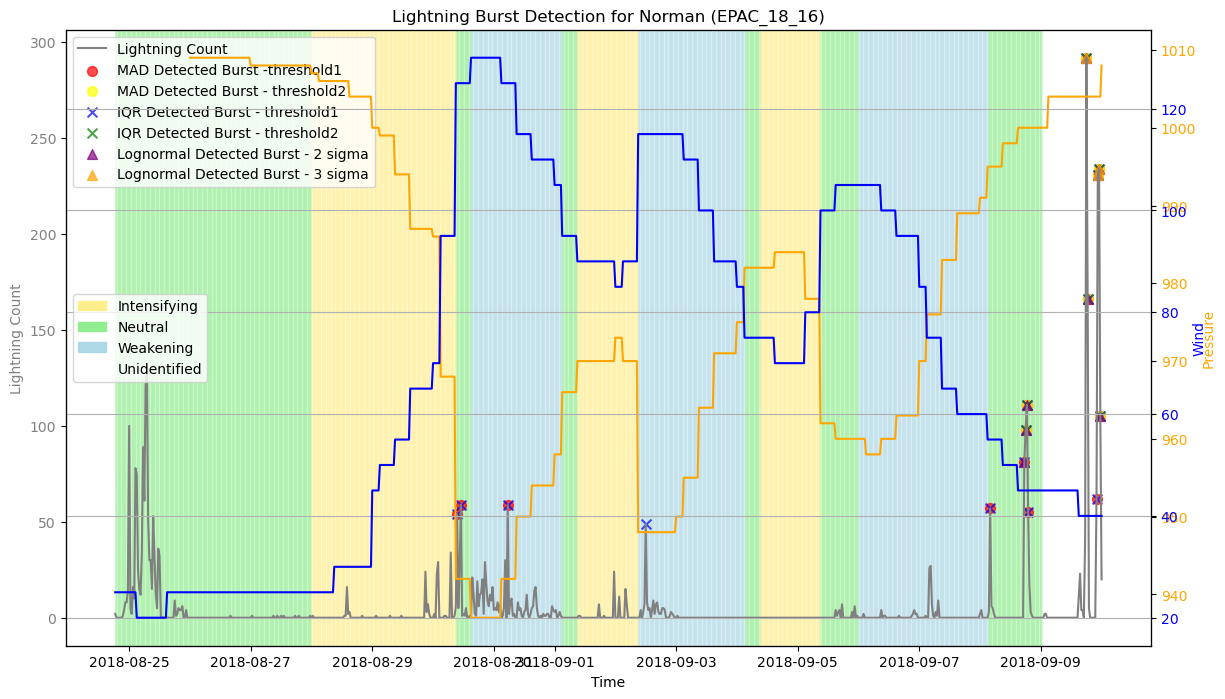

<Figure size 1000x500 with 0 Axes>

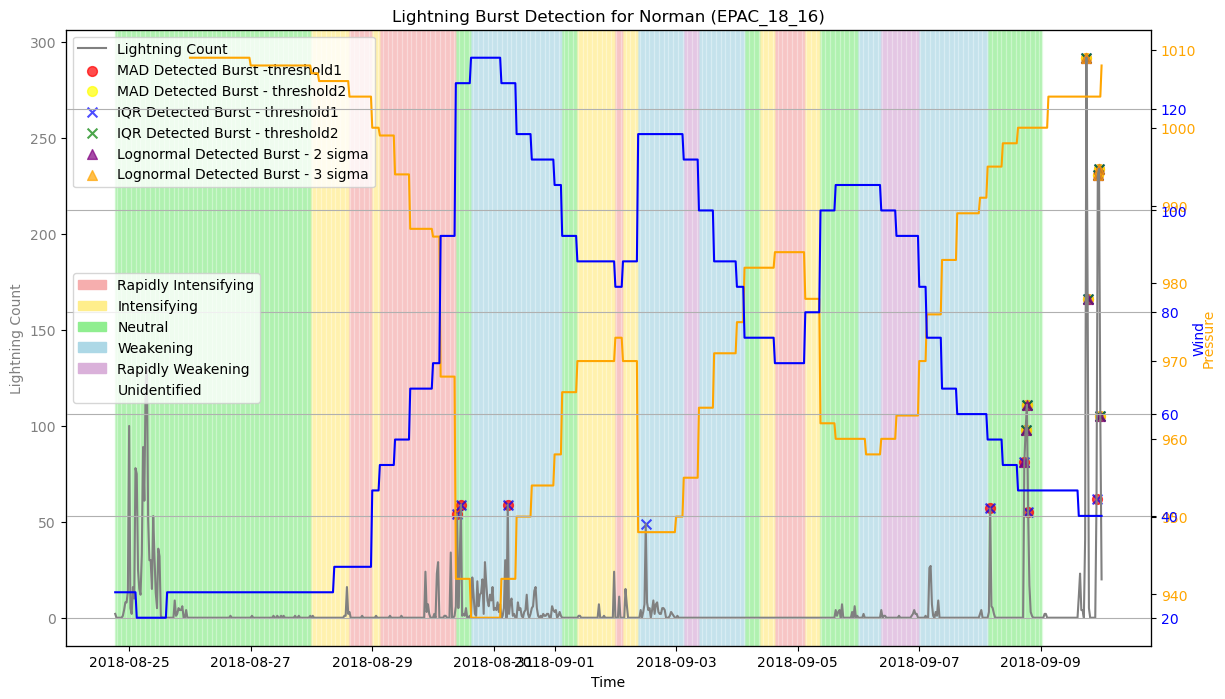

<Figure size 1000x500 with 0 Axes>

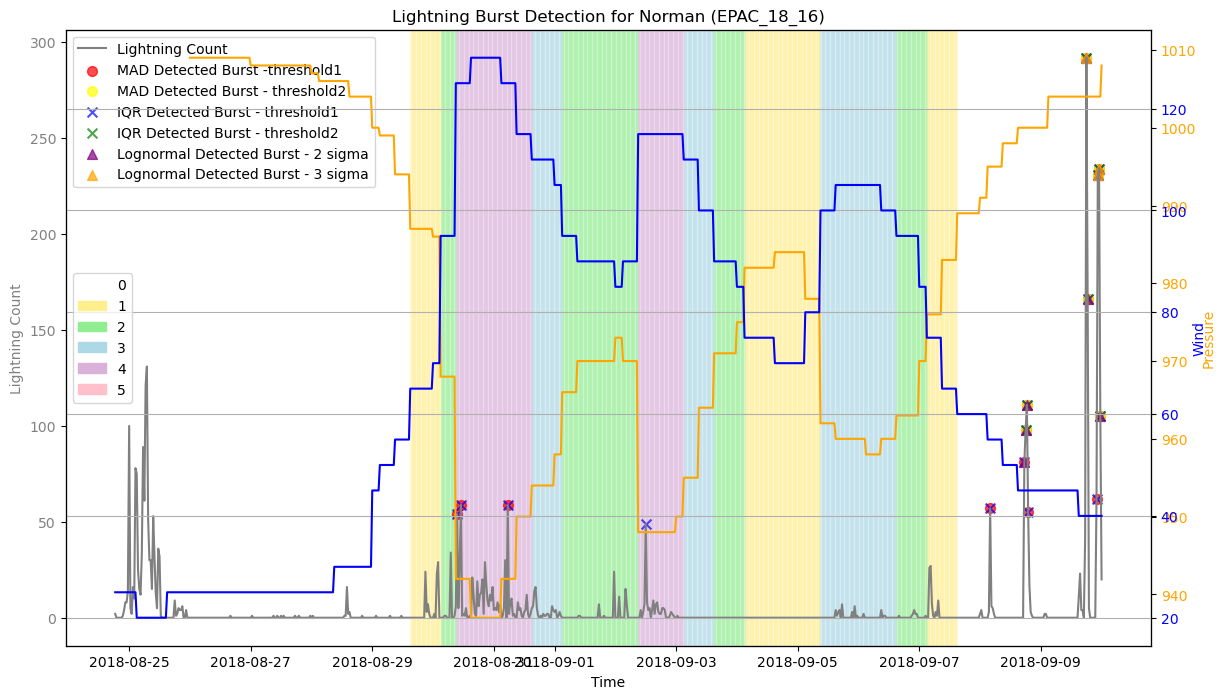

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
189  EPAC_18_16     Norman           14            7        3.960585   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
189        4.548371           15            7        3.871201        4.564348   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
189  ...             3         4.218458         5.368579         170   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
189       8.24       4.12       8.82       4.12        4.71        1.76  

[1 rows x 21 columns]

In [32]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_18_16'
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

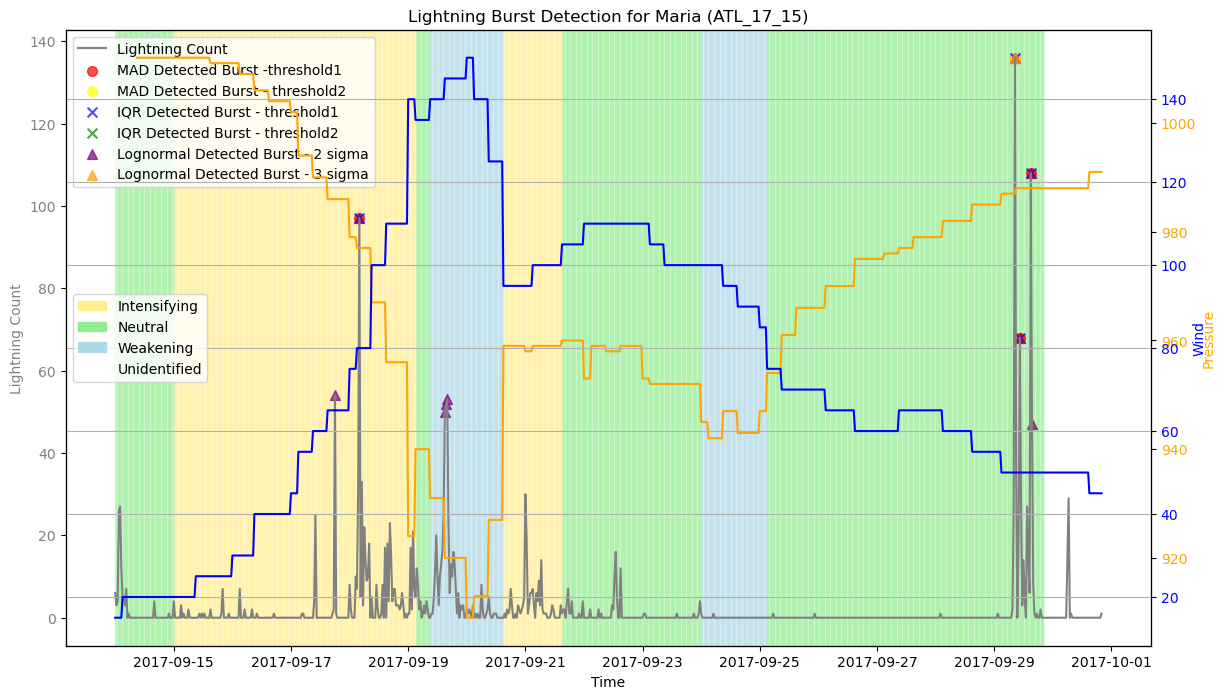

<Figure size 1000x500 with 0 Axes>

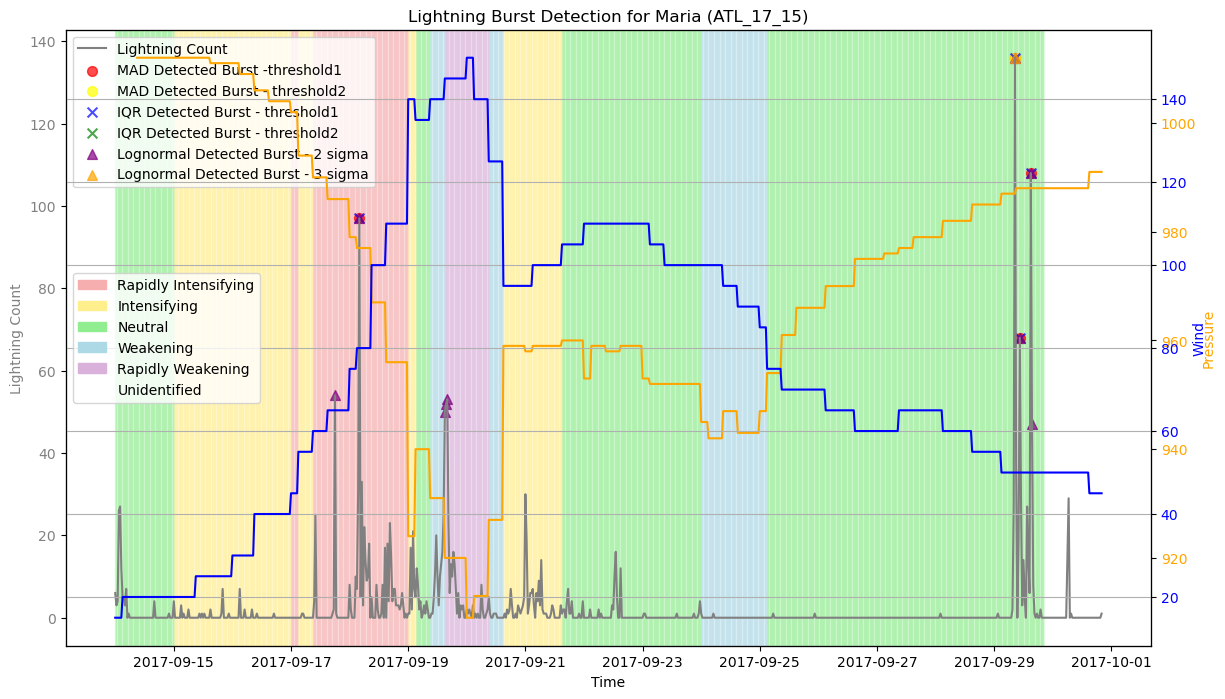

<Figure size 1000x500 with 0 Axes>

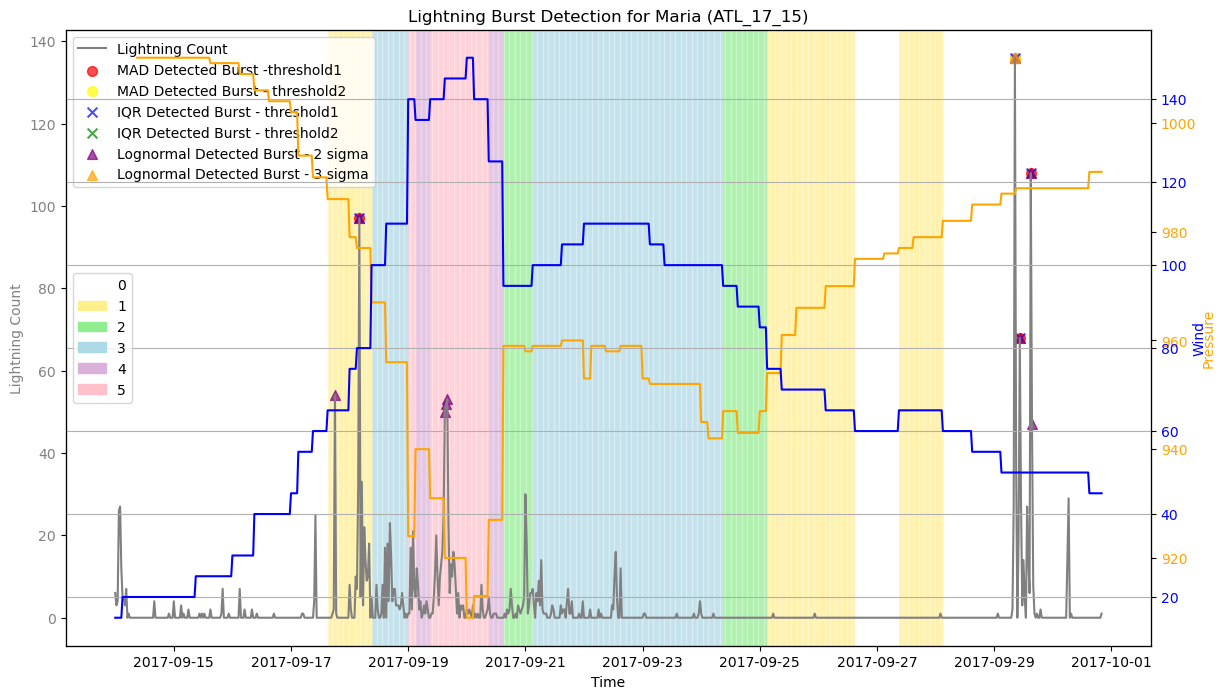

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
231  ATL_17_15      Maria            4            1        4.158883   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
231         4.85203            4            0        4.102643        4.955017   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
231  ...             1         3.761648         4.773138         191   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
231       2.09       0.52       2.09        0.0        4.71        0.52  

[1 rows x 21 columns]

In [33]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

In [34]:
# Export for external tool vis
# marker - rename files?
innercore_data.write_csv("vis_data/tc_lightning_vis_data.csv")
tc_summary.to_csv("vis_data/threshold_summary.csv")
bursts.to_csv("vis_data/tc_threshold.csv")

In [35]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','Lognormal 2 Sigma'],
    'logn2':['logn2_threshold','Lognormal 3 Sigma'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [36]:
# No bursts detected
# marker - need to look into why the agg result dataframes are not the same length??
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

11 TCs of 472 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
106 TCs of 478 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.


-------------------

### EPAC Basin
We now look at lightning burst thresholds at the basin level, starting with EPAC. We take the individual TC thresholds for TCs in the EPAC basin and create a basin-level standard separated by current category, where categories 0-2 are grouped together and categories 3-5 are grouped together.

In [37]:
# Get list of EPAC storm codes
epac_data = innercore_data.filter(pl.col("basin") == "EPAC")
epac_storm_codes = epac_data["storm_code"].unique()
epac_storm_codes.head(5)

shape: (5,)
Series: 'storm_code' [str]
[
	"EPAC_18_10"
	"EPAC_20_12"
	"EPAC_14_11"
	"EPAC_20_9"
	"EPAC_15_3"
]

In [38]:
# Filter aggregated table to EPAC only
epac_tc_summary = tc_summary[tc_summary["storm_code"].isin(epac_storm_codes)]
epac_tc_summary.head()

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
0   EPAC_18_2     Aletta            0            0        7.033506   
2   EPAC_19_7    Flossie            0            0        8.189478   
4  EPAC_19_15     Lorena            0            0        7.483536   
6   EPAC_15_5    Dolores            0            0        6.303652   
7   EPAC_11_2    Beatriz            1            0        5.723757   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0        8.132119            3            2        5.293698        6.270548   
2        9.551768            0            0        6.695130        8.094259   
4        8.677407            6            0        6.330050        7.510203   
6        7.359705            0            0        5.703782        6.855075   
7        6.668218            1            0        5.493061        6.591674   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             0         5.414039         6.847833          78       0.00   
2  ...             0         5.794436         7.328825         104       0.00   
4  ...             0         6.134410         7.753040         150       0.00   
6  ...             0         5.126240         6.498985         101       0.00   
7  ...             0         5.285497         6.781191          47       2.13   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0        0.0       3.85       2.56        3.85         0.0  
2        0.0       0.00       0.00        0.96         0.0  
4        0.0       4.00       0.00        4.00         0.0  
6        0.0       0.00       0.00        2.97         0.0  
7        0.0       2.13       0.00        6.38         0.0  

[5 rows x 21 columns]

In [39]:
# Filter burst point data to EPAC only
epac_bursts = bursts[bursts["storm_code"].isin(epac_storm_codes)]
epac_bursts.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
10047 2010-06-19 18:30:00  EPAC_10_4                5  2010      6   19    18   
10048 2010-06-19 20:30:00  EPAC_10_4                1  2010      6   19    20   
10049 2010-06-20 11:30:00  EPAC_10_4                1  2010      6   20    11   
10050 2010-06-20 12:00:00  EPAC_10_4                7  2010      6   20    12   
10051 2010-06-20 12:30:00  EPAC_10_4               26  2010      6   20    12   

       minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
10047      30  12.4 -97.6  ...        5.172376        6.190817      False   
10048      30  12.4 -97.6  ...        5.172376        6.190817      False   
10049      30  11.8 -99.5  ...        5.172376        6.190817      False   
10050       0  11.8 -99.5  ...        5.172376        6.190817      False   
10051      30  11.8 -99.5  ...        5.172376        6.190817      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
10047       False       6.704246         7.89383        False        False   
10048       False       6.704246         7.89383        False        False   
10049       False       6.704246         7.89383        False        False   
10050       False       6.704246         7.89383        False        False   
10051       False       6.704246         7.89383        False        False   

      logn1_threshold logn2_threshold  
10047        4.679426        5.944917  
10048        4.679426        5.944917  
10049        4.679426        5.944917  
10050        4.679426        5.944917  
10051        4.679426        5.944917  

[5 rows x 34 columns]

Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

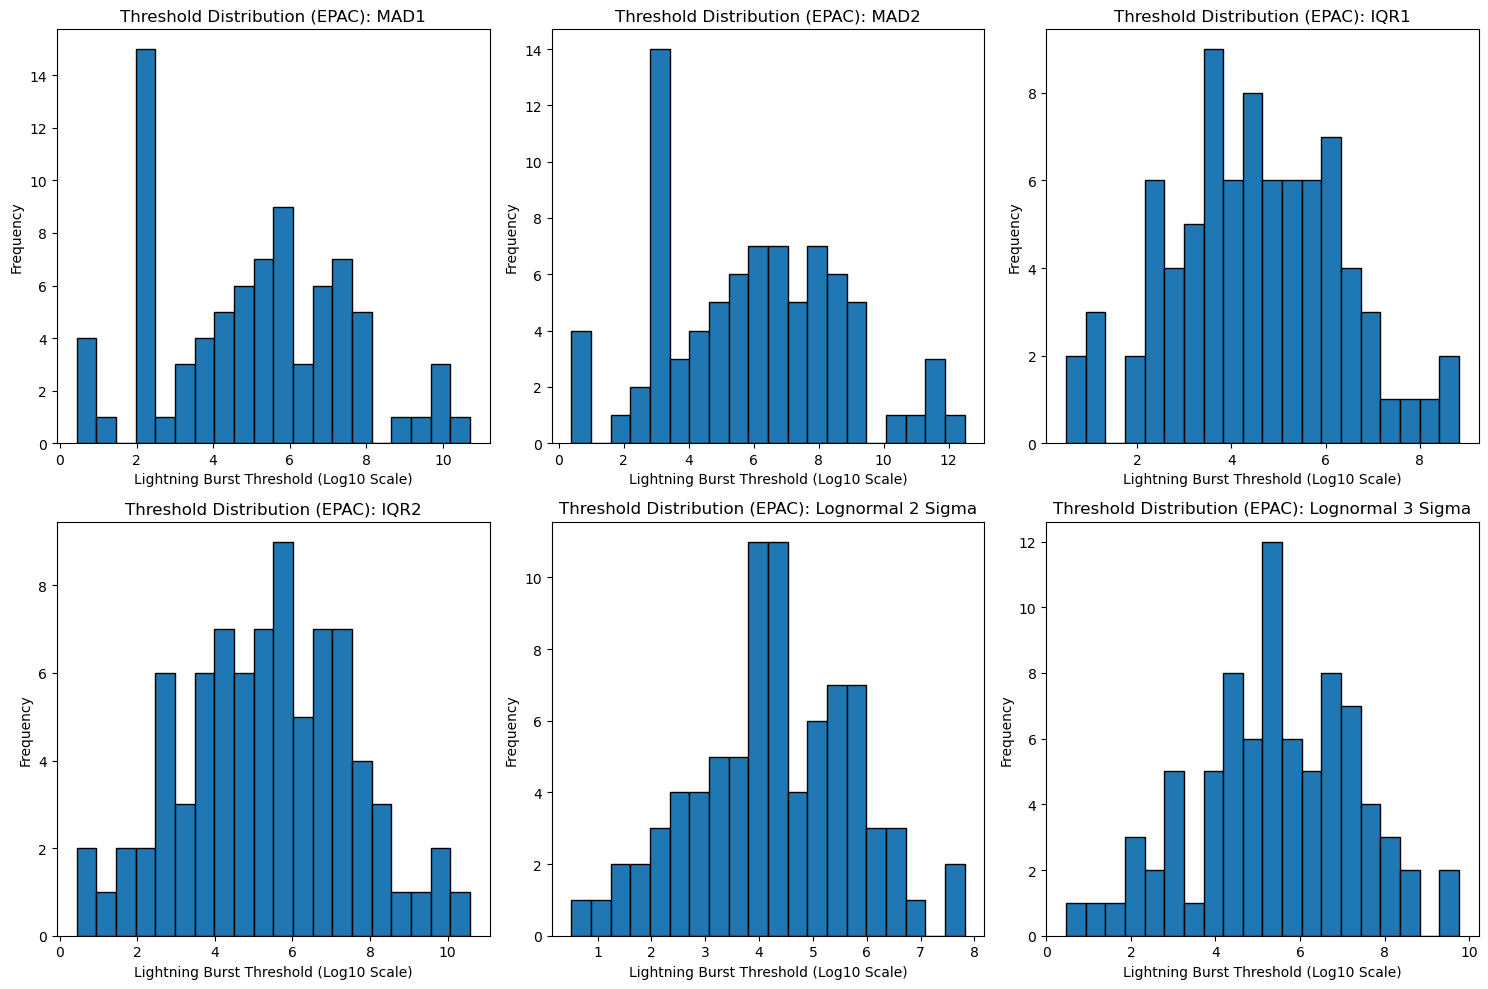

In [40]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

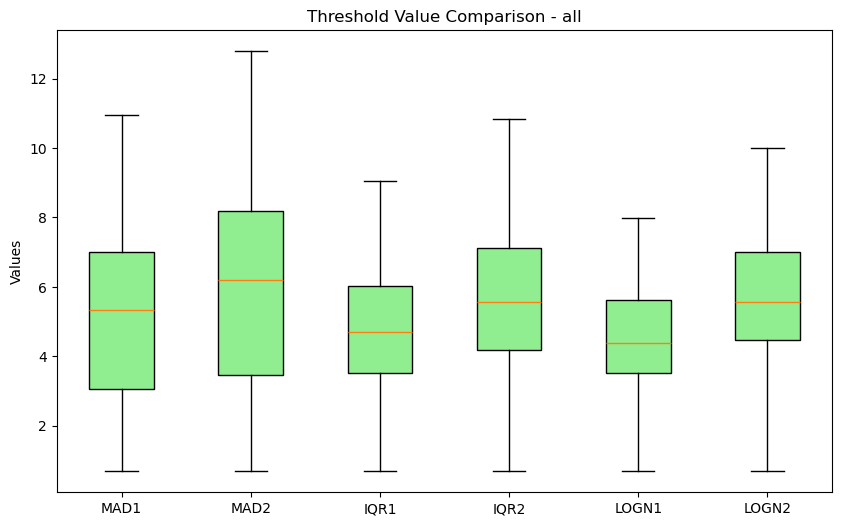

In [41]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_tc_summary, "all", ax=None)

Let's explore some ideas at the basin-level:

ideas:
- most vs least vs mean/median total bursts detected? keep 6 separate?
- different categories (max speed)
- most overlap detections and least overlap detections between the 6 standards

Plotting some of the top 5 most and least bursts by threshold type:

In [42]:
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
epac_no_bursts = epac_tc_summary[epac_tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(epac_no_bursts)} TCs of {len(epac_tc_summary)} TCs with no bursts detected across all 6 threshold methods.")

23 TCs of 82 TCs with no bursts detected across all 6 threshold methods.


In [43]:
# Top 5 most MAD1 bursts (count)
epac_tc_summary.sort_values(by="mad1_bursts", ascending=False).head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
137   EPAC_15_3     Carlos           18           16        2.720473   
189  EPAC_18_16     Norman           14            7        3.960585   
383   EPAC_13_5      Erick            7            5        2.720473   
361  EPAC_18_10     Hector            7            2        3.652740   
415   EPAC_20_8    Douglas            6            6        1.706810   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
137        3.125938           12            8        3.701302        4.453341   
189        4.548371           15            7        3.871201        4.564348   
383        3.125938            4            2        3.465736        4.158883   
361        4.163566            8            2        3.506558        4.108544   
415        1.909543            1            0        2.414157        2.844409   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
137  ...             1         4.560759         5.986970          94   
189  ...             3         4.218458         5.368579         170   
383  ...             0         4.205395         5.465820          29   
361  ...             1         3.599905         4.510039         184   
415  ...             0         2.379402         2.990767          34   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
137      19.15      17.02      12.77       8.51        7.45        1.06  
189       8.24       4.12       8.82       4.12        4.71        1.76  
383      24.14      17.24      13.79       6.90        6.90        0.00  
361       3.80       1.09       4.35       1.09        3.80        0.54  
415      17.65      17.65       2.94       0.00        5.88        0.00  

[5 rows x 21 columns]

In [44]:
# Top 5 most MAD1 bursts (prop)
epac_tc_summary.sort_values(by="mad1_prop", ascending=False).head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
104  EPAC_20_9      Elida            2            2        0.693147   
147  EPAC_12_7      Gilma            2            1        2.720473   
62   EPAC_16_4      Celia            1            1        0.693147   
383  EPAC_13_5      Erick            7            5        2.720473   
332  EPAC_16_3       Blas            5            2        2.720473   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
104        0.693147            1            1        1.504077        1.706810   
147        3.125938            0            0        4.852030        5.891751   
62         0.693147            1            0        1.386294        1.559581   
383        3.125938            4            2        3.465736        4.158883   
332        3.125938            1            1        3.198673        3.825055   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
104  ...             0         1.952556         2.431853           5   
147  ...             0         4.145911         5.367307           5   
62   ...             0         1.724574         2.124762           3   
383  ...             0         4.205395         5.465820          29   
332  ...             0         3.699117         4.749321          21   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
104      40.00      40.00      20.00      20.00        0.00         0.0  
147      40.00      20.00       0.00       0.00        0.00         0.0  
62       33.33      33.33      33.33       0.00        0.00         0.0  
383      24.14      17.24      13.79       6.90        6.90         0.0  
332      23.81       9.52       4.76       4.76        4.76         0.0  

[5 rows x 21 columns]

In [45]:
# Bottom 5 least MAD1 bursts (count)
epac_tc_summary.sort_values(by="mad1_bursts").head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
267   EPAC_16_8  Georgette            0            0        4.716742   
341   EPAC_19_1      Alvin            0            0        4.564348   
335  EPAC_15_20   Patricia            0            0        8.055574   
331   EPAC_13_7        Gil            0            0        5.967748   
318   EPAC_10_9      Frank            0            0        6.063117   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
267        5.521461            0            0        5.005986        6.084196   
341        5.257495            1            0        3.655579        4.320163   
335        9.308337            0            0        6.760811        7.964537   
331        6.884039            0            0        5.606721        6.661827   
318        7.111688            3            0        4.810531        5.763852   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
267  ...             0         4.217745         5.411758          42   
341  ...             0         3.504564         4.407590          20   
335  ...             0         5.912629         7.341839          80   
331  ...             0         4.967780         6.221871          57   
318  ...             0         4.643800         5.918609          84   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
267        0.0        0.0       0.00        0.0        4.76         0.0  
341        0.0        0.0       5.00        0.0        5.00         0.0  
335        0.0        0.0       0.00        0.0        0.00         0.0  
331        0.0        0.0       0.00        0.0        1.75         0.0  
318        0.0        0.0       3.57        0.0        3.57         0.0  

[5 rows x 21 columns]

In [46]:
# Top 5 most IQR1 bursts (count)
epac_tc_summary.sort_values(by="iqr1_bursts", ascending=False).head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
189  EPAC_18_16     Norman           14            7        3.960585   
137   EPAC_15_3     Carlos           18           16        2.720473   
29   EPAC_18_14       Lane            2            0        5.792262   
299  EPAC_15_10      Hilda            1            0        5.252624   
361  EPAC_18_10     Hector            7            2        3.652740   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
189        4.548371           15            7        3.871201        4.564348   
137        3.125938           12            8        3.701302        4.453341   
29         6.677852           11            0        5.348297        6.338798   
299        6.079303            9            2        4.317488        5.122207   
361        4.163566            8            2        3.506558        4.108544   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
189  ...             3         4.218458         5.368579         170   
137  ...             1         4.560759         5.986970          94   
29   ...             0         5.137852         6.456639         294   
299  ...             0         4.387132         5.545262         144   
361  ...             1         3.599905         4.510039         184   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
189       8.24       4.12       8.82       4.12        4.71        1.76  
137      19.15      17.02      12.77       8.51        7.45        1.06  
29        0.68       0.00       3.74       0.00        4.76        0.00  
299       0.69       0.00       6.25       1.39        5.56        0.00  
361       3.80       1.09       4.35       1.09        3.80        0.54  

[5 rows x 21 columns]

In [47]:
# Top 5 most IQR1 bursts (prop)
epac_tc_summary.sort_values(by="iqr1_prop", ascending=False).head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
62   EPAC_16_4      Celia            1            1        0.693147   
104  EPAC_20_9      Elida            2            2        0.693147   
442  EPAC_14_9     Iselle            2            2        2.720473   
176  EPAC_11_1     Adrian            1            0        2.720473   
383  EPAC_13_5      Erick            7            5        2.720473   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
62         0.693147            1            0        1.386294        1.559581   
104        0.693147            1            1        1.504077        1.706810   
442        3.125938            3            2        2.484907        2.831480   
176        3.125938            7            6        2.079442        2.426015   
383        3.125938            4            2        3.465736        4.158883   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
62   ...             0         1.724574         2.124762           3   
104  ...             0         1.952556         2.431853           5   
442  ...             0         3.230223         4.075360          19   
176  ...             0         2.502932         3.150601          49   
383  ...             0         4.205395         5.465820          29   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
62       33.33      33.33      33.33       0.00        0.00         0.0  
104      40.00      40.00      20.00      20.00        0.00         0.0  
442      10.53      10.53      15.79      10.53       10.53         0.0  
176       2.04       0.00      14.29      12.24        8.16         0.0  
383      24.14      17.24      13.79       6.90        6.90         0.0  

[5 rows x 21 columns]

In [48]:
# Bottom 5 least IQR1 bursts
epac_tc_summary.sort_values(by="iqr1_bursts").head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
335  EPAC_15_20   Patricia            0            0        8.055574   
211   EPAC_10_4      Celia            0            0        6.704246   
213   EPAC_16_7      Frank            0            0        7.355006   
216  EPAC_12_12       Lane            0            0        2.249341   
218  EPAC_13_17    Raymond            0            0        9.177017   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
335        9.308337            0            0        6.760811        7.964537   
211        7.893830            0            0        5.172376        6.190817   
213        8.485888            0            0        6.034524        7.129400   
216        2.537023            0            0        1.504077        1.706810   
218       10.735162            0            0        7.645637        9.210472   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
335  ...             0         5.912629         7.341839          80   
211  ...             0         4.679426         5.944917          93   
213  ...             0         5.904155         7.421015          66   
216  ...             0         1.591296         1.889963           5   
218  ...             0         6.767766         8.604347         227   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
335        0.0        0.0        0.0        0.0        0.00         0.0  
211        0.0        0.0        0.0        0.0        2.15         0.0  
213        0.0        0.0        0.0        0.0        0.00         0.0  
216        0.0        0.0        0.0        0.0        0.00         0.0  
218        0.0        0.0        0.0        0.0        0.88         0.0  

[5 rows x 21 columns]

In [49]:
# Top 5 most LOGN two sigma bursts (count)
epac_tc_summary.sort_values(by="logn1_bursts", ascending=False).head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
29   EPAC_18_14       Lane            2            0        5.792262   
189  EPAC_18_16     Norman           14            7        3.960585   
299  EPAC_15_10      Hilda            1            0        5.252624   
137   EPAC_15_3     Carlos           18           16        2.720473   
361  EPAC_18_10     Hector            7            2        3.652740   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
29         6.677852           11            0        5.348297        6.338798   
189        4.548371           15            7        3.871201        4.564348   
299        6.079303            9            2        4.317488        5.122207   
137        3.125938           12            8        3.701302        4.453341   
361        4.163566            8            2        3.506558        4.108544   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
29   ...             0         5.137852         6.456639         294   
189  ...             3         4.218458         5.368579         170   
299  ...             0         4.387132         5.545262         144   
137  ...             1         4.560759         5.986970          94   
361  ...             1         3.599905         4.510039         184   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
29        0.68       0.00       3.74       0.00        4.76        0.00  
189       8.24       4.12       8.82       4.12        4.71        1.76  
299       0.69       0.00       6.25       1.39        5.56        0.00  
137      19.15      17.02      12.77       8.51        7.45        1.06  
361       3.80       1.09       4.35       1.09        3.80        0.54  

[5 rows x 21 columns]

In [50]:
# Top 5 most LOGN two sigma bursts (prop)
epac_tc_summary.sort_values(by="logn1_prop", ascending=False).head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
322  EPAC_19_11   Juliette            2            1        3.439678   
442   EPAC_14_9     Iselle            2            2        2.720473   
176   EPAC_11_1     Adrian            1            0        2.720473   
284   EPAC_12_4     Daniel            1            1        2.720473   
137   EPAC_15_3     Carlos           18           16        2.720473   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
322        3.988984            2            2        2.890372        3.439678   
442        3.125938            3            2        2.484907        2.831480   
176        3.125938            7            6        2.079442        2.426015   
284        3.125938            1            0        3.701302        4.453341   
137        3.125938           12            8        3.701302        4.453341   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
322  ...             0         3.682064         4.744758          18   
442  ...             0         3.230223         4.075360          19   
176  ...             0         2.502932         3.150601          49   
284  ...             0         3.469091         4.443309          13   
137  ...             1         4.560759         5.986970          94   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
322      11.11       5.56      11.11      11.11       11.11        0.00  
442      10.53      10.53      15.79      10.53       10.53        0.00  
176       2.04       0.00      14.29      12.24        8.16        0.00  
284       7.69       7.69       7.69       0.00        7.69        0.00  
137      19.15      17.02      12.77       8.51        7.45        1.06  

[5 rows x 21 columns]

In [51]:
# Bottom 5 least LOGN 2 sigma bursts - these all don't have any bursts across all 6
epac_tc_summary.sort_values(by="logn1_bursts").head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
147   EPAC_12_7      Gilma            2            1        2.720473   
247  EPAC_18_24      Willa            0            0        7.815367   
43    EPAC_11_3     Calvin            0            0        7.639035   
216  EPAC_12_12       Lane            0            0        2.249341   
264  EPAC_11_11      Irwin            0            0       10.962409   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
147        3.125938            0            0        4.852030        5.891751   
247        8.880474            0            0        6.695107        7.732649   
43         8.826200            0            0        6.308359        7.398971   
216        2.537023            0            0        1.504077        1.706810   
264       12.785568            0            0        9.045240       10.829707   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
147  ...             0         4.145911         5.367307           5   
247  ...             0         6.079379         7.327221          88   
43   ...             0         5.590864         6.955645          29   
216  ...             0         1.591296         1.889963           5   
264  ...             0         7.906256         9.996606          48   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
147       40.0       20.0        0.0        0.0         0.0         0.0  
247        0.0        0.0        0.0        0.0         0.0         0.0  
43         0.0        0.0        0.0        0.0         0.0         0.0  
216        0.0        0.0        0.0        0.0         0.0         0.0  
264        0.0        0.0        0.0        0.0         0.0         0.0  

[5 rows x 21 columns]

look at categories

look at threshold overlap - how to quantify?

We then create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [52]:
# Group the data into weak and strong category datasets using function
# Note that this is grouping only the data used in the analysis (excluding less than 40 knots)
epac_weak0_lightning, epac_weak1_lightning, epac_strong_lightning = group_bins_category(epac_bursts)

3850 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
1561 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
1398 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


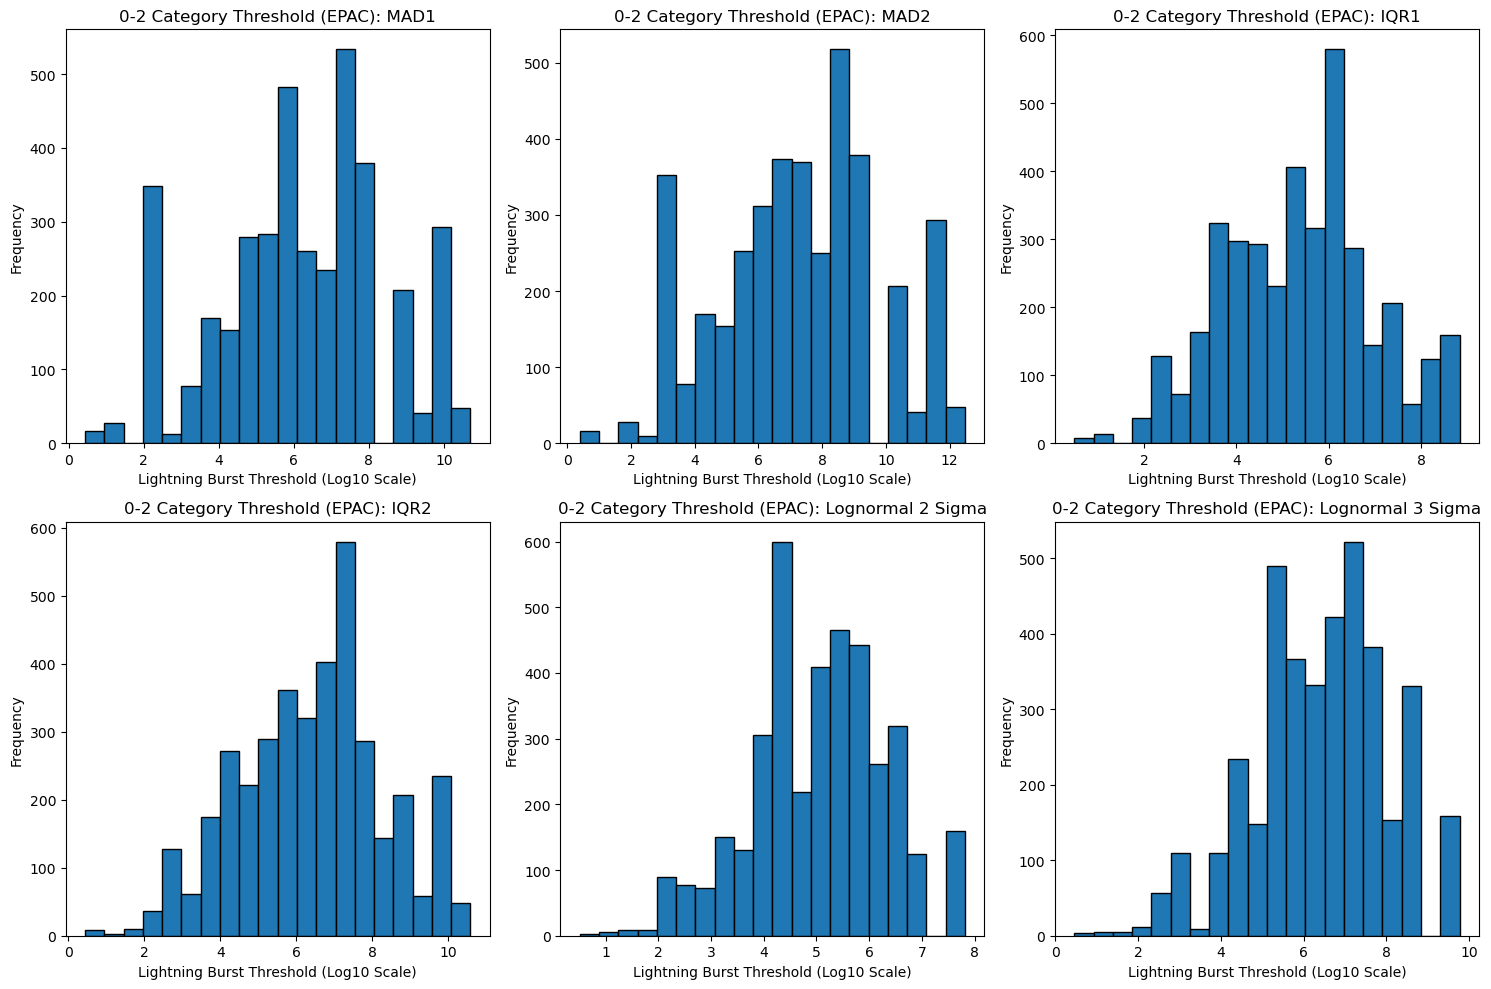

In [53]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

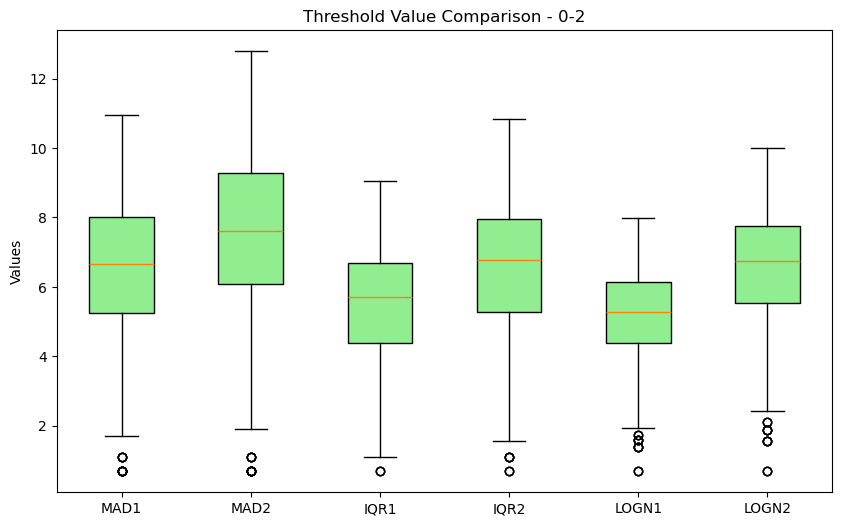

In [54]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_weak0_lightning, "0-2", ax=None)

In [135]:
# Get mean and 2 standard dev - 0-2 categories
epac_weak0_summary = create_basin_summary(epac_weak0_lightning, "0-2", "EPAC")
epac_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           82           3850              2.13   
1  12.785568           52           3850              1.35   
2   9.045240          119           3850              3.09   
3  10.829707           40           3850              1.04   
4   7.998327          141           3850              3.66   
5   9.996606            6           3850              0.16   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                   10.873827   
1                                   12.665256   
2                                    8.796140   
3                                   10.519485   
4                                    7.773955   
5                                    9.804544   

   Basin-Category Threshold (Median-Based) 2 SD  
0                                     11.014461  
1                                     12.700975  
2                                      8.907842  
3                                     10.635373  
4                                      7.825864  
5                                      9.959551

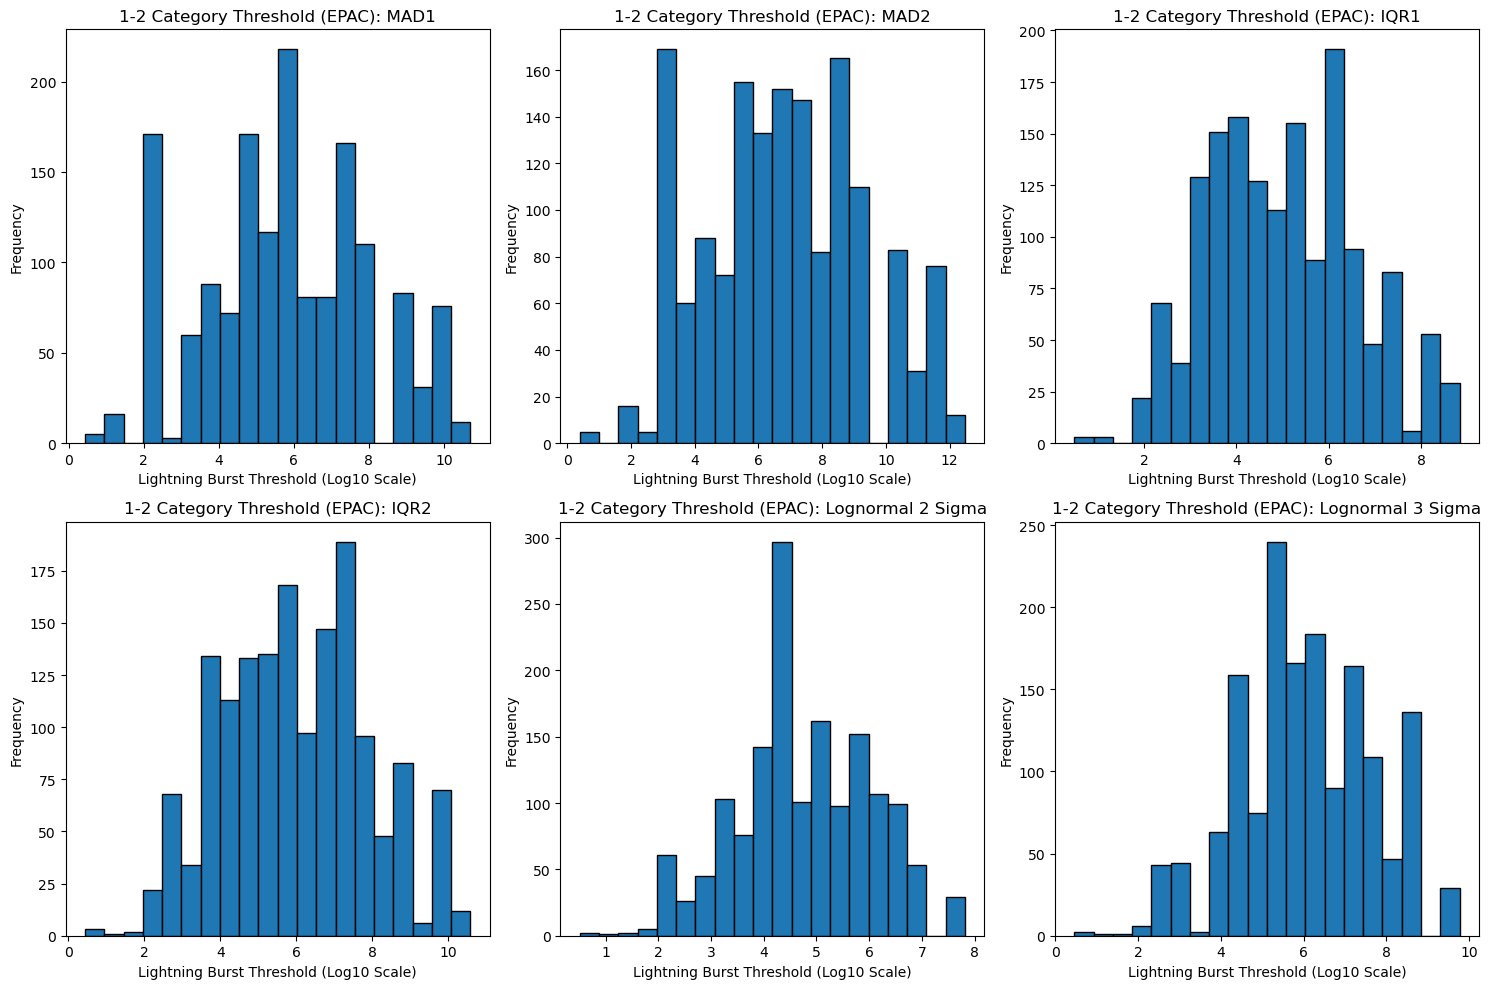

In [56]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak1_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

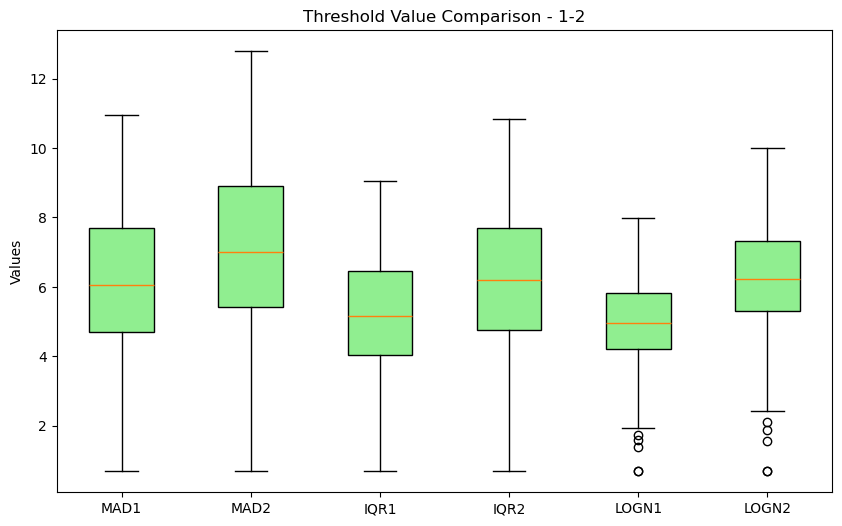

In [57]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_weak1_lightning, "1-2", ax=None)

In [146]:
# Get mean and 2 standard dev - 1-2 categories
epac_weak1_summary = create_basin_summary(epac_weak1_lightning, "1-2", "EPAC")
epac_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           34           1561              2.18   
1  12.785568           25           1561              1.60   
2   9.045240           42           1561              2.69   
3  10.829707           15           1561              0.96   
4   7.998327           51           1561              3.27   
5   9.996606            2           1561              0.13   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                   10.451083   
1                                   12.192618   
2                                    8.423303   
3                                   10.095269   
4                                    7.443267   
5                                    9.410440   

   Basin-Category Threshold (Median-Based) 2 SD  
0                                     10.394819  
1                                     12.091953  
2                                      8.349279  
3                                     10.034941  
4                                      7.479467  
5                                      9.405154

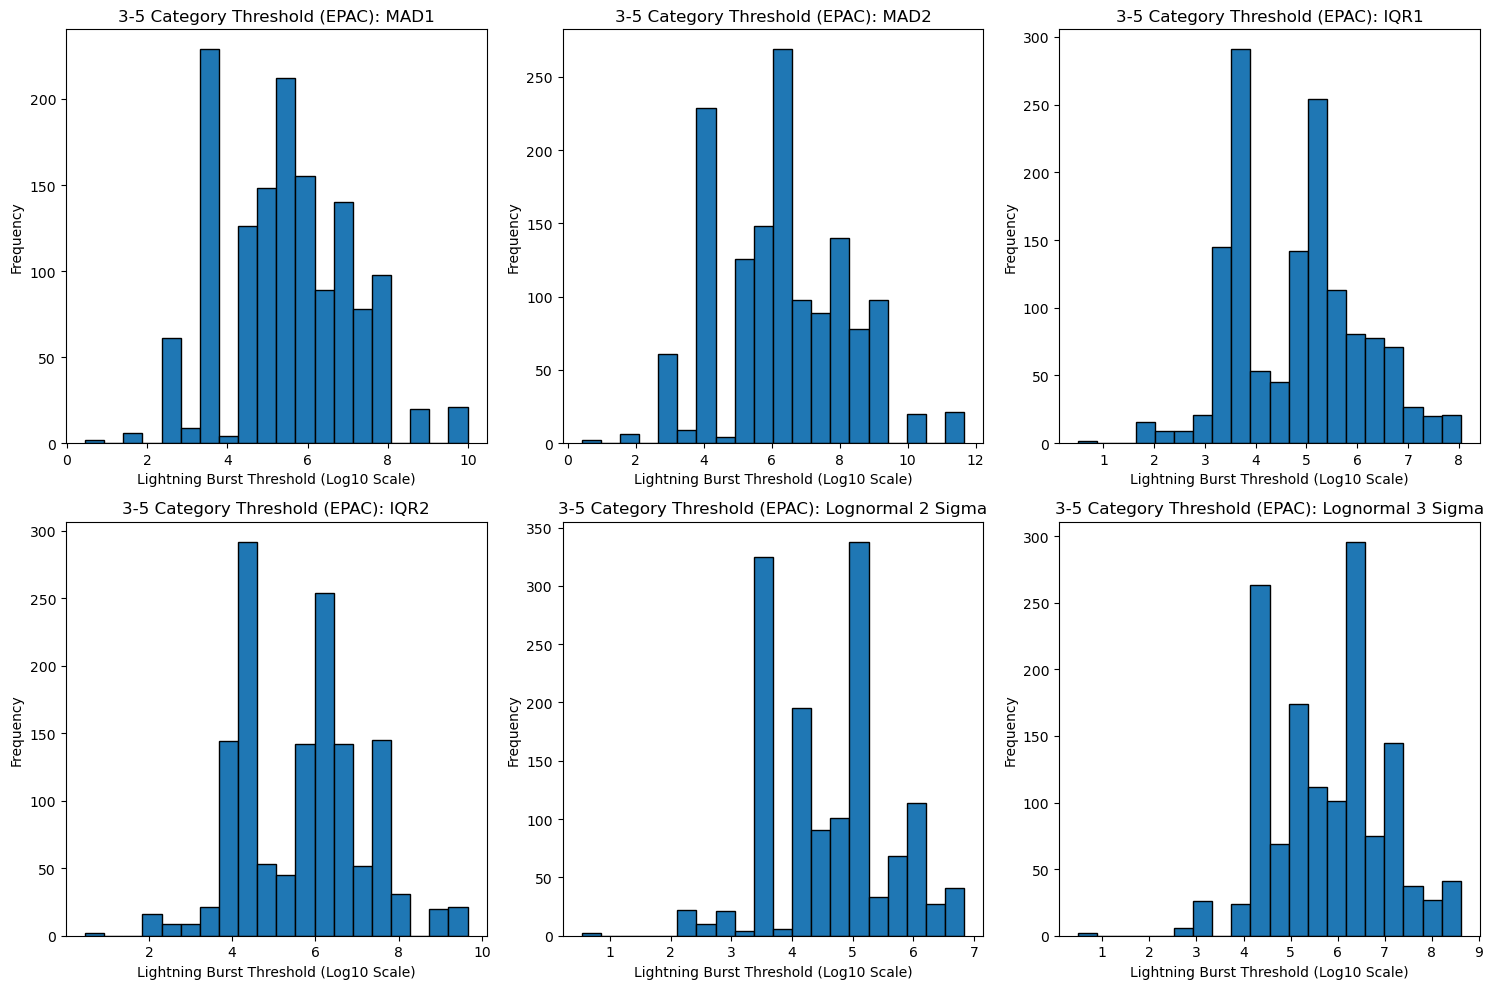

In [59]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_strong_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

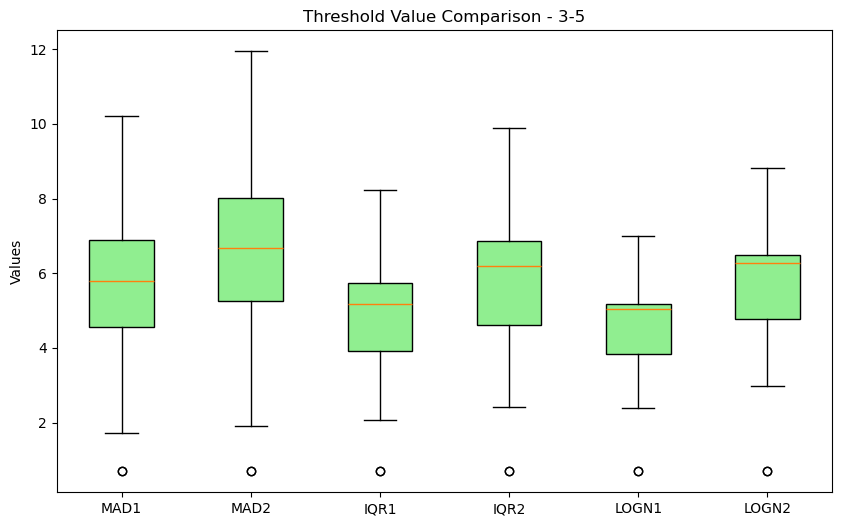

In [60]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_strong_lightning, "3-5", ax=None)

In [147]:
# Get mean and 2 standard dev - 3-5 categories
epac_strong_summary = create_basin_summary(epac_strong_lightning, "3-5", "EPAC")
epac_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.223271           11           1398              0.79   
1  11.946037            1           1398              0.07   
2   8.230524           13           1398              0.93   
3   9.885795            0           1398              0.00   
4   6.999298           16           1398              1.14   
5   8.822181            0           1398              0.00   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                    8.990233   
1                                   10.418769   
2                                    7.481199   
3                                    8.859763   
4                                    6.727951   
5                                    8.417509   

   Basin-Category Threshold (Median-Based) 2 SD  
0                                      9.062898  
1                                     10.492969  
2                                      7.663448  
3                                      9.152255  
4                                      7.005167  
5                                      8.738997

Apply the basin-category thresholds (mean and median based) to the basin by weak/strong category groupings. 

In [62]:
epac_weak0_summary, epac_weak0_bursts_mean, epac_weak0_summary_mean, epac_weak0_bursts_median, epac_weak0_summary_median = summarize_threshold_eval(epac_weak0_summary, epac_weak0_lightning)
epac_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.962409                              10.873827   
1  12.785568                              12.665256   
2   9.045240                               8.796140   
3  10.829707                              10.519485   
4   7.998327                               7.773955   
5   9.996606                               9.804544   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                11.014461           82           3850   
1                                12.700975           52           3850   
2                                 8.907842          119           3850   
3                                10.635373           40           3850   
4                                 7.825864          141           3850   
5                                 9.959551            6           3850   

   Burst Percentage  Mean-Based Threshold Bursts  \
0              2.13                            0   
1              1.35                            0   
2              3.09                            0   
3              1.04                            0   
4              3.66                            0   
5              0.16                            0   

   Mean-Based Threshold Burst Percentage  Median-Based Threshold Bursts  \
0                                    0.0                              0   
1                                    0.0                              0   
2                                    0.0                              0   
3                                    0.0                              0   
4                                    0.0                              0   
5                                    0.0                              0   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

We see that these basin-category thresholds are very high and end up flagging 0 timebins as bursts. Let's do the same for the stronger categories.

In [63]:
epac_weak1_summary, epac_weak1_bursts_mean, epac_weak1_summary_mean, epac_weak1_bursts_median, epac_weak1_summary_median = summarize_threshold_eval(epac_weak1_summary, epac_weak1_lightning)
epac_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.962409                              10.451083   
1  12.785568                              12.192618   
2   9.045240                               8.423303   
3  10.829707                              10.095269   
4   7.998327                               7.443267   
5   9.996606                               9.410440   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                10.394819           34           1561   
1                                12.091953           25           1561   
2                                 8.349279           42           1561   
3                                10.034941           15           1561   
4                                 7.479467           51           1561   
5                                 9.405154            2           1561   

   Burst Percentage  Mean-Based Threshold Bursts  \
0              2.18                            0   
1              1.60                            0   
2              2.69                            0   
3              0.96                            0   
4              3.27                            0   
5              0.13                            0   

   Mean-Based Threshold Burst Percentage  Median-Based Threshold Bursts  \
0                                    0.0                              0   
1                                    0.0                              0   
2                                    0.0                              0   
3                                    0.0                              0   
4                                    0.0                              0   
5                                    0.0                              0   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

Let's do the same for the 3-5 category group.

In [64]:
epac_strong_summary, epac_strong_bursts_mean, epac_strong_summary_mean, epac_strong_bursts_median,  epac_strong_summary_median = summarize_threshold_eval(epac_strong_summary, epac_strong_lightning)
epac_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.223271                               8.990233   
1  11.946037                              10.418769   
2   8.230524                               7.481199   
3   9.885795                               8.859763   
4   6.999298                               6.727951   
5   8.822181                               8.417509   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                 9.062898           11           1398   
1                                10.492969            1           1398   
2                                 7.663448           13           1398   
3                                 9.152255            0           1398   
4                                 7.005167           16           1398   
5                                 8.738997            0           1398   

   Burst Percentage  Mean-Based Threshold Bursts  \
0              0.79                            0   
1              0.07                            0   
2              0.93                            0   
3              0.00                            0   
4              1.14                            0   
5              0.00                            0   

   Mean-Based Threshold Burst Percentage  Median-Based Threshold Bursts  \
0                                    0.0                              0   
1                                    0.0                              0   
2                                    0.0                              0   
3                                    0.0                              0   
4                                    0.0                              0   
5                                    0.0                              0   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

Once again, we see no bursts using the basin-category thresholds (2 standard deviations from mean/median).

Let's look at the distribution of "effective" thresholds - ones where at least one timebin was flagged as a burst.

In [65]:
burst_columns = ['burst_iqr1', 'burst_iqr2', 'burst_mad1', 'burst_mad2', 'burst_logn1', 'burst_logn2']
# Filter data to only those with at least one "True" value in the burst columns, grouped by storm code
# Do not include thresholds that don't flag a burst
mask = epac_bursts.groupby("storm_code")[burst_columns].transform(lambda group: group.any(axis=0))

# Filter rows to where at least one burst col has True value
epac_bursts_effective = epac_bursts[epac_bursts[burst_columns].any(axis=1)].copy()

# Set threshold values to NaN where burst columns are False
for burst_col, threshold_col in zip(burst_columns, threshold_cols):
    epac_bursts_effective[threshold_col] = epac_bursts_effective[threshold_col].where(epac_bursts_effective[burst_col], np.nan)

epac_storm_codes_effective = epac_bursts_effective["storm_code"].unique()
epac_tc_summary_effective = epac_tc_summary[epac_tc_summary["storm_code"].isin(epac_storm_codes_effective)]

epac_bursts_effective.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
10077 2010-06-22 07:30:00  EPAC_10_4              122  2010      6   22     7   
10097 2010-06-24 07:30:00  EPAC_10_4              135  2010      6   24     7   
10148 2010-08-24 03:00:00  EPAC_10_9              136  2010      8   24     3   
10155 2010-08-24 12:30:00  EPAC_10_9              138  2010      8   24    12   
10192 2010-08-25 14:30:00  EPAC_10_9              194  2010      8   25    14   

       minute   lat    lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
10077      30  11.6 -104.3  ...             NaN             NaN      False   
10097      30  12.3 -112.2  ...             NaN             NaN      False   
10148       0  15.2 -100.5  ...             NaN             NaN      False   
10155      30  15.4 -101.1  ...             NaN             NaN      False   
10192      30  16.5 -104.6  ...             NaN             NaN      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
10077       False            NaN             NaN         True        False   
10097       False            NaN             NaN         True        False   
10148       False       6.063117             NaN         True        False   
10155       False       6.063117             NaN         True        False   
10192       False       6.063117             NaN         True        False   

      logn1_threshold logn2_threshold  
10077        4.679426             NaN  
10097        4.679426             NaN  
10148        4.643800             NaN  
10155        4.643800             NaN  
10192        4.643800             NaN  

[5 rows x 34 columns]

In [66]:
print(f"{len(epac_storm_codes_effective)} TCs of {len(epac_storm_codes)} EPAC TCs after filtering for bursts of any type")

59 TCs of 82 EPAC TCs after filtering for bursts of any type


In [67]:
epac_effective_summary = create_basin_summary(epac_bursts_effective, "all", "EPAC")
epac_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            all      mad1  4.570221  1.662344  4.270455  0.693147   
1  EPAC            all      mad2  3.907350  1.387424  3.125938  0.693147   
2  EPAC            all      iqr1  3.643620  0.960844  3.701302  1.386294   
3  EPAC            all      iqr2  3.946447  0.905727  4.453341  1.559581   
4  EPAC            all     logn1  4.624058  1.029793  4.560759  2.343750   
5  EPAC            all     logn2  5.006578  0.901697  5.368579  3.436726   

        Max  Basin-Category Threshold (Mean-Based)  \
0  8.258979                               7.894910   
1  8.132119                               6.682197   
2  6.191953                               5.565309   
3  5.891751                               5.757900   
4  6.767766                               6.683645   
5  5.986970                               6.809973   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                 7.595143           93            204   
1                                 5.900785           53            204   
2                                 5.622991          132            204   
3                                 6.264794           40            204   
4                                 6.620345          157            204   
5                                 7.171973            6            204   

   Burst Percentage  
0             45.59  
1             25.98  
2             64.71  
3             19.61  
4             76.96  
5              2.94

In this context, the burst percentage represents how much of the total number of flagged bursts (across all threshold types) the particular threshold type flagged. For example, 204 timebins means there are 204 total bursts across all TCs in the EPAC basin and across all 6 threshold types. Of these, 64.71% were flagged by the MAD method, specifically the first threshold value (the lower one). It can be noted that the burst percentages do not add up to 100% due to the fact that multiple thresholds will flag the same burst.

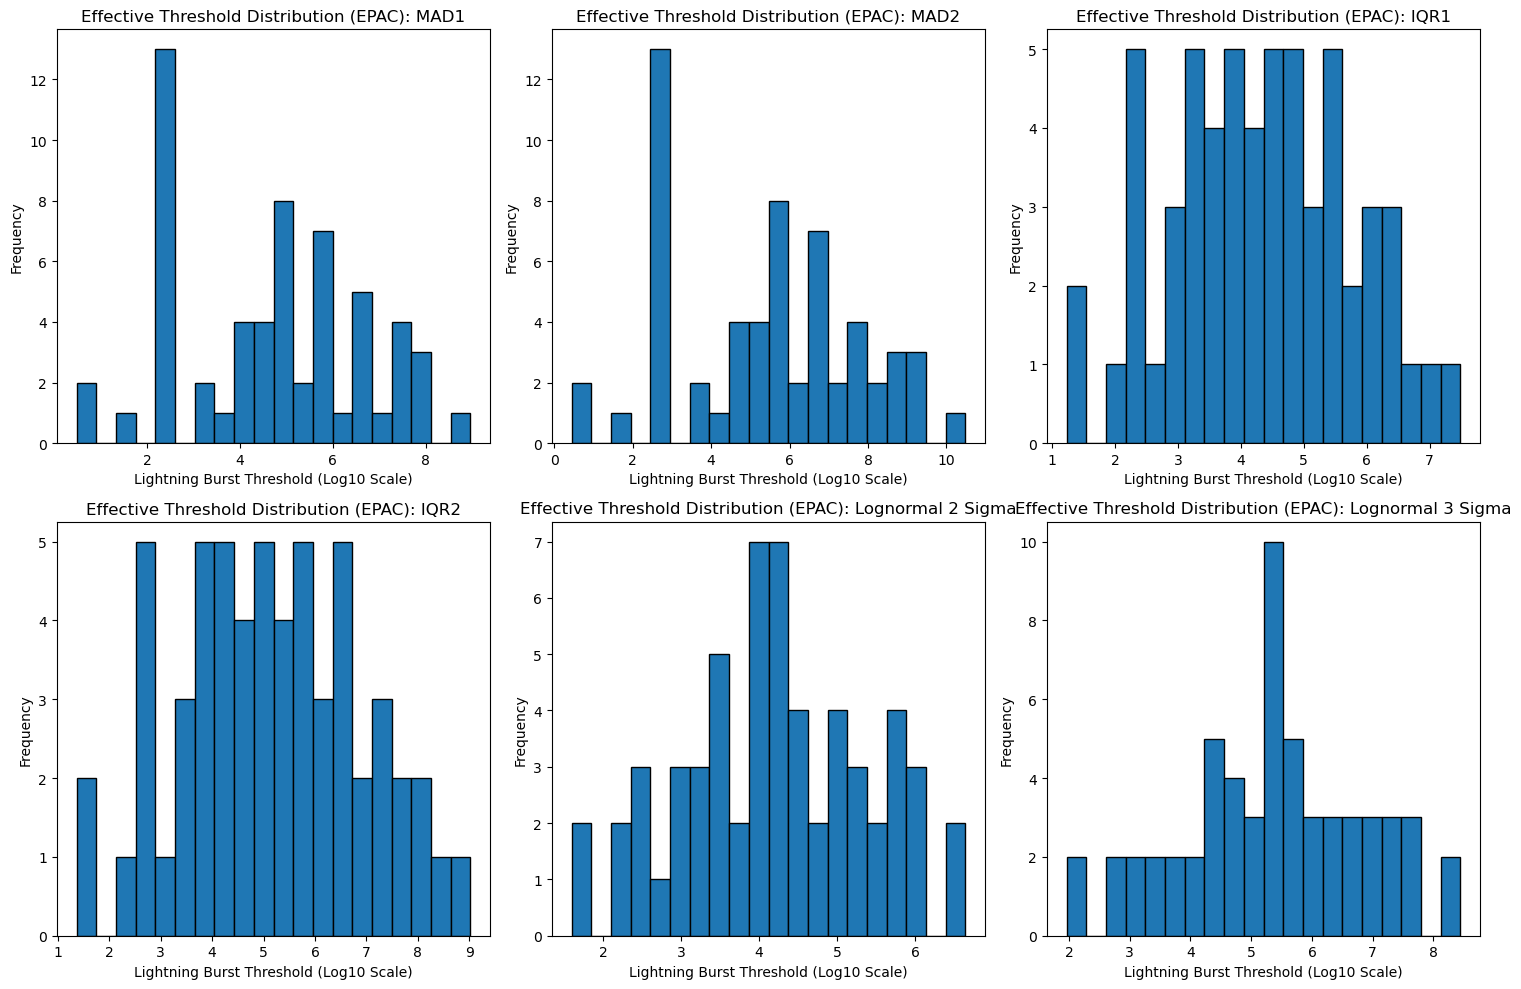

In [ ]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_tc_summary_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [69]:
# Group the data into weak and strong category datasets using function
epac_weak0_effective_lightning, epac_weak1_effective_lightning, epac_strong_effective_lightning = group_bins_category(epac_bursts_effective)

181 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
68 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
23 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


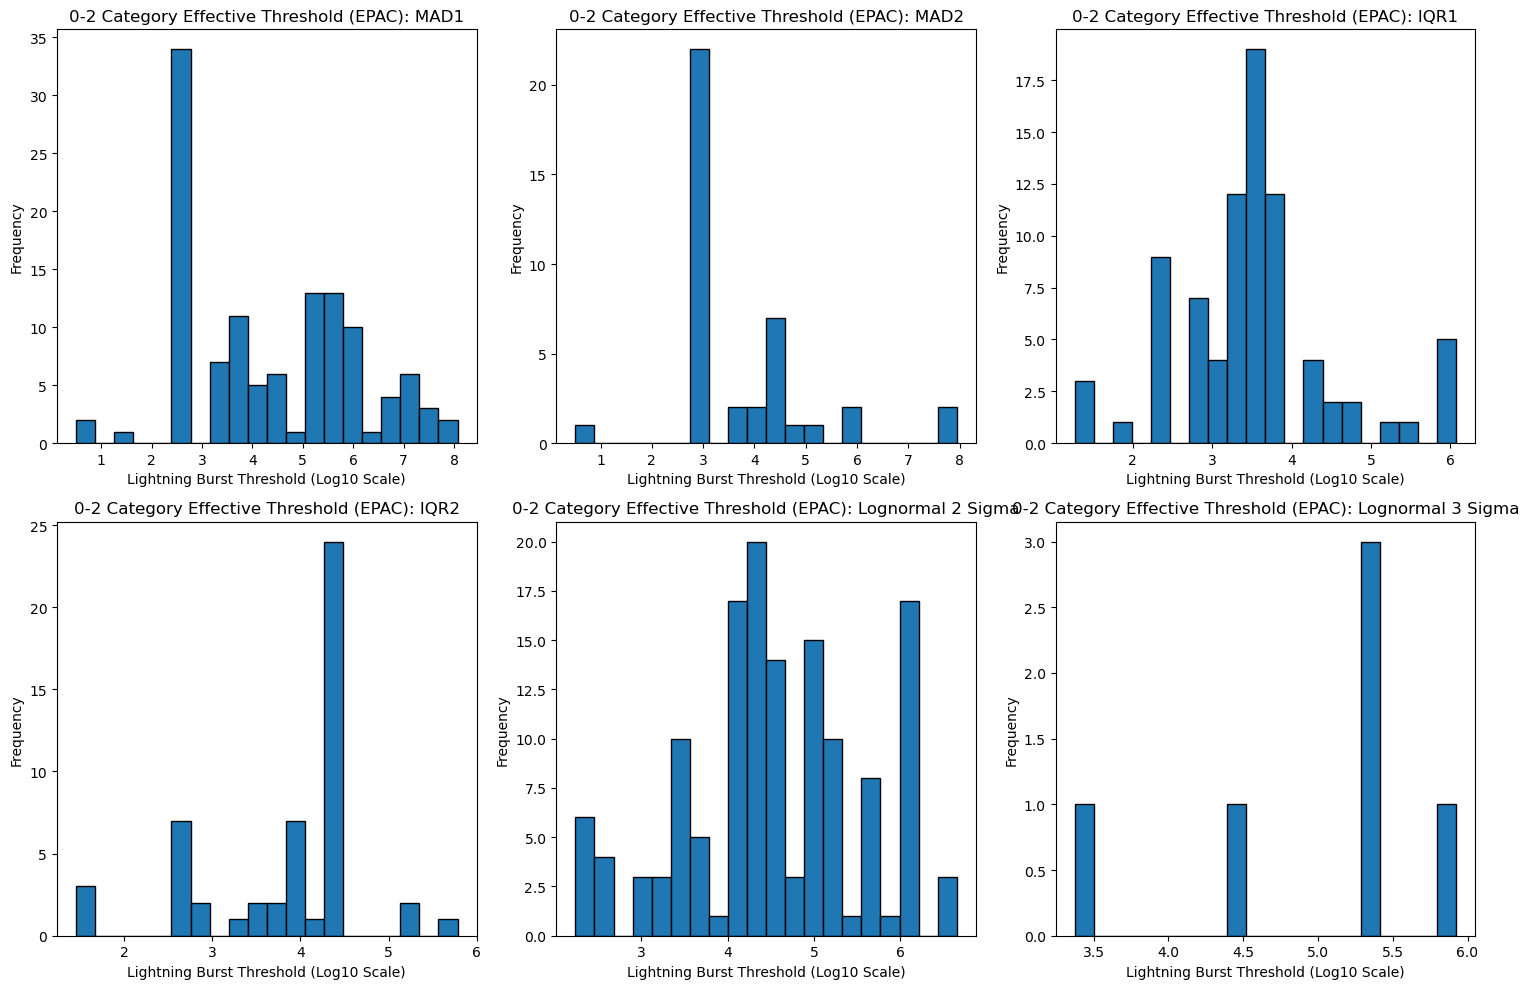

In [70]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak0_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [119]:
# Get mean and 2 standard dev - 0-2 categories
epac_weak0_effective_summary = create_basin_summary(epac_weak0_effective_lightning, "0-2", "EPAC")
epac_weak0_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  4.557847  1.722731  4.382027  0.693147   
1  EPAC            0-2      mad2  3.907350  1.387424  3.125938  0.693147   
2  EPAC            0-2      iqr1  3.642842  0.994310  3.701302  1.386294   
3  EPAC            0-2      iqr2  3.967640  0.901196  4.453341  1.559581   
4  EPAC            0-2     logn1  4.649019  1.041497  4.560759  2.343750   
5  EPAC            0-2     logn2  5.006578  0.901697  5.368579  3.436726   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.258979           82            181             45.30   
1  8.132119           52            181             28.73   
2  6.191953          119            181             65.75   
3  5.891751           40            181             22.10   
4  6.767766          141            181             77.90   
5  5.986970            6            181              3.31   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                    8.003309   
1                                    6.682197   
2                                    5.631462   
3                                    5.770032   
4                                    6.732013   
5                                    6.809973   

   Basin-Category Threshold (Median-Based) 2 SD  
0                                      7.827488  
1                                      5.900785  
2                                      5.689922  
3                                      6.255733  
4                                      6.643753  
5                                      7.171973

In [120]:
# Get mean and 1.5 standard dev - 0-2 categories
epac_weak0_effective_summary_1_5 = create_basin_summary(epac_weak0_effective_lightning, "0-2", "EPAC", std_dev=1.5)
epac_weak0_effective_summary_1_5

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  4.557847  1.722731  4.382027  0.693147   
1  EPAC            0-2      mad2  3.907350  1.387424  3.125938  0.693147   
2  EPAC            0-2      iqr1  3.642842  0.994310  3.701302  1.386294   
3  EPAC            0-2      iqr2  3.967640  0.901196  4.453341  1.559581   
4  EPAC            0-2     logn1  4.649019  1.041497  4.560759  2.343750   
5  EPAC            0-2     logn2  5.006578  0.901697  5.368579  3.436726   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.258979           82            181             45.30   
1  8.132119           52            181             28.73   
2  6.191953          119            181             65.75   
3  5.891751           40            181             22.10   
4  6.767766          141            181             77.90   
5  5.986970            6            181              3.31   

   Basin-Category Threshold (Mean-Based) 1.5 SD  \
0                                      7.141943   
1                                      5.988485   
2                                      5.134307   
3                                      5.319434   
4                                      6.211264   
5                                      6.359124   

   Basin-Category Threshold (Median-Based) 1.5 SD  
0                                        6.966123  
1                                        5.207073  
2                                        5.192767  
3                                        5.805135  
4                                        6.123004  
5                                        6.721124

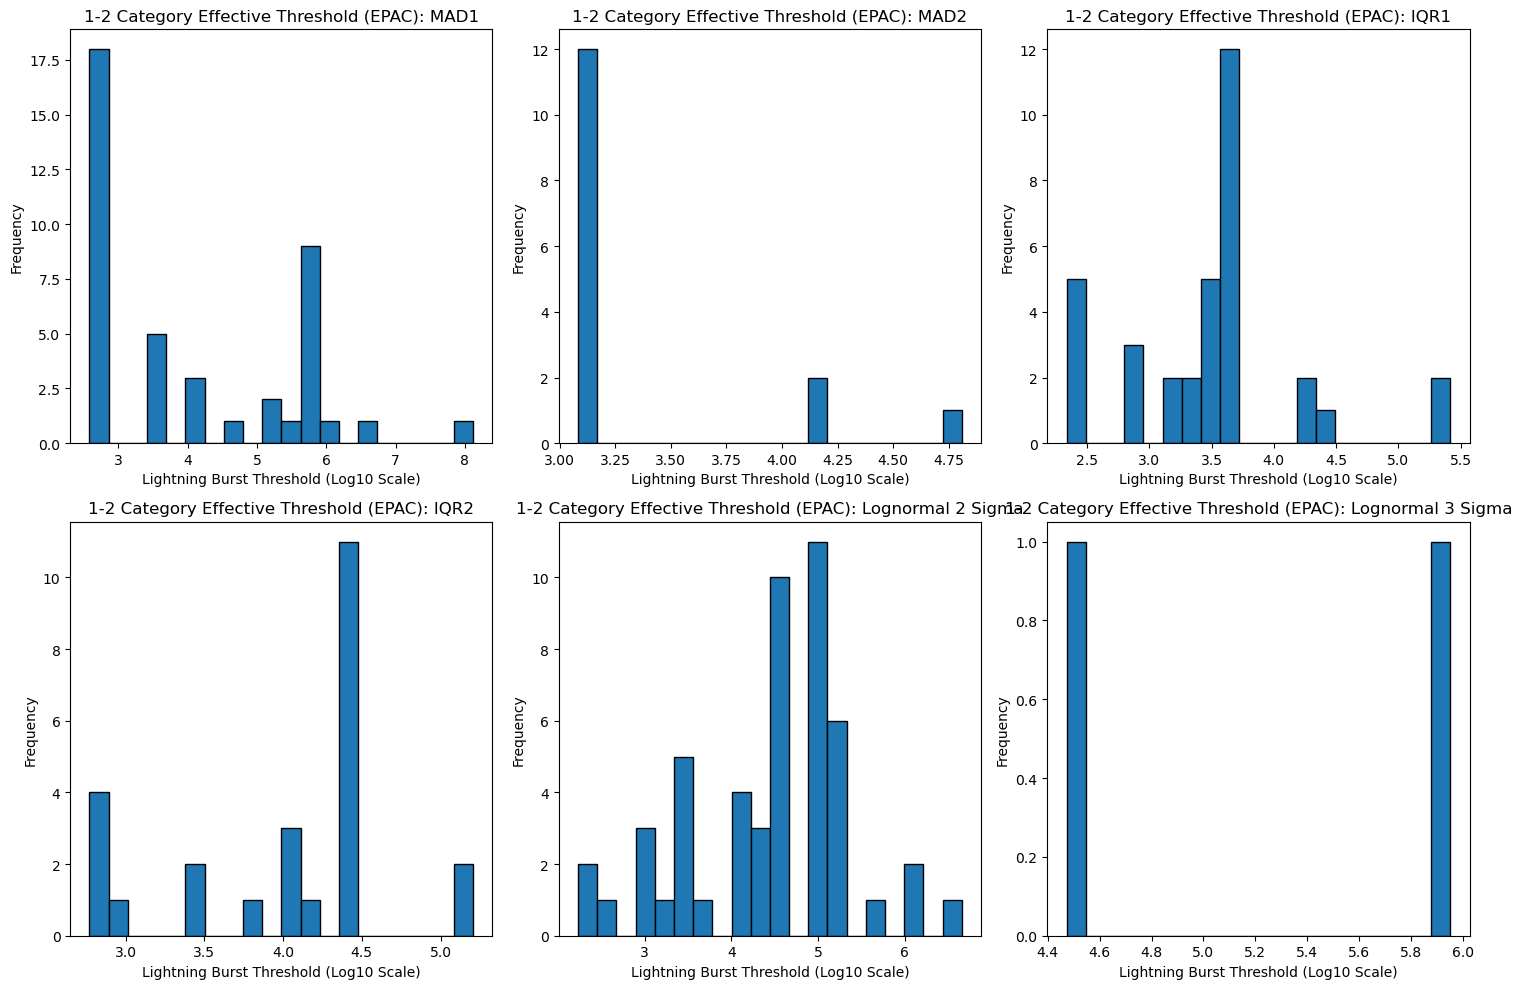

In [72]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak1_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [144]:
# Get mean and 2 standard dev - 1-2 categories
epac_weak1_effective_summary = create_basin_summary(epac_weak1_effective_lightning, "1-2", "EPAC")
epac_weak1_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  4.162957  1.547052  3.652740  2.720473   
1  EPAC            1-2      mad2  3.379361  0.545723  3.125938  3.125938   
2  EPAC            1-2      iqr1  3.545660  0.716110  3.612965  2.414157   
3  EPAC            1-2      iqr2  4.055095  0.717920  4.453341  2.831480   
4  EPAC            1-2     logn1  4.525435  0.957033  4.560759  2.343750   
5  EPAC            1-2     logn2  5.248504  1.044348  5.248504  4.510039   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.258979           34             68             50.00   
1  4.852030           25             68             36.76   
2  5.493061           42             68             61.76   
3  5.268244           15             68             22.06   
4  6.767766           51             68             75.00   
5  5.986970            2             68              2.94   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                    7.257060   
1                                    4.470807   
2                                    4.977881   
3                                    5.490936   
4                                    6.439500   
5                                    7.337200   

   Basin-Category Threshold (Median-Based) 2 SD  
0                                      6.746844  
1                                      4.217384  
2                                      5.045186  
3                                      5.889181  
4                                      6.474824  
5                                      7.337200

In [145]:
# Get mean and 1.5 standard dev - 1-2 categories
epac_weak1_effective_summary_1_5 = create_basin_summary(epac_weak1_effective_lightning, "1-2", "EPAC", std_dev=1.5)
epac_weak1_effective_summary_1_5

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  4.162957  1.547052  3.652740  2.720473   
1  EPAC            1-2      mad2  3.379361  0.545723  3.125938  3.125938   
2  EPAC            1-2      iqr1  3.545660  0.716110  3.612965  2.414157   
3  EPAC            1-2      iqr2  4.055095  0.717920  4.453341  2.831480   
4  EPAC            1-2     logn1  4.525435  0.957033  4.560759  2.343750   
5  EPAC            1-2     logn2  5.248504  1.044348  5.248504  4.510039   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.258979           34             68             50.00   
1  4.852030           25             68             36.76   
2  5.493061           42             68             61.76   
3  5.268244           15             68             22.06   
4  6.767766           51             68             75.00   
5  5.986970            2             68              2.94   

   Basin-Category Threshold (Mean-Based) 1.5 SD  \
0                                      6.483535   
1                                      4.197946   
2                                      4.619825   
3                                      5.131976   
4                                      5.960984   
5                                      6.815026   

   Basin-Category Threshold (Median-Based) 1.5 SD  
0                                        5.973318  
1                                        3.944522  
2                                        4.687130  
3                                        5.530221  
4                                        5.996308  
5                                        6.815026

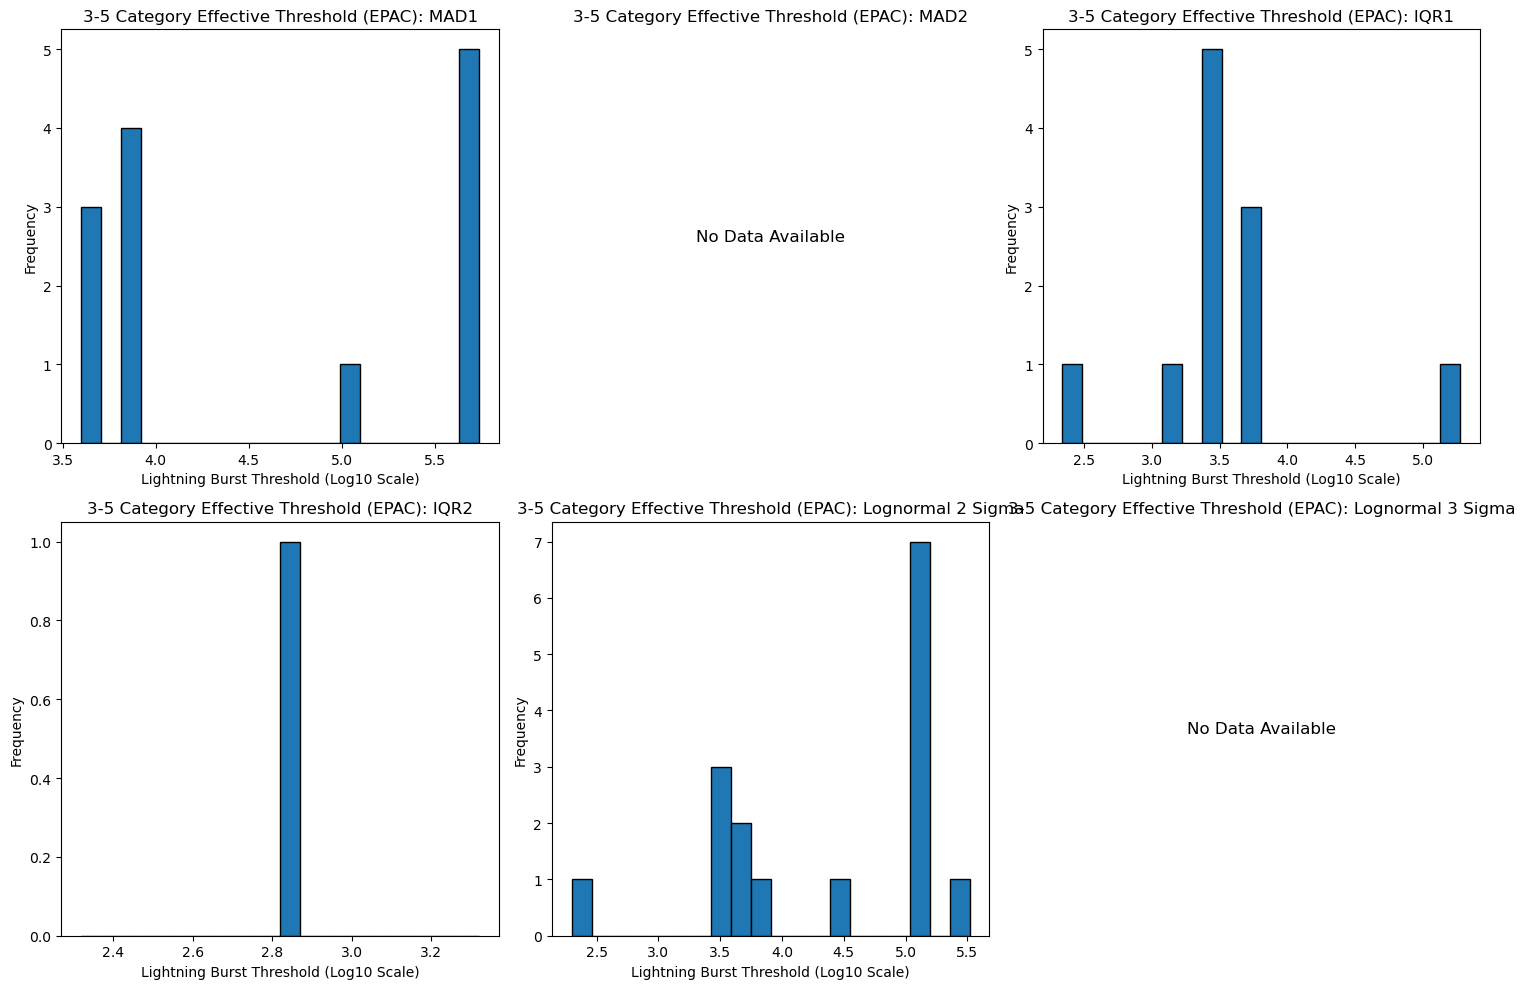

In [74]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_strong_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [108]:
# Get mean and 2 standard dev - 3-5 categories
epac_strong_effective_summary = create_basin_summary(epac_strong_effective_lightning, "3-5", "EPAC")
epac_strong_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  4.683494  0.983965  3.960585  3.652740   
1  EPAC            3-5      mad2       NaN       NaN       NaN       NaN   
2  EPAC            3-5      iqr1  3.649424  0.696790  3.524627  2.414157   
3  EPAC            3-5      iqr2  2.844409       NaN  2.844409  2.844409   
4  EPAC            3-5     logn1  4.404095  0.920568  4.816549  2.379402   
5  EPAC            3-5     logn2       NaN       NaN       NaN       NaN   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  5.792262           11             23             47.83   
1       NaN            1             23              4.35   
2  5.348297           13             23             56.52   
3  2.844409            0             23              0.00   
4  5.598135           16             23             69.57   
5       NaN            0             23              0.00   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                    6.651423   
1                                         NaN   
2                                    5.043004   
3                                         NaN   
4                                    6.245231   
5                                         NaN   

   Basin-Category Threshold (Median-Based) 2 SD  
0                                      5.928514  
1                                           NaN  
2                                      4.918208  
3                                           NaN  
4                                      6.657686  
5                                           NaN

In [107]:
# Get mean and 1.5 standard dev - 3-5 categories
epac_strong_effective_summary_1_5 = create_basin_summary(epac_strong_effective_lightning, "3-5", "EPAC", std_dev=1.5)
epac_strong_effective_summary_1_5

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  4.683494  0.983965  3.960585  3.652740   
1  EPAC            3-5      mad2       NaN       NaN       NaN       NaN   
2  EPAC            3-5      iqr1  3.649424  0.696790  3.524627  2.414157   
3  EPAC            3-5      iqr2  2.844409       NaN  2.844409  2.844409   
4  EPAC            3-5     logn1  4.404095  0.920568  4.816549  2.379402   
5  EPAC            3-5     logn2       NaN       NaN       NaN       NaN   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  5.792262           11             23             47.83   
1       NaN            1             23              4.35   
2  5.348297           13             23             56.52   
3  2.844409            0             23              0.00   
4  5.598135           16             23             69.57   
5       NaN            0             23              0.00   

   Basin-Category Threshold (Mean-Based) 1.5 SD  \
0                                      6.159441   
1                                           NaN   
2                                      4.694609   
3                                           NaN   
4                                      5.784947   
5                                           NaN   

   Basin-Category Threshold (Median-Based) 1.5 SD  
0                                        5.436531  
1                                             NaN  
2                                        4.569813  
3                                             NaN  
4                                        6.197402  
5                                             NaN

Let's apply the basin-level effective threshold.

In [ ]:
# 0-2 categories, 2 SD
epac_weak0_summary_2sd, epac_weak0_eff_bursts_mean, epac_weak0_eff_summary_mean, epac_weak0_eff_bursts_median, epac_weak0_eff_summary_median = summarize_threshold_eval(epac_weak0_summary, epac_weak0_lightning, threshold_data = epac_weak0_effective_summary, threshold_type="effective")
epac_weak0_summary_2sd = epac_weak0_summary_2sd.rename(columns={
    "Mean-Based Effective Threshold Bursts": "Mean-Based Effective Threshold Bursts 2 SD",
    "Mean-Based Effective Threshold Burst Percentage": "Mean-Based Effective Threshold Burst Percentage 2 SD",
    "Median-Based Effective Threshold Bursts": "Median-Based Effective Threshold Bursts 2 SD",
    "Median-Based Effective Threshold Burst Percentage": "Median-Based Effective Threshold Burst Percentage 2 SD"
})
epac_weak0_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           82           3850              2.13   
1  12.785568           52           3850              1.35   
2   9.045240          119           3850              3.09   
3  10.829707           40           3850              1.04   
4   7.998327          141           3850              3.66   
5   9.996606            6           3850              0.16   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                   10.873827   
1                                   12.665256   
2                                    8.796140   
3                                   10.519485   
4                                    7.773955   
5                                    9.804544   

   Basin-Category Threshold (Median-Based) 2 SD  \
0                                     11.014461   
1                                     12.700975   
2                                      8.907842   
3                                     10.635373   
4                                      7.825864   
5                                      9.959551   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           8.003309      
1                                           6.682197      
2                                           5.631462      
3                                           5.770032      
4                                           6.732013      
5                                           6.809973      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           7.827488        
1                                           5.900785        
2                                           5.689922        
3                                           6.255733        
4                                           6.643753        
5                                           7.171973        

   Mean-Based Effective Threshold Bursts 2 SD  \
0                                           0   
1                                          23   
2                                         170   
3                                         140   
4                                          18   
5                                          16   

   Mean-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.00      
1                                               0.60      
2                                               4.42      
3                                               3.64      
4                                               0.47      
5                                               0.42      

   Median-Based Effective Threshold Bursts 2 SD  \
0                                             0   
1                                           113   
2                                           157   
3                                            72   
4                                            27   
5                                             3   

   Median-Based Effective Threshold Burst Percentage 2 SD  
0                                               0.00       
1                                               2.94       
2                                               4.08       
3                                               1.87       
4                                               0.70       
5             

In [140]:
# 0-2 categories, 1.5 SD
epac_weak0_summary_1_5sd, epac_weak0_eff_bursts_mean_1_5, epac_weak0_eff_summary_mean_1_5, epac_weak0_eff_bursts_median_1_5, epac_weak0_eff_summary_median_1_5 = summarize_threshold_eval(epac_weak0_summary, epac_weak0_lightning, threshold_data = epac_weak0_effective_summary_1_5, threshold_type="effective")
epac_weak0_summary_1_5sd = epac_weak0_summary_1_5sd.rename(columns={
    "Mean-Based Effective Threshold Bursts": "Mean-Based Effective Threshold Bursts 1.5 SD",
    "Mean-Based Effective Threshold Burst Percentage": "Mean-Based Effective Threshold Burst Percentage 1.5 SD",
    "Median-Based Effective Threshold Bursts": "Median-Based Effective Threshold Bursts 1.5 SD",
    "Median-Based Effective Threshold Burst Percentage": "Median-Based Effective Threshold Burst Percentage 1.5 SD"
})
epac_weak0_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           82           3850              2.13   
1  12.785568           52           3850              1.35   
2   9.045240          119           3850              3.09   
3  10.829707           40           3850              1.04   
4   7.998327          141           3850              3.66   
5   9.996606            6           3850              0.16   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                   10.873827   
1                                   12.665256   
2                                    8.796140   
3                                   10.519485   
4                                    7.773955   
5                                    9.804544   

   Basin-Category Threshold (Median-Based) 2 SD  \
0                                     11.014461   
1                                     12.700975   
2                                      8.907842   
3                                     10.635373   
4                                      7.825864   
5                                      9.959551   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           7.141943        
1                                           5.988485        
2                                           5.134307        
3                                           5.319434        
4                                           6.211264        
5                                           6.359124        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.966123          
1                                           5.207073          
2                                           5.192767          
3                                           5.805135          
4                                           6.123004          
5                                           6.721124          

   Mean-Based Effective Threshold Bursts 1.5 SD  \
0                                             3   
1                                           103   
2                                           306   
3                                           247   
4                                            77   
5                                            56   

   Mean-Based Effective Threshold Burst Percentage 1.5 SD  \
0                                               0.08        
1                                               2.68        
2                                               7.95        
3                                               6.42        
4                                               2.00        
5                                               1.45        

   Median-Based Effective Threshold Bursts 1.5 SD  \
0                                               8   
1                                             281   
2                                             287   
3                                             134   
4                                              88   
5                                              20   

   Median-Based Effective Threshold Burst Percentage 1.5 SD  
0                                               0.21         
1                                               7.30         
2                                               7.45         
3                                               3.48    

In [141]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
temp = epac_weak0_summary_1_5sd[["Threshold", "Basin-Category Effective Threshold (Mean-Based) 1.5 SD",
                          "Basin-Category Effective Threshold (Median-Based) 1.5 SD",
                          "Mean-Based Effective Threshold Bursts 1.5 SD", "Mean-Based Effective Threshold Burst Percentage 1.5 SD",
                           "Median-Based Effective Threshold Bursts 1.5 SD", "Median-Based Effective Threshold Burst Percentage 1.5 SD"]]
epac_weak0_summary = pd.merge(epac_weak0_summary_2sd, temp, on="Threshold")
epac_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.962409           82           3850  ...   
1  12.785568           52           3850  ...   
2   9.045240          119           3850  ...   
3  10.829707           40           3850  ...   
4   7.998327          141           3850  ...   
5   9.996606            6           3850  ...   

   Mean-Based Effective Threshold Bursts 2 SD  \
0                                           0   
1                                          23   
2                                         170   
3                                         140   
4                                          18   
5                                          16   

   Mean-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.00      
1                                               0.60      
2                                               4.42      
3                                               3.64      
4                                               0.47      
5                                               0.42      

   Median-Based Effective Threshold Bursts 2 SD  \
0                                             0   
1                                           113   
2                                           157   
3                                            72   
4                                            27   
5                                             3   

   Median-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.00        
1                                               2.94        
2                                               4.08        
3                                               1.87        
4                                               0.70        
5                                               0.08        

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           7.141943        
1                                           5.988485        
2                                           5.134307        
3                                           5.319434        
4                                           6.211264        
5                                           6.359124        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.966123          
1                                           5.207073          
2                                           5.192767          
3                                           5.805135          
4                                           6.123004          
5                                           6.721124          

   Mean-Based Effective Threshold Bursts 1.5 SD  \
0                                             3   
1                                           103   
2                                           306   
3                                           247   
4                                            77   
5                                            56   

   Mean-Based Effective Threshold Burst Percentage 1.5 SD  \
0                                               0.08        
1                                               2.68        
2                                               7.95        
3                                               6.42        
4                                               

In [142]:
epac_weak0_eff_summary_mean_1_5.query('iqr1_bursts > 0')

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
1    EPAC_10_9            0            0        7.141943        5.988485   
3   EPAC_11_10            0           13        7.141943        5.988485   
4   EPAC_11_11            0            8        7.141943        5.988485   
5   EPAC_11_13            0            6        7.141943        5.988485   
6    EPAC_11_2            0            1        7.141943        5.988485   
9    EPAC_11_5            0            0        7.141943        5.988485   
10   EPAC_11_7            0            0        7.141943        5.988485   
14   EPAC_12_3            0            2        7.141943        5.988485   
19  EPAC_13_13            0            2        7.141943        5.988485   
20  EPAC_13_17            1           15        7.141943        5.988485   
25   EPAC_13_7            0            0        7.141943        5.988485   
27  EPAC_14_11            0            5        7.141943        5.988485   
28  EPAC_14_18            0            0        7.141943        5.988485   
32  EPAC_15_10            0            0        7.141943        5.988485   
33  EPAC_15_12            0            2        7.141943        5.988485   
36  EPAC_15_17            2           23        7.141943        5.988485   
41   EPAC_15_3            0            1        7.141943        5.988485   
42   EPAC_15_5            0            0        7.141943        5.988485   
44  EPAC_16_13            0            0        7.141943        5.988485   
45  EPAC_16_14            0            6        7.141943        5.988485   
51  EPAC_16_22            0            8        7.141943        5.988485   
54   EPAC_16_5            0            0        7.141943        5.988485   
55   EPAC_16_7            0            0        7.141943        5.988485   
59  EPAC_18_10            0            0        7.141943        5.988485   
61  EPAC_18_14            0            0        7.141943        5.988485   
62  EPAC_18_15            0            1        7.141943        5.988485   
63  EPAC_18_16            0            0        7.141943        5.988485   
64  EPAC_18_17            0            0        7.141943        5.988485   
65   EPAC_18_2            0            2        7.141943        5.988485   
67  EPAC_18_21            0            0        7.141943        5.988485   
68  EPAC_18_24            0            0        7.141943        5.988485   
73  EPAC_19_13            0            1        7.141943        5.988485   
74  EPAC_19_15            0            7        7.141943        5.988485   
76   EPAC_19_6            0            0        7.141943        5.988485   
77   EPAC_19_7            0            0        7.141943        5.988485   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
1             1            0        5.134307        5.319434             0   
3            34           30        5.134307        5.319434             9   
4            17           15        5.134307        5.319434             7   
5            15           12        5.134307        5.319434             5   
6             3            3        5.134307        5.319434             0   
9             1            1        5.134307        5.319434             0   
10            1            1        5.134307        5.319434             0   
14            6            5        5.134307        5.319434             1   
19           10            7        5.134307        5.319434             1   
20           42           33        5.134307        5.319434             8   
25            1            0        5.134307        5.319434             0   
27           10            7        5.134307        5.319434             3   
28            6            2        5.134307        5.319434             0   
32            2            1        5.134307        5.319434             0   
33            5            2        5.134307        5.319434             2   
36           43    

Let's do the same for the other 2 category groupings.

In [ ]:
# 1-2 categories, 2 SD
epac_weak1_summary_2sd, epac_weak1_eff_bursts_mean, epac_weak1_eff_summary_mean, epac_weak1_eff_bursts_median, epac_weak1_eff_summary_median = summarize_threshold_eval(epac_weak1_summary, epac_weak1_lightning, threshold_data = epac_weak1_effective_summary, threshold_type="effective")
epac_weak1_summary_2sd = epac_weak1_summary_2sd.rename(columns={
    "Mean-Based Effective Threshold Bursts": "Mean-Based Effective Threshold Bursts 2 SD",
    "Mean-Based Effective Threshold Burst Percentage": "Mean-Based Effective Threshold Burst Percentage 2 SD",
    "Median-Based Effective Threshold Bursts": "Median-Based Effective Threshold Bursts 2 SD",
    "Median-Based Effective Threshold Burst Percentage": "Median-Based Effective Threshold Burst Percentage 2 SD"
})
epac_weak1_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           34           1561              2.18   
1  12.785568           25           1561              1.60   
2   9.045240           42           1561              2.69   
3  10.829707           15           1561              0.96   
4   7.998327           51           1561              3.27   
5   9.996606            2           1561              0.13   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                   10.451083   
1                                   12.192618   
2                                    8.423303   
3                                   10.095269   
4                                    7.443267   
5                                    9.410440   

   Basin-Category Threshold (Median-Based) 2 SD  \
0                                     10.394819   
1                                     12.091953   
2                                      8.349279   
3                                     10.034941   
4                                      7.479467   
5                                      9.405154   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           7.257060      
1                                           4.470807      
2                                           4.977881      
3                                           5.490936      
4                                           6.439500      
5                                           7.337200      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           6.746844        
1                                           4.217384        
2                                           5.045186        
3                                           5.889181        
4                                           6.474824        
5                                           7.337200        

   Mean-Based Effective Threshold Bursts 2 SD  \
0                                           1   
1                                         107   
2                                          63   
3                                          30   
4                                           3   
5                                           1   

   Mean-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.06      
1                                               6.85      
2                                               4.04      
3                                               1.92      
4                                               0.19      
5                                               0.06      

   Median-Based Effective Threshold Bursts 2 SD  \
0                                             2   
1                                           146   
2                                            61   
3                                            14   
4                                             3   
5                                             1   

   Median-Based Effective Threshold Burst Percentage 2 SD  
0                                               0.13       
1                                               9.35       
2                                               3.91       
3                                               0.90       
4                                               0.19       
5             

In [149]:
# 1-2 categories, 1.5 SD
epac_weak1_summary_1_5sd, epac_weak1_eff_bursts_mean_1_5, epac_weak1_eff_summary_mean_1_5, epac_weak1_eff_bursts_median_1_5, epac_weak1_eff_summary_median_1_5 = summarize_threshold_eval(epac_weak1_summary, epac_weak1_lightning, threshold_data = epac_weak1_effective_summary_1_5, threshold_type="effective")
epac_weak1_summary_1_5sd = epac_weak1_summary_1_5sd.rename(columns={
    "Mean-Based Effective Threshold Bursts": "Mean-Based Effective Threshold Bursts 1.5 SD",
    "Mean-Based Effective Threshold Burst Percentage": "Mean-Based Effective Threshold Burst Percentage 1.5 SD",
    "Median-Based Effective Threshold Bursts": "Median-Based Effective Threshold Bursts 1.5 SD",
    "Median-Based Effective Threshold Burst Percentage": "Median-Based Effective Threshold Burst Percentage 1.5 SD"
})
epac_weak1_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           34           1561              2.18   
1  12.785568           25           1561              1.60   
2   9.045240           42           1561              2.69   
3  10.829707           15           1561              0.96   
4   7.998327           51           1561              3.27   
5   9.996606            2           1561              0.13   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                   10.451083   
1                                   12.192618   
2                                    8.423303   
3                                   10.095269   
4                                    7.443267   
5                                    9.410440   

   Basin-Category Threshold (Median-Based) 2 SD  \
0                                     10.394819   
1                                     12.091953   
2                                      8.349279   
3                                     10.034941   
4                                      7.479467   
5                                      9.405154   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.483535        
1                                           4.197946        
2                                           4.619825        
3                                           5.131976        
4                                           5.960984        
5                                           6.815026        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.973318          
1                                           3.944522          
2                                           4.687130          
3                                           5.530221          
4                                           5.996308          
5                                           6.815026          

   Mean-Based Effective Threshold Bursts 1.5 SD  \
0                                             3   
1                                           146   
2                                            96   
3                                            57   
4                                            12   
5                                             2   

   Mean-Based Effective Threshold Burst Percentage 1.5 SD  \
0                                               0.19        
1                                               9.35        
2                                               6.15        
3                                               3.65        
4                                               0.77        
5                                               0.13        

   Median-Based Effective Threshold Bursts 1.5 SD  \
0                                              12   
1                                             186   
2                                              90   
3                                              28   
4                                              12   
5                                               2   

   Median-Based Effective Threshold Burst Percentage 1.5 SD  
0                                               0.77         
1                                              11.92         
2                                               5.77         
3                                               1.79    

In [150]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
temp = epac_weak1_summary_1_5sd[["Threshold", "Basin-Category Effective Threshold (Mean-Based) 1.5 SD",
                          "Basin-Category Effective Threshold (Median-Based) 1.5 SD",
                          "Mean-Based Effective Threshold Bursts 1.5 SD", "Mean-Based Effective Threshold Burst Percentage 1.5 SD",
                           "Median-Based Effective Threshold Bursts 1.5 SD", "Median-Based Effective Threshold Burst Percentage 1.5 SD"]]
epac_weak1_summary = pd.merge(epac_weak1_summary_2sd, temp, on="Threshold")
epac_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.962409           34           1561  ...   
1  12.785568           25           1561  ...   
2   9.045240           42           1561  ...   
3  10.829707           15           1561  ...   
4   7.998327           51           1561  ...   
5   9.996606            2           1561  ...   

   Mean-Based Effective Threshold Bursts 2 SD  \
0                                           1   
1                                         107   
2                                          63   
3                                          30   
4                                           3   
5                                           1   

   Mean-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.06      
1                                               6.85      
2                                               4.04      
3                                               1.92      
4                                               0.19      
5                                               0.06      

   Median-Based Effective Threshold Bursts 2 SD  \
0                                             2   
1                                           146   
2                                            61   
3                                            14   
4                                             3   
5                                             1   

   Median-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.13        
1                                               9.35        
2                                               3.91        
3                                               0.90        
4                                               0.19        
5                                               0.06        

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.483535        
1                                           4.197946        
2                                           4.619825        
3                                           5.131976        
4                                           5.960984        
5                                           6.815026        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.973318          
1                                           3.944522          
2                                           4.687130          
3                                           5.530221          
4                                           5.996308          
5                                           6.815026          

   Mean-Based Effective Threshold Bursts 1.5 SD  \
0                                             3   
1                                           146   
2                                            96   
3                                            57   
4                                            12   
5                                             2   

   Mean-Based Effective Threshold Burst Percentage 1.5 SD  \
0                                               0.19        
1                                               9.35        
2                                               6.15        
3                                               3.65        
4                                               

In [151]:
# 3-5 categories, 2 SD
epac_strong_summary_2sd, epac_strong_eff_bursts_mean, epac_strong_eff_summary_mean, epac_strong_eff_bursts_median, epac_strong_eff_summary_median = summarize_threshold_eval(epac_strong_summary, epac_strong_lightning, threshold_data = epac_strong_effective_summary, threshold_type="effective")
epac_strong_summary_2sd = epac_strong_summary_2sd.rename(columns={
    "Mean-Based Effective Threshold Bursts": "Mean-Based Effective Threshold Bursts 2 SD",
    "Mean-Based Effective Threshold Burst Percentage": "Mean-Based Effective Threshold Burst Percentage 2 SD",
    "Median-Based Effective Threshold Bursts": "Median-Based Effective Threshold Bursts 2 SD",
    "Median-Based Effective Threshold Burst Percentage": "Median-Based Effective Threshold Burst Percentage 2 SD"
})
epac_strong_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.223271           11           1398              0.79   
1  11.946037            1           1398              0.07   
2   8.230524           13           1398              0.93   
3   9.885795            0           1398              0.00   
4   6.999298           16           1398              1.14   
5   8.822181            0           1398              0.00   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                    8.990233   
1                                   10.418769   
2                                    7.481199   
3                                    8.859763   
4                                    6.727951   
5                                    8.417509   

   Basin-Category Threshold (Median-Based) 2 SD  \
0                                      9.062898   
1                                     10.492969   
2                                      7.663448   
3                                      9.152255   
4                                      7.005167   
5                                      8.738997   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           6.651423      
1                                                NaN      
2                                           5.043004      
3                                                NaN      
4                                           6.245231      
5                                                NaN      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           5.928514        
1                                                NaN        
2                                           4.918208        
3                                                NaN        
4                                           6.657686        
5                                                NaN        

   Mean-Based Effective Threshold Bursts 2 SD  \
0                                           0   
1                                           0   
2                                          25   
3                                           0   
4                                           0   
5                                           0   

   Mean-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.00      
1                                               0.00      
2                                               1.79      
3                                               0.00      
4                                               0.00      
5                                               0.00      

   Median-Based Effective Threshold Bursts 2 SD  \
0                                             2   
1                                             0   
2                                            31   
3                                             0   
4                                             0   
5                                             0   

   Median-Based Effective Threshold Burst Percentage 2 SD  
0                                               0.14       
1                                               0.00       
2                                               2.22       
3                                               0.00       
4                                               0.00       
5             

In [152]:
# 3-5 categories, 1.5 SD
epac_strong_summary_1_5sd, epac_strong_eff_bursts_mean_1_5, epac_strong_eff_summary_mean_1_5, epac_strong_eff_bursts_median_1_5, epac_strong_eff_summary_median_1_5 = summarize_threshold_eval(epac_strong_summary, epac_strong_lightning, threshold_data = epac_strong_effective_summary_1_5, threshold_type="effective")
epac_strong_summary_1_5sd = epac_strong_summary_1_5sd.rename(columns={
    "Mean-Based Effective Threshold Bursts": "Mean-Based Effective Threshold Bursts 1.5 SD",
    "Mean-Based Effective Threshold Burst Percentage": "Mean-Based Effective Threshold Burst Percentage 1.5 SD",
    "Median-Based Effective Threshold Bursts": "Median-Based Effective Threshold Bursts 1.5 SD",
    "Median-Based Effective Threshold Burst Percentage": "Median-Based Effective Threshold Burst Percentage 1.5 SD"
})
epac_strong_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.223271           11           1398              0.79   
1  11.946037            1           1398              0.07   
2   8.230524           13           1398              0.93   
3   9.885795            0           1398              0.00   
4   6.999298           16           1398              1.14   
5   8.822181            0           1398              0.00   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                    8.990233   
1                                   10.418769   
2                                    7.481199   
3                                    8.859763   
4                                    6.727951   
5                                    8.417509   

   Basin-Category Threshold (Median-Based) 2 SD  \
0                                      9.062898   
1                                     10.492969   
2                                      7.663448   
3                                      9.152255   
4                                      7.005167   
5                                      8.738997   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.159441        
1                                                NaN        
2                                           4.694609        
3                                                NaN        
4                                           5.784947        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.436531          
1                                                NaN          
2                                           4.569813          
3                                                NaN          
4                                           6.197402          
5                                                NaN          

   Mean-Based Effective Threshold Bursts 1.5 SD  \
0                                             1   
1                                             0   
2                                            41   
3                                             0   
4                                             4   
5                                             0   

   Mean-Based Effective Threshold Burst Percentage 1.5 SD  \
0                                               0.07        
1                                               0.00        
2                                               2.93        
3                                               0.00        
4                                               0.29        
5                                               0.00        

   Median-Based Effective Threshold Bursts 1.5 SD  \
0                                              11   
1                                               0   
2                                              52   
3                                               0   
4                                               1   
5                                               0   

   Median-Based Effective Threshold Burst Percentage 1.5 SD  
0                                               0.79         
1                                               0.00         
2                                               3.72         
3                                               0.00    

In [80]:
epac_strong_eff_summary_mean.query('iqr1_bursts > 0')

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
17  EPAC_15_20            0            0        6.651423             NaN   
18  EPAC_15_22            0            0        6.651423             NaN   
26  EPAC_18_14            0            0        6.651423             NaN   
31  EPAC_18_21            0            0        6.651423             NaN   
32  EPAC_18_24            0            0        6.651423             NaN   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
17            4            0        5.043004             NaN             0   
18            1            0        5.043004             NaN             0   
26            6            0        5.043004             NaN             0   
31            1            0        5.043004             NaN             0   
32           13            0        5.043004             NaN             0   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
17             0         6.245231              NaN          67        0.0   
18             0         6.245231              NaN          54        0.0   
26             0         6.245231              NaN         212        0.0   
31             0         6.245231              NaN          29        0.0   
32             0         6.245231              NaN          77        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
17        0.0       5.97        0.0         0.0         0.0  
18        0.0       1.85        0.0         0.0         0.0  
26        0.0       2.83        0.0         0.0         0.0  
31        0.0       3.45        0.0         0.0         0.0  
32        0.0      16.88        0.0         0.0         0.0

In [153]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
temp = epac_strong_summary_1_5sd[["Threshold", "Basin-Category Effective Threshold (Mean-Based) 1.5 SD",
                          "Basin-Category Effective Threshold (Median-Based) 1.5 SD",
                          "Mean-Based Effective Threshold Bursts 1.5 SD", "Mean-Based Effective Threshold Burst Percentage 1.5 SD",
                           "Median-Based Effective Threshold Bursts 1.5 SD", "Median-Based Effective Threshold Burst Percentage 1.5 SD"]]
epac_strong_summary = pd.merge(epac_strong_summary_2sd, temp, on="Threshold")
epac_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.223271           11           1398  ...   
1  11.946037            1           1398  ...   
2   8.230524           13           1398  ...   
3   9.885795            0           1398  ...   
4   6.999298           16           1398  ...   
5   8.822181            0           1398  ...   

   Mean-Based Effective Threshold Bursts 2 SD  \
0                                           0   
1                                           0   
2                                          25   
3                                           0   
4                                           0   
5                                           0   

   Mean-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.00      
1                                               0.00      
2                                               1.79      
3                                               0.00      
4                                               0.00      
5                                               0.00      

   Median-Based Effective Threshold Bursts 2 SD  \
0                                             2   
1                                             0   
2                                            31   
3                                             0   
4                                             0   
5                                             0   

   Median-Based Effective Threshold Burst Percentage 2 SD  \
0                                               0.14        
1                                               0.00        
2                                               2.22        
3                                               0.00        
4                                               0.00        
5                                               0.00        

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.159441        
1                                                NaN        
2                                           4.694609        
3                                                NaN        
4                                           5.784947        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.436531          
1                                                NaN          
2                                           4.569813          
3                                                NaN          
4                                           6.197402          
5                                                NaN          

   Mean-Based Effective Threshold Bursts 1.5 SD  \
0                                             1   
1                                             0   
2                                            41   
3                                             0   
4                                             4   
5                                             0   

   Mean-Based Effective Threshold Burst Percentage 1.5 SD  \
0                                               0.07        
1                                               0.00        
2                                               2.93        
3                                               0.00        
4                                               

Concatenate the three dataframes into one for easier comparison at the basin level.

In [154]:
epac_basin_bursts = pd.concat([epac_weak0_summary, epac_weak1_summary, epac_strong_summary], ignore_index=True)
epac_basin_bursts

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1   EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2   EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3   EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4   EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5   EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   
6   EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
7   EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
8   EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
9   EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
10  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
11  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   
12  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
13  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
14  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
15  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
16  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
17  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

          Max  Burst Count  Timebin Count  ...  \
0   10.962409           82           3850  ...   
1   12.785568           52           3850  ...   
2    9.045240          119           3850  ...   
3   10.829707           40           3850  ...   
4    7.998327          141           3850  ...   
5    9.996606            6           3850  ...   
6   10.962409           34           1561  ...   
7   12.785568           25           1561  ...   
8    9.045240           42           1561  ...   
9   10.829707           15           1561  ...   
10   7.998327           51           1561  ...   
11   9.996606            2           1561  ...   
12  10.223271           11           1398  ...   
13  11.946037            1           1398  ...   
14   8.230524           13           1398  ...   
15   9.885795            0           1398  ...   
16   6.999298           16           1398  ...   
17   8.822181            0           1398  ...   

    Mean-Based Effective Threshold Bursts 2 SD  \
0                                            0   
1                                           23   
2                                          170   
3                                          140   
4                                           18   
5                                           16   
6                                            1   
7                                          107   
8                                           63   
9                                           30   
10                                           3   
11                                           1   
12                                           0   
13                                           0   
14                                          25   
15                                           0   
16                                           0   
17                                           0   

    Mean-Based Effective Threshold Burst Percentage 2 SD  \
0                                                0.00      
1                                                0.60      
2                                                4.42      
3                                                3.64      
4                                                0.47      
5                                                0.42      
6                                                0.06      
7                                                6.85      
8                                                4.04      
9                                    

In [179]:
epac_basin_bursts.to_csv("data/epac_basin_bursts_summary.csv", index=False)

In [200]:
# Concatenate the burst and summary datasets - weak0
epac_weak0_eff_bursts_mean["std_dev"] = 2
epac_weak0_eff_bursts_mean["type"] = "mean"
epac_weak0_eff_bursts_mean["category_group"] = "weak"
epac_weak0_eff_bursts_median["std_dev"] = 2
epac_weak0_eff_bursts_median["type"] = "median"
epac_weak0_eff_bursts_median["category_group"] = "weak"
epac_weak0_eff_summary_mean["std_dev"] = 2
epac_weak0_eff_summary_mean["type"] = "mean"
epac_weak0_eff_summary_mean["category_group"] = "weak"
epac_weak0_eff_summary_median["std_dev"] = 2
epac_weak0_eff_summary_median["type"] = "median"
epac_weak0_eff_summary_median["category_group"] = "weak"

epac_weak0_bursts_effthreshold = pd.concat([epac_weak0_eff_bursts_mean, epac_weak0_eff_bursts_median], ignore_index=True)
epac_weak0_summary_effthreshold = pd.concat([epac_weak0_eff_summary_mean, epac_weak0_eff_summary_median], ignore_index=True)

# 1.5 SD
epac_weak0_eff_bursts_mean_1_5["std_dev"] = 1.5
epac_weak0_eff_bursts_mean_1_5["type"] = "mean"
epac_weak0_eff_bursts_mean_1_5["category_group"] = "weak"
epac_weak0_eff_bursts_median_1_5["std_dev"] = 1.5
epac_weak0_eff_bursts_median_1_5["type"] = "median"
epac_weak0_eff_bursts_median_1_5["category_group"] = "weak"
epac_weak0_eff_summary_mean_1_5["std_dev"] = 1.5
epac_weak0_eff_summary_mean_1_5["type"] = "mean"
epac_weak0_eff_summary_mean_1_5["category_group"] = "weak"
epac_weak0_eff_summary_median_1_5["std_dev"] = 1.5
epac_weak0_eff_summary_median_1_5["type"] = "median"
epac_weak0_eff_summary_median_1_5["category_group"] = "weak"

epac_weak0_bursts_effthreshold_1_5 = pd.concat([epac_weak0_eff_bursts_mean_1_5, epac_weak0_eff_bursts_median_1_5], ignore_index=True)
epac_weak0_summary_effthreshold_1_5 = pd.concat([epac_weak0_eff_summary_mean_1_5, epac_weak0_eff_summary_median_1_5], ignore_index=True)

# Concat all
epac_weak0_bursts_effthreshold = pd.concat([epac_weak0_bursts_effthreshold, epac_weak0_bursts_effthreshold_1_5], ignore_index=True)
epac_weak0_summary_effthreshold = pd.concat([epac_weak0_summary_effthreshold, epac_weak0_summary_effthreshold_1_5], ignore_index=True)

In [201]:
# Concatenate the burst and summary datasets
epac_strong_eff_bursts_mean["std_dev"] = 2
epac_strong_eff_bursts_mean["type"] = "mean"
epac_strong_eff_bursts_mean["category_group"] = "strong"
epac_strong_eff_bursts_median["std_dev"] = 2
epac_strong_eff_bursts_median["type"] = "median"
epac_strong_eff_bursts_median["category_group"] = "strong"
epac_strong_eff_summary_mean["std_dev"] = 2
epac_strong_eff_summary_mean["type"] = "mean"
epac_strong_eff_summary_mean["category_group"] = "strong"
epac_strong_eff_summary_median["std_dev"] = 2
epac_strong_eff_summary_median["type"] = "median"
epac_strong_eff_summary_median["category_group"] = "strong"

epac_strong_bursts_effthreshold = pd.concat([epac_strong_eff_bursts_mean, epac_strong_eff_bursts_median], ignore_index=True)
epac_strong_summary_effthreshold = pd.concat([epac_strong_eff_summary_mean, epac_strong_eff_summary_median], ignore_index=True)

# 1.5 SD
epac_strong_eff_bursts_mean_1_5["std_dev"] = 1.5
epac_strong_eff_bursts_mean_1_5["type"] = "mean"
epac_strong_eff_bursts_mean_1_5["category_group"] = "strong"
epac_strong_eff_bursts_median_1_5["std_dev"] = 1.5
epac_strong_eff_bursts_median_1_5["type"] = "median"
epac_strong_eff_bursts_median_1_5["category_group"] = "strong"
epac_strong_eff_summary_mean_1_5["std_dev"] = 1.5
epac_strong_eff_summary_mean_1_5["type"] = "mean"
epac_strong_eff_summary_mean_1_5["category_group"] = "strong"
epac_strong_eff_summary_median_1_5["std_dev"] = 1.5
epac_strong_eff_summary_median_1_5["type"] = "median"
epac_strong_eff_summary_median_1_5["category_group"] = "strong"

epac_strong_bursts_effthreshold_1_5 = pd.concat([epac_strong_eff_bursts_mean_1_5, epac_strong_eff_bursts_median_1_5], ignore_index=True)
epac_strong_summary_effthreshold_1_5 = pd.concat([epac_strong_eff_summary_mean_1_5, epac_strong_eff_summary_median_1_5], ignore_index=True)

# Concat all
epac_strong_bursts_effthreshold = pd.concat([epac_strong_bursts_effthreshold, epac_strong_bursts_effthreshold_1_5], ignore_index=True)
epac_strong_summary_effthreshold = pd.concat([epac_strong_summary_effthreshold, epac_strong_summary_effthreshold_1_5], ignore_index=True)

In [202]:
epac_bursts_effthreshold = pd.concat([epac_weak0_bursts_effthreshold, epac_strong_bursts_effthreshold])
epac_tc_summary_effthreshold = pd.concat([epac_weak0_summary_effthreshold, epac_strong_summary_effthreshold])

In [203]:
epac_bursts_effthreshold.to_csv("data/epac_basin_threshold_bursts.csv", index=False)
epac_tc_summary_effthreshold.to_csv("data/epac_basin_threshold_tc_summary.csv", index=False)

In [205]:
epac_tc_summary_effthreshold[epac_tc_summary_effthreshold["type"]=="mean"].sort_values(by="logn1_bursts", ascending=False).head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
200  EPAC_15_17            2           23        7.141943        5.988485   
167  EPAC_11_10            0           13        7.141943        5.988485   
184  EPAC_13_17            1           15        7.141943        5.988485   
36   EPAC_15_17            0            8        8.003309        6.682197   
168  EPAC_11_11            0            8        7.141943        5.988485   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
200           43           40        5.134307        5.319434            21   
167           34           30        5.134307        5.319434             9   
184           42           33        5.134307        5.319434             8   
36            36           28        5.631462        5.770032             8   
168           17           15        5.134307        5.319434             7   

     ...  total_bins  mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  \
200  ...         111       1.80      20.72      38.74      36.04       18.92   
167  ...         124       0.00      10.48      27.42      24.19        7.26   
184  ...         207       0.48       7.25      20.29      15.94        3.86   
36   ...         111       0.00       7.21      32.43      25.23        7.21   
168  ...          48       0.00      16.67      35.42      31.25       14.58   

     logn2_prop  std_dev  type  category_group  
200       14.41      1.5  mean            weak  
167        4.84      1.5  mean            weak  
184        2.42      1.5  mean            weak  
36         5.41      2.0  mean            weak  
168       12.50      1.5  mean            weak  

[5 rows x 23 columns]

<Figure size 1000x500 with 0 Axes>

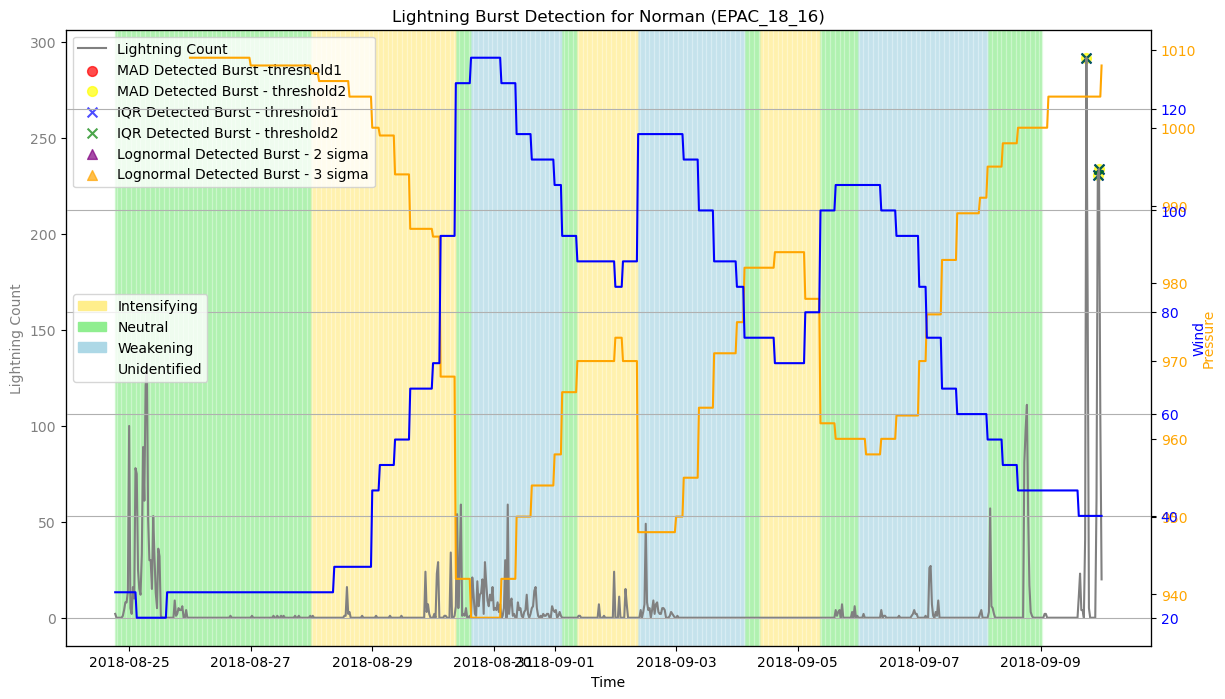

<Figure size 1000x500 with 0 Axes>

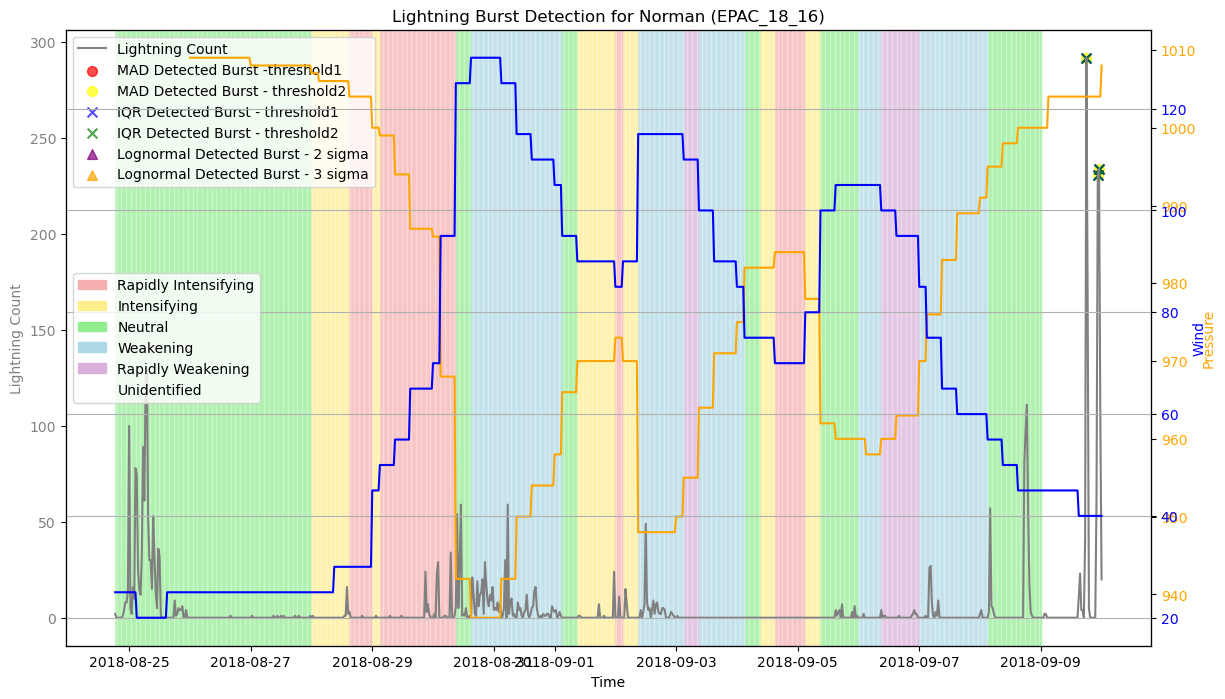

<Figure size 1000x500 with 0 Axes>

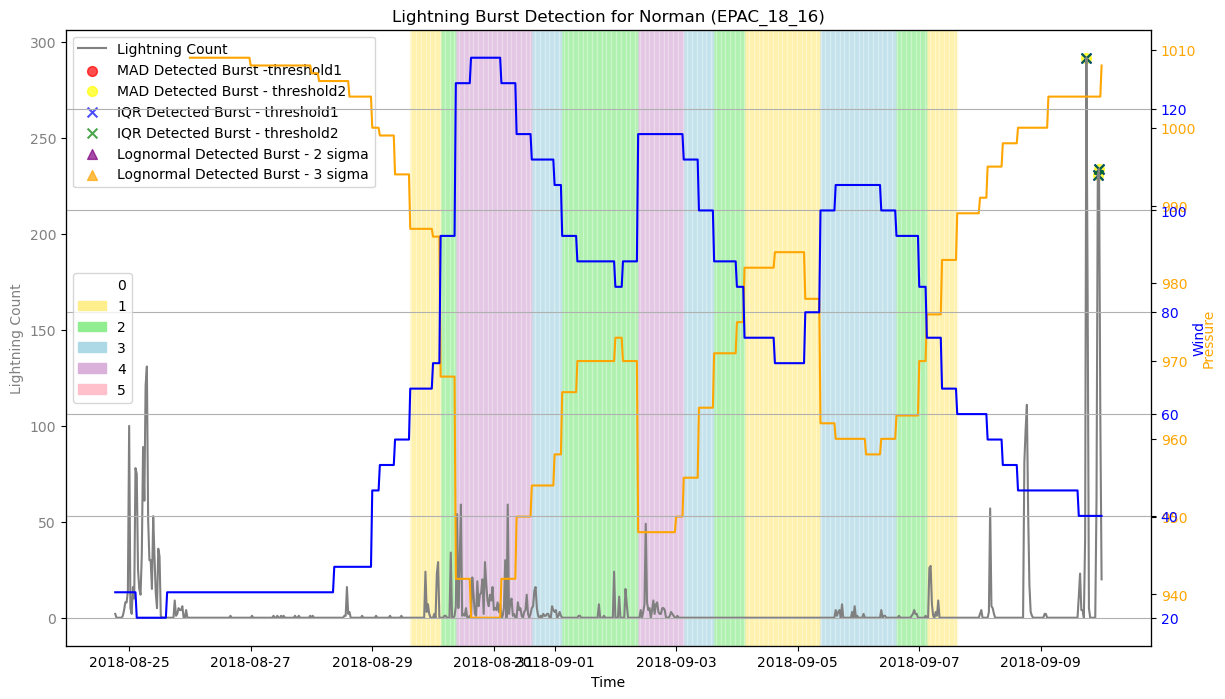

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
27   EPAC_18_16            0            0        6.651423             NaN   
68   EPAC_18_16            0            0        5.928514             NaN   
109  EPAC_18_16            0            0        6.159441             NaN   
150  EPAC_18_16            0            0        5.436531             NaN   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
27             0            0        5.043004             NaN             0   
68             0            0        4.918208             NaN             0   
109            0            0        4.694609             NaN             0   
150            0            0        4.569813             NaN             0   

     ...  logn2_threshold  total_bins  mad1_prop  mad2_prop  iqr1_prop  \
27   ...              NaN         105        0.0        0.0        0.0   
68   ...              NaN         105        0.0        0.0        0.0   
109  ...              NaN         105        0.0        0.0        0.0   
150  ...              NaN         105        0.0        0.0        0.0   

     iqr2_prop  logn1_prop  logn2_prop  std_dev    type  
27         0.0         0.0         0.0      2.0    mean  
68         0.0         0.0         0.0      2.0  median  
109        0.0         0.0         0.0      1.5    mean  
150        0.0         0.0         0.0      1.5  median  

[4 rows x 22 columns]

In [ ]:
# Try plotting one?
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_18_16'
plot_tc_intensification(cyclone_id, epac_weak0_bursts_effthreshold_1_5, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, epac_weak0_bursts_effthreshold_1_5, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, epac_weak0_bursts_effthreshold_1_5, storm_names, innercore_data, "c5")
# Print the summary for this storm
epac_strong_summary_effthreshold[epac_strong_summary_effthreshold["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

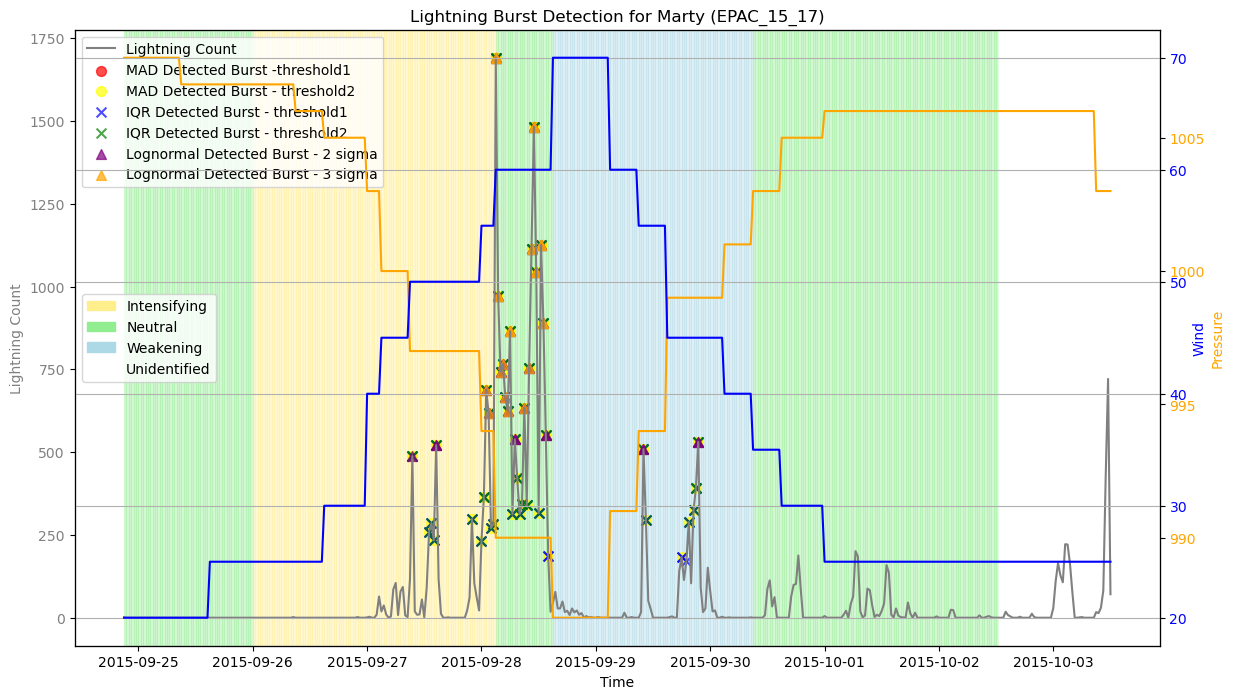

<Figure size 1000x500 with 0 Axes>

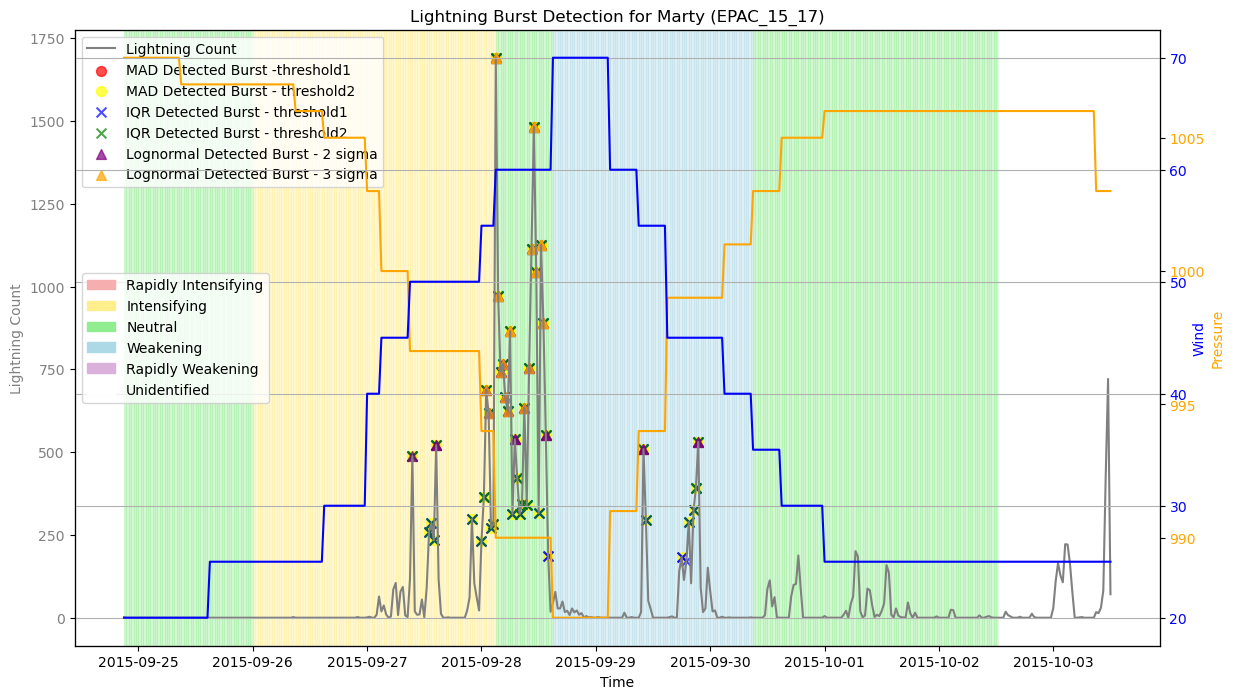

<Figure size 1000x500 with 0 Axes>

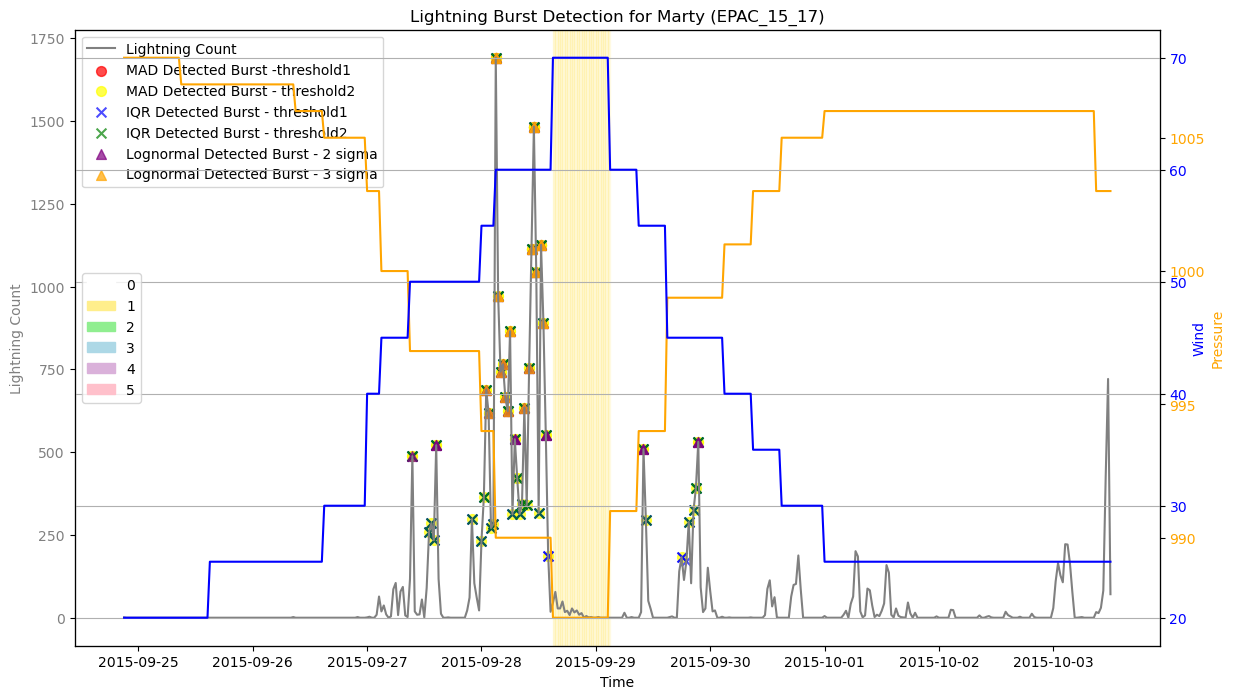

Empty DataFrame
Columns: [storm_code, mad1_bursts, mad2_bursts, mad1_threshold, mad2_threshold, iqr1_bursts, iqr2_bursts, iqr1_threshold, iqr2_threshold, logn1_bursts, logn2_bursts, logn1_threshold, logn2_threshold, total_bins, mad1_prop, mad2_prop, iqr1_prop, iqr2_prop, logn1_prop, logn2_prop, std_dev, type, category_group]
Index: []

[0 rows x 23 columns]

In [ ]:
# Try plotting one?
# EPAC_15_17 - Marty
cyclone_id = 'EPAC_15_17'
plot_tc_intensification(cyclone_id, epac_weak0_bursts_effthreshold_1_5, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, epac_weak0_bursts_effthreshold_1_5, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, epac_weak0_bursts_effthreshold_1_5, storm_names, innercore_data, "c5")
# Print the summary for this storm
epac_strong_summary_effthreshold[epac_strong_summary_effthreshold["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

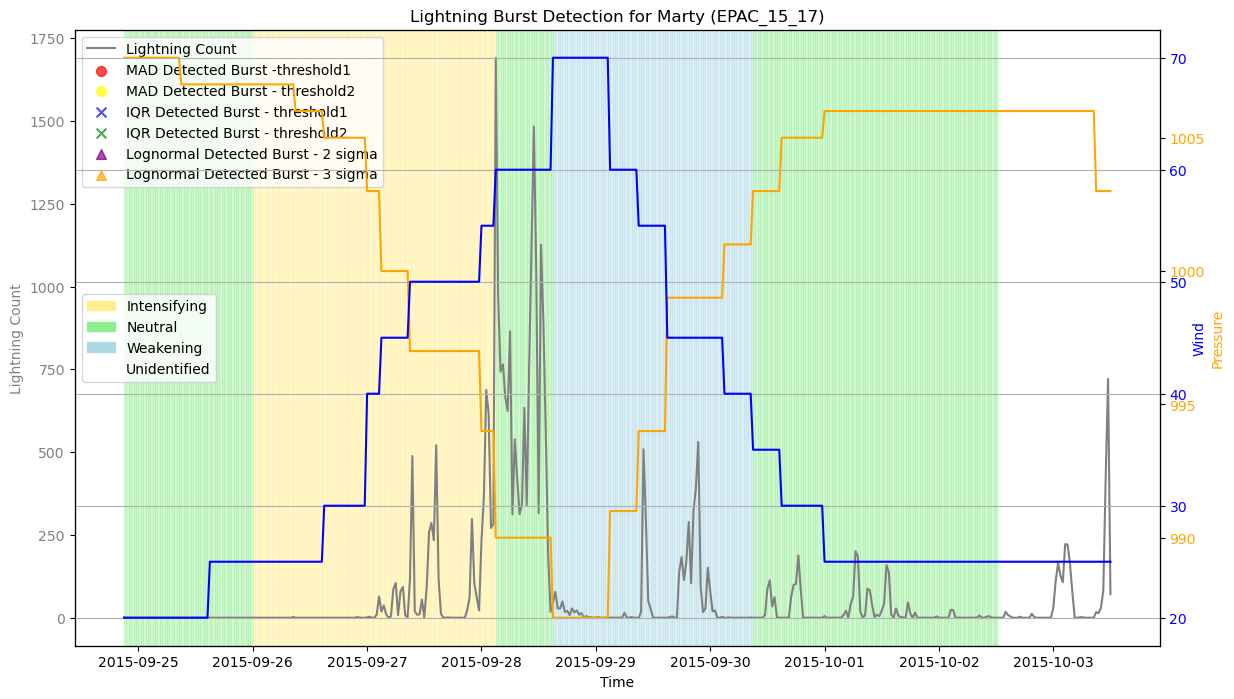

<Figure size 1000x500 with 0 Axes>

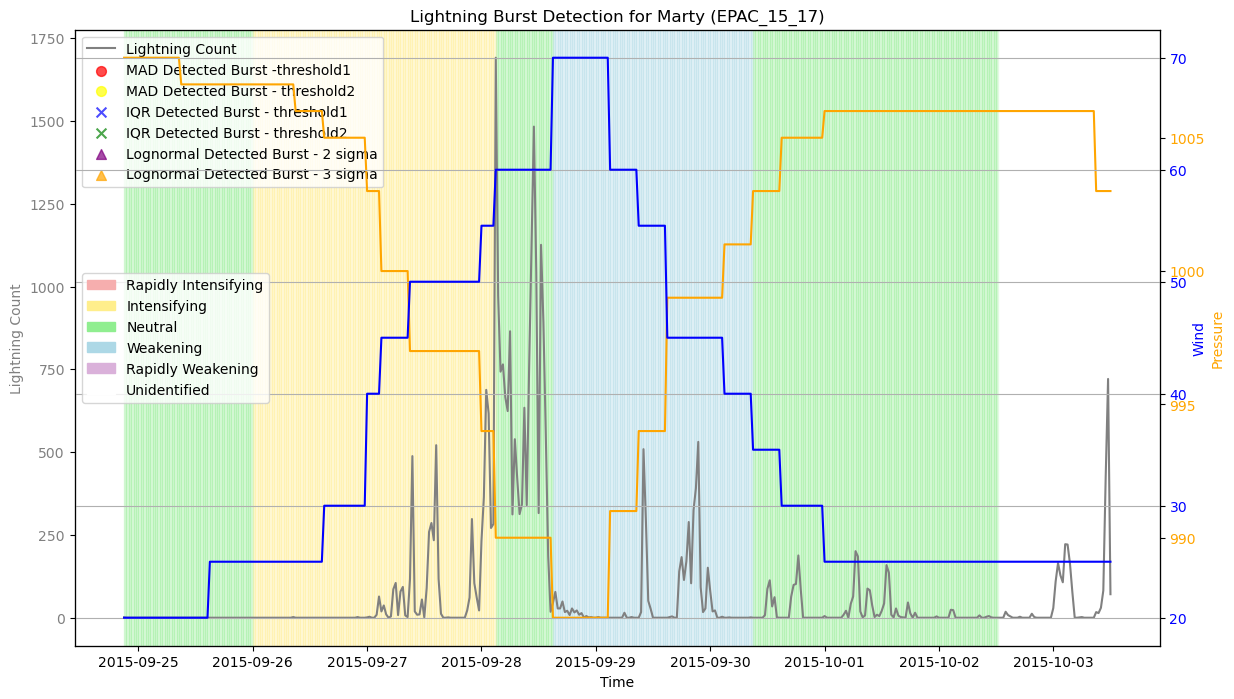

<Figure size 1000x500 with 0 Axes>

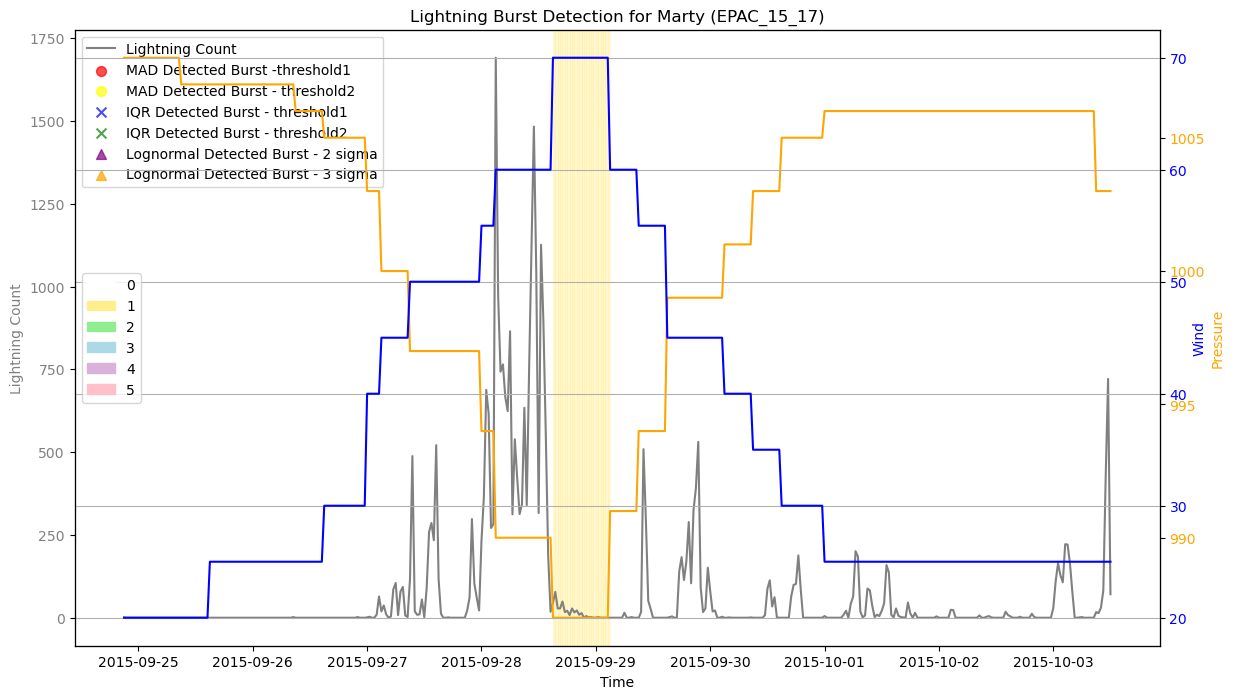

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
315  EPAC_15_17      Marty            0            0       10.379432   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
315        11.87261            0            0        8.684007        10.13956   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
315  ...             0         7.998327         9.901105         111   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
315        0.0        0.0        0.0        0.0         0.0         0.0  

[1 rows x 21 columns]

In [ ]:
# individual detection
# EPAC_15_17 - Marty
cyclone_id = 'EPAC_15_17'
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

---------------------

### ATL Basin
Let's perform the same analysis for the ATL basin. Start by filtering for the ATL TCs.

In [83]:
# Get list of ATL storm codes
atl_data = innercore_data.filter(pl.col("basin") == "ATL")
atl_storm_codes = atl_data["storm_code"].unique()
atl_storm_codes.head(5)

shape: (5,)
Series: 'storm_code' [str]
[
	"ATL_20_16"
	"ATL_20_27"
	"ATL_18_8"
	"ATL_18_2"
	"ATL_19_10"
]

In [84]:
# Filter aggregated table to ATL only
atl_tc_summary = tc_summary[tc_summary["storm_code"].isin(atl_storm_codes)]
atl_tc_summary.head()

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
3   ATL_17_13      Katia            0            0        5.274601   
18  ATL_20_16       Nana            0            0       10.345524   
20   ATL_12_8     Gordon            2            1        2.720473   
33  ATL_10_19    Richard            0            0        8.612224   
34  ATL_20_27    Epsilon            0            0        7.595027   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
3         6.190892            5            1        3.912023        4.716742   
18       11.896122            0            0        8.900928       10.576853   
20        3.125938            5            5        2.079442        2.426015   
33       10.057410            0            0        7.115898        8.548299   
34        8.894310            0            0        5.982688        7.203707   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
3   ...             0         4.128978         5.295669          45   
18  ...             0         7.884307         9.851361          97   
20  ...             0         2.668244         3.379360          35   
33  ...             0         5.959108         7.524432          58   
34  ...             0         5.239370         6.620896          72   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
3        0.00       0.00      11.11       2.22        8.89         0.0  
18       0.00       0.00       0.00       0.00        0.00         0.0  
20       5.71       2.86      14.29      14.29        8.57         0.0  
33       0.00       0.00       0.00       0.00        0.00         0.0  
34       0.00       0.00       0.00       0.00        1.39         0.0  

[5 rows x 21 columns]

In [85]:
# Filter lightning point data to ATL only
atl_bursts = bursts[bursts["storm_code"].isin(atl_storm_codes)]
atl_bursts.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
0 2010-06-26 09:00:00   ATL_10_1                2  2010      6   26     9   
1 2010-06-26 09:30:00   ATL_10_1               13  2010      6   26     9   
2 2010-06-26 13:00:00   ATL_10_1                2  2010      6   26    13   
3 2010-06-26 13:30:00   ATL_10_1                1  2010      6   26    13   
4 2010-06-26 14:30:00   ATL_10_1                1  2010      6   26    14   

   minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
0       0  17.0 -86.2  ...        3.265439        3.908512      False   
1      30  17.0 -86.2  ...        3.265439        3.908512      False   
2       0  17.0 -86.2  ...        3.265439        3.908512      False   
3      30  17.0 -86.2  ...        3.265439        3.908512      False   
4      30  17.0 -86.2  ...        3.265439        3.908512      False   

   burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
0       False       2.720473        3.125938        False        False   
1       False       2.720473        3.125938        False        False   
2       False       2.720473        3.125938        False        False   
3       False       2.720473        3.125938        False        False   
4       False       2.720473        3.125938        False        False   

  logn1_threshold logn2_threshold  
0        3.469047        4.444476  
1        3.469047        4.444476  
2        3.469047        4.444476  
3        3.469047        4.444476  
4        3.469047        4.444476  

[5 rows x 34 columns]

Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

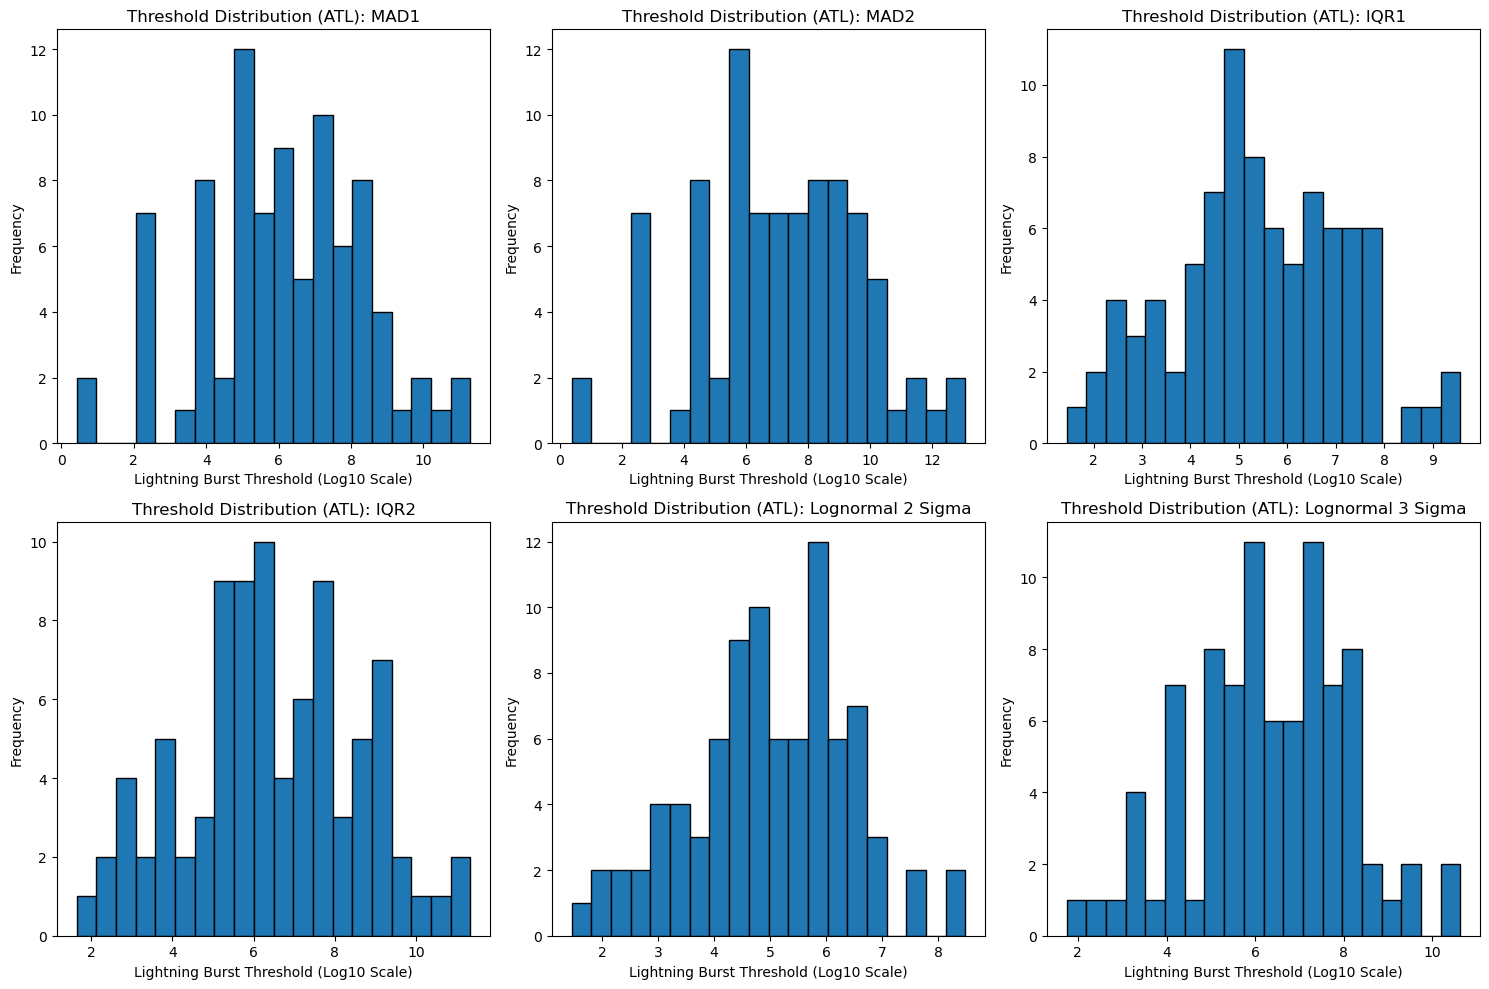

In [86]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

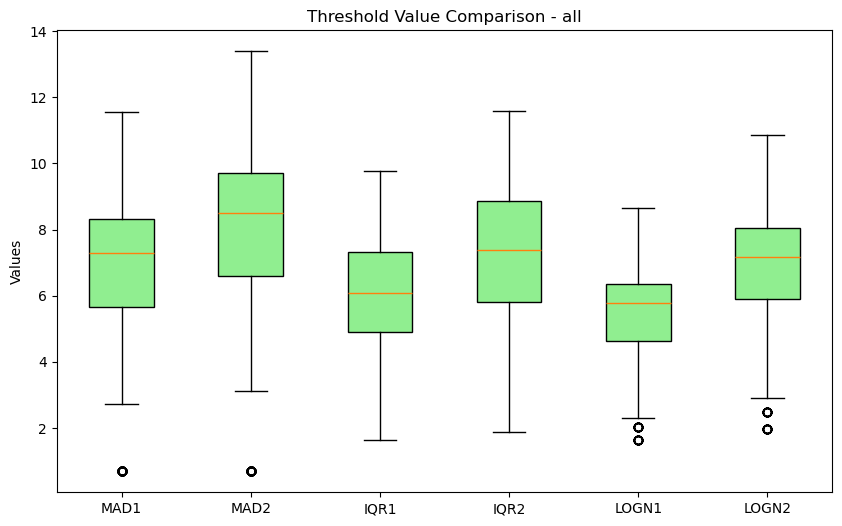

In [87]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(atl_bursts, "all", ax=None)

ideas... fill in later if they're useful at all

Create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [88]:
# Group the data into weak and strong category datasets using function
atl_weak0_lightning, atl_weak1_lightning, atl_strong_lightning = group_bins_category(atl_bursts)

7879 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
2969 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
1564 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


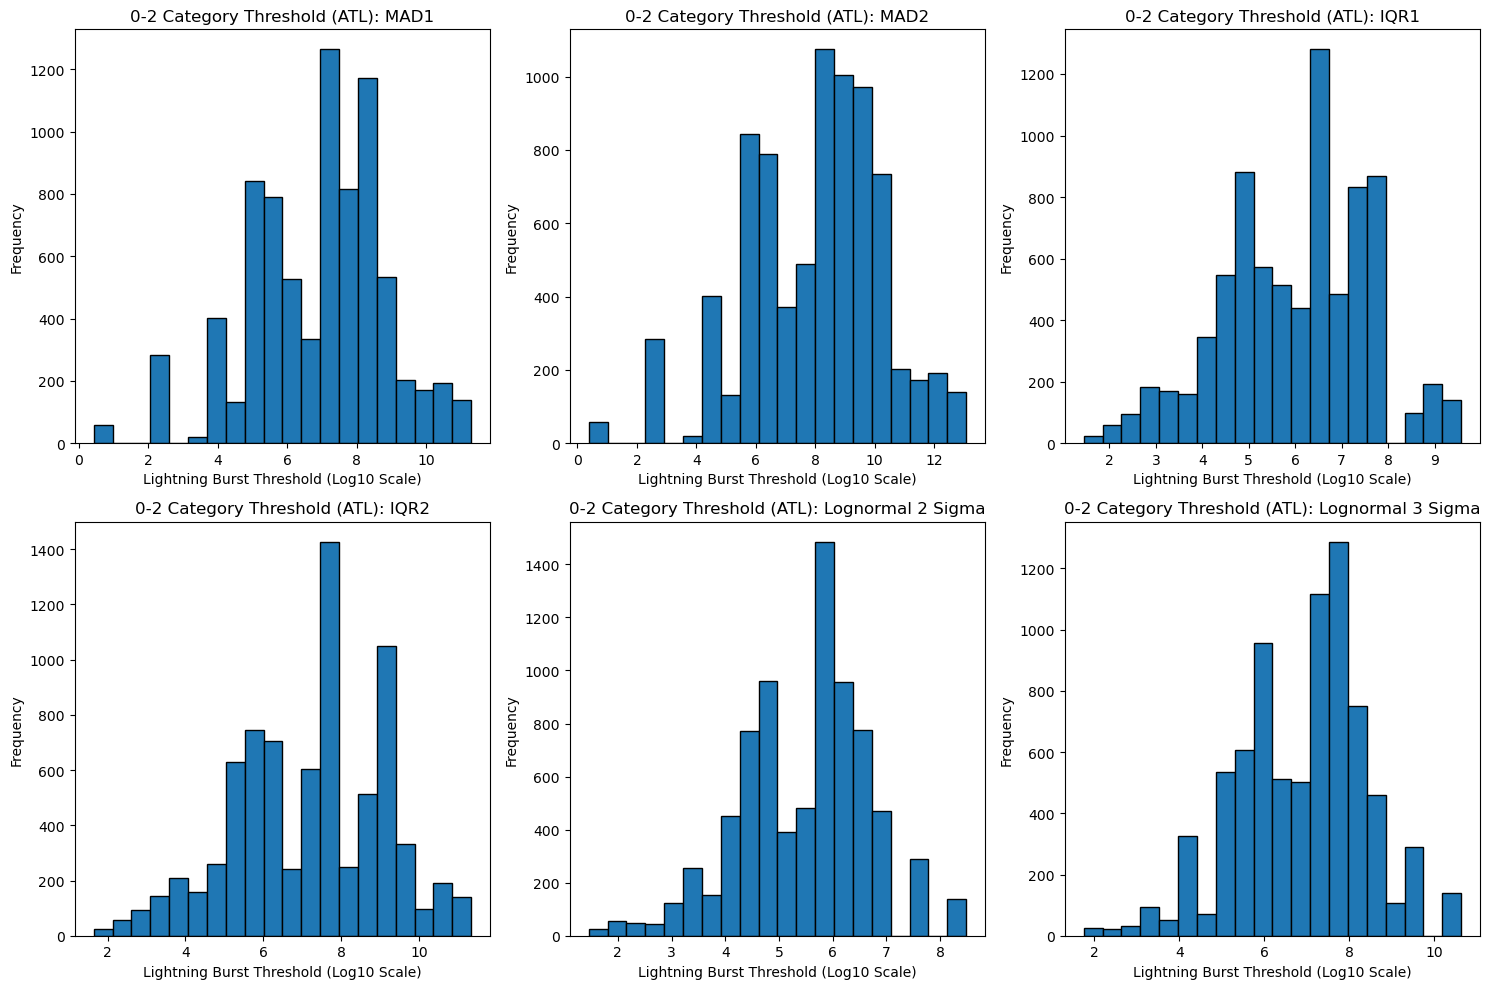

In [89]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

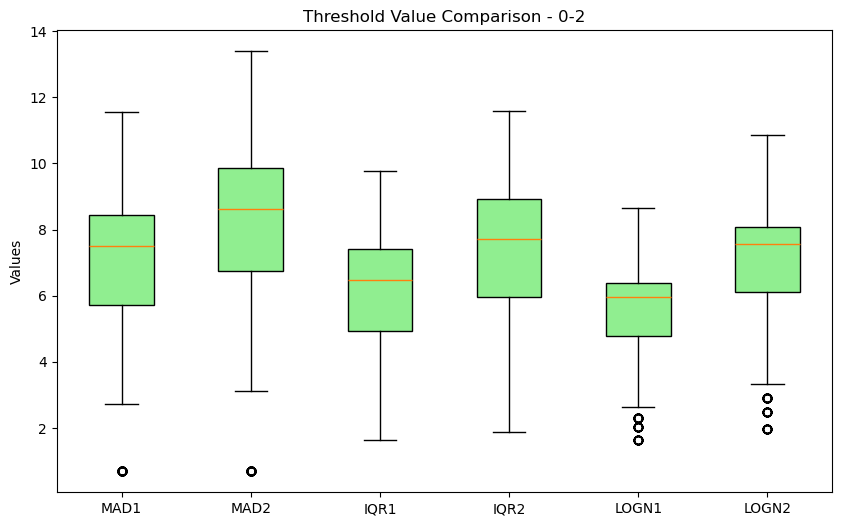

In [90]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(atl_weak0_lightning, "0-2", ax=None)

In [194]:
# effective thresholds
burst_columns = ['burst_iqr1', 'burst_iqr2', 'burst_mad1', 'burst_mad2', 'burst_logn1', 'burst_logn2']
# Filter data to only those with at least one "True" value in the burst columns, grouped by storm code
# Do not include thresholds that don't flag a burst
mask = atl_bursts.groupby("storm_code")[burst_columns].transform(lambda group: group.any(axis=0))

# Filter rows to where at least one burst col has True value
atl_bursts_effective = atl_bursts[atl_bursts[burst_columns].any(axis=1)].copy()

# Set threshold values to NaN where burst columns are False
for burst_col, threshold_col in zip(burst_columns, threshold_cols):
    atl_bursts_effective[threshold_col] = atl_bursts_effective[threshold_col].where(atl_bursts_effective[burst_col], np.nan)

atl_storm_codes_effective = atl_bursts_effective["storm_code"].unique()
atl_tc_summary_effective = atl_tc_summary[atl_tc_summary["storm_code"].isin(atl_storm_codes_effective)]

atl_bursts_effective.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
6  2010-06-26 16:00:00   ATL_10_1               37  2010      6   26    16   
10 2010-06-26 18:30:00   ATL_10_1               56  2010      6   26    18   
11 2010-06-26 19:00:00   ATL_10_1               60  2010      6   26    19   
34 2010-06-29 16:00:00   ATL_10_1               17  2010      6   29    16   
41 2010-09-08 09:30:00  ATL_10_11                4  2010      9    8     9   

    minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
6        0  17.2 -87.3  ...        3.265439        3.908512       True   
10      30  17.2 -87.3  ...        3.265439        3.908512       True   
11       0  17.2 -87.3  ...        3.265439        3.908512       True   
34       0  22.9 -93.6  ...        3.265439             NaN       True   
41      30  13.8 -23.3  ...        2.525729        2.983874       True   

    burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
6         True       2.720473             NaN         True        False   
10        True       2.720473        3.125938         True        False   
11        True       2.720473        3.125938         True        False   
34       False            NaN             NaN        False        False   
41        True            NaN             NaN        False        False   

   logn1_threshold logn2_threshold  
6         3.469047             NaN  
10        3.469047             NaN  
11        3.469047             NaN  
34             NaN             NaN  
41             NaN             NaN  

[5 rows x 34 columns]

In [195]:
atl_effective_summary = create_basin_summary(atl_bursts_effective, "all", "ATL")
atl_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            all      mad1  5.003362  1.475039  5.274601  2.720473   
1   ATL            all      mad2  4.806135  1.416886  4.852030  3.125938   
2   ATL            all      iqr1  3.784668  1.645467  3.121598  1.647918   
3   ATL            all      iqr2  3.703720  1.763110  2.983874  1.886611   
4   ATL            all     logn1  4.973278  1.153221  4.887570  2.031772   
5   ATL            all     logn2  5.158199  1.081248  5.227062  3.670688   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  7.650109          124            328             37.80   
1  6.944217           67            328             20.43   
2  7.836646          172            328             52.44   
3  9.145802           43            328             13.11   
4  7.225276          252            328             76.83   
5  7.602352           13            328              3.96   

   Basin-Category Threshold (Mean-Based) 2 SD  \
0                                    7.953440   
1                                    7.639906   
2                                    7.075602   
3                                    7.229940   
4                                    7.279720   
5                                    7.320696   

   Basin-Category Threshold (Median-Based) 2 SD  
0                                      8.224679  
1                                      7.685802  
2                                      6.412532  
3                                      6.510094  
4                                      7.194011  
5                                      7.389558

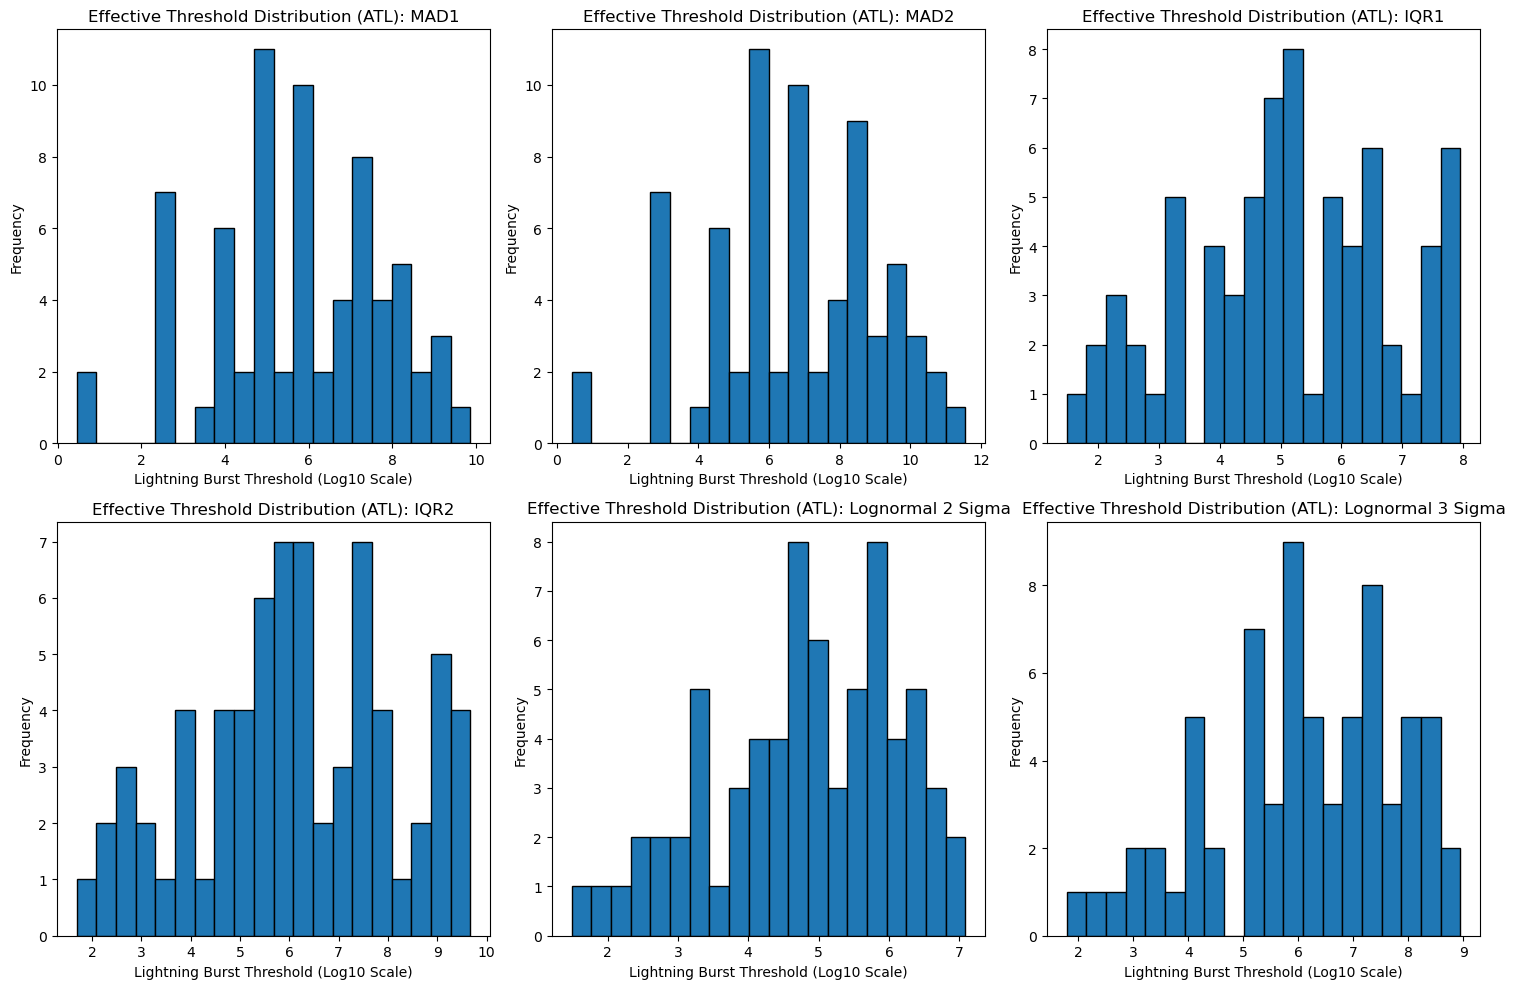

In [197]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_tc_summary_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()